In [26]:
import pandas as pd
pd.set_option('max_colwidth', 100)
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
import itertools
import scipy.stats as st
import seaborn as sns
import scipy

In [27]:
path_to_data = '/Users/zeleninam2/Documents/projects/cbcl_ksads_work/revision_2023/data'
# wave in ['baseline_year_1_arm_1', '2_year_follow_up_y_arm_1']

In [32]:

# ----------------------
# DATA LOADING FUNCTONS
# ----------------------

# FUNCTION TO LOAD KSADS DATA, WHICH WE USE FOR _ALL_ ANALYSES

def load_ksads(path_to_mydata, reporter, wave, do_print = False):
    print('BEGIN LOADING KSADS...')
    assert reporter in ['parent','child'], "wrong reporter" # reporter has to be either parent or child
    assert wave in ['baseline', 'optimal'] # wrong wave
    # Load baseline data
    if reporter == 'child':
        path_to_ksads_data = path_to_mydata+'/abcd-data-release-5.1/core/mental-health/mh_y_ksads_ss.csv'
    elif reporter == 'parent':
        path_to_ksads_data = path_to_mydata+'/abcd-data-release-5.1/core/mental-health/mh_p_ksads_ss.csv'        
    ksads_data = pd.read_csv(path_to_ksads_data, sep=',', header=0, low_memory=False)
    # Select only baseline rows
    if wave == 'baseline':
        ksads_data_bsl = ksads_data.loc[ksads_data.eventname == 'baseline_year_1_arm_1'].copy()
    elif wave == 'optimal':
        ksads_data_bsl = ksads_data.loc[ksads_data.eventname == '2_year_follow_up_y_arm_1'].copy()        
    # check dimensions of the dataset
    if do_print:
        print('\nshape at loading, baseline only')
        print(ksads_data_bsl.shape)
    # ksads - only leave columns with name id and depression diagnoses
    if reporter == 'child':
        depression_column_list = [f'ksads_1_{x}_t' for x in [840, 841, 843, 844, 846]]
        adhd_column_list = ['ksads_14_856_t', 'ksads_14_855_t', 'ksads_14_853_t']
        anxiety_column_list = [ 'ksads_5_906_t',  'ksads_5_857_t', 'ksads_6_908_t',  'ksads_7_861_t',  'ksads_7_909_t',  'ksads_8_863_t',  'ksads_8_911_t', 'ksads_10_913_t', 'ksads_10_869_t', 'ksads_9_867_t']
    elif reporter == 'parent':
        depression_column_list = [f'ksads_1_{x}_p' for x in [840, 841, 843, 844, 846]]
        adhd_column_list = ['ksads_14_856_p', 'ksads_14_855_p', 'ksads_14_853_p']
        anxiety_column_list = [ 'ksads_5_906_p',  'ksads_5_857_p', 'ksads_6_908_p',  'ksads_7_861_p',  'ksads_7_909_p',  'ksads_8_863_p',  'ksads_8_911_p', 'ksads_10_913_p', 'ksads_10_869_p', 'ksads_9_867_p']
    col_list = ['src_subject_id']
    col_list += depression_column_list
    col_list += adhd_column_list
    col_list += anxiety_column_list
    anxiety_or_adhd_column_list = anxiety_column_list + adhd_column_list
    ksads_bsl_id_depanxadhd = ksads_data_bsl.loc[:, col_list]
    # ksads_dict_data = ksads_bsl_id_alldep.to_dict('records') # do we need this?
    # change types to float so I can work with them 
    ksads_bsl_id_depanxadhd = ksads_bsl_id_depanxadhd.set_index('src_subject_id')
    ksads_bsl_id_depanxadhd = ksads_bsl_id_depanxadhd.astype(float)
    # work with missing values (could be encoded as 555 or 888)
    if do_print:
        print('\nhow many nans:')
        for c in ksads_bsl_id_depanxadhd.columns:
            print(ksads_bsl_id_depanxadhd[c].value_counts())
    # in child data, there are some columns that are fully nan. remove them
    if reporter == 'child':
        nan_columns = ['ksads_14_856_t', 'ksads_14_855_t', 'ksads_14_853_t', 'ksads_9_867_t', 'ksads_5_906_t', 'ksads_5_857_t',  'ksads_6_908_t', 'ksads_7_861_t', 'ksads_7_909_t']
        # just do this once to check if everything in these columns are nans
        #print('\n check that nan-columns are truly nan')
        #for c in nan_columns:
            #print(ksads_bsl_id_depanxadhd[c].value_counts())
        ksads_bsl_id_depanxadhd = ksads_bsl_id_depanxadhd.drop(columns = nan_columns)
        # only keeping non-nan columns 
        adhd_column_list = []
        if reporter == 'child':
            anxiety_column_list = ['ksads_8_863_t', 'ksads_8_911_t', 'ksads_10_913_t', 'ksads_10_869_t']
        col_list = []
        col_list += depression_column_list
        col_list += adhd_column_list
        col_list += anxiety_column_list
        anxiety_or_adhd_column_list = anxiety_column_list + adhd_column_list
        ksads_bsl_id_depanxadhd = ksads_bsl_id_depanxadhd.loc[:, col_list]
    # dealing with nan rows
    # do this once to make sure values are 0, 1, or 555/888
    #for c in ksads_bsl_id_depanxadhd.columns:
        #print(ksads_bsl_id_depanxadhd[c].value_counts())
    # if encoded as 555 or 888, replace with nan
    ksads_bsl_id_depanxadhd[ksads_bsl_id_depanxadhd > 1.0] = np.nan
    # [QUESTION] ???
    #nnans = ksads_bsl_id_alldep.isnull().sum(1)
    #print('\nnnans')
    #print(nnans)
    #bad_ids = nnans[nnans > 1].index
    #print('\nbad ids')
    #print(bad_ids)
    #good_ids = nnans[nnans == 0].index
    #ksads_dat = (ksads_bsl_id_alldep.loc[good_ids].sum(1) > 0).astype(int)
    #print('\ngood id sum')
    #print(ksads_dat.sum())
    # drop all rows that include nans
    ksads_bsl_id_depanxadhd = ksads_bsl_id_depanxadhd.dropna()
    if do_print:
        print('\n shape after droping nans')
        print(ksads_bsl_id_depanxadhd.shape)
    # sum ksads scores of individual diagnoses to reach the overall ksads score, which we will use a gs
    ksads_bsl_id_depanxadhd['any_depression'] = (ksads_bsl_id_depanxadhd.loc[:, depression_column_list] > 0).sum(1) > 0
    ksads_bsl_id_depanxadhd['anxadhd_null'] = ksads_bsl_id_depanxadhd.loc[:, adhd_column_list + anxiety_column_list].isnull().sum(1) > 0
    ksads_bsl_id_depanxadhd['good'] = ksads_bsl_id_depanxadhd.any_depression | (~ksads_bsl_id_depanxadhd.anxadhd_null)
    bad_ids = ksads_bsl_id_depanxadhd.loc[~ksads_bsl_id_depanxadhd.good].index
    good_ids = ksads_bsl_id_depanxadhd.loc[ksads_bsl_id_depanxadhd.good].index
    if do_print:
        check1 = (ksads_bsl_id_depanxadhd.loc[:, depression_column_list].sum(1) > 0).astype(int)
        print('check1')
        print(check1.sum())
    ksads_dat = (ksads_bsl_id_depanxadhd.loc[good_ids, depression_column_list].sum(1) > 0).astype(int)
    ksads_dat = pd.DataFrame(ksads_dat).rename(columns={0:'ksads_DEPRESSION'})
    ksads_dat['ksads_ANXIETY'] = (ksads_bsl_id_depanxadhd.loc[good_ids, anxiety_column_list].sum(1) > 0).astype(int)
    ksads_dat['ksads_ADHD'] = (ksads_bsl_id_depanxadhd.loc[good_ids, adhd_column_list].sum(1) > 0).astype(int)
    ksads_dat['ksads_ADHD_OR_ANXIETY'] = (ksads_bsl_id_depanxadhd.loc[good_ids, anxiety_or_adhd_column_list].sum(1) > 0).astype(int)
    # sometimes the sum is more than one, if more than one depression diagnosis given
    # I want a binary value, so let's just put these to 1
    #ksads_bsl_id_dep[ksads_bsl_id_dep > 1.0] = 1.0
    if do_print:
        print('\nksads DEPRESSION value counts')
        print(ksads_dat['ksads_DEPRESSION'].value_counts())
    # creating different combinations of depression, anxiety, adhd comorbidities
    DEPyes_ANXADHDno = []
    DEPno_ANXADHDyes = []
    for index, row in ksads_dat.iterrows():
        if row['ksads_DEPRESSION'] == 1 and row['ksads_ADHD_OR_ANXIETY'] == 0:
            DEPyes_ANXADHDno.append(1)
        else:
            DEPyes_ANXADHDno.append(0)   
        if row['ksads_DEPRESSION'] == 0 and row['ksads_ADHD_OR_ANXIETY'] == 1:
            DEPno_ANXADHDyes.append(1)
        else:
            DEPno_ANXADHDyes.append(0)
    ksads_dat['ksads_DEPyes_ANXADHDno'] = DEPyes_ANXADHDno
    ksads_dat['ksads_DEPno_ANXADHDyes'] = DEPno_ANXADHDyes 
    if do_print:
        print(ksads_dat['ksads_DEPyes_ANXADHDno'].value_counts())
        print(ksads_dat['ksads_DEPno_ANXADHDyes'].value_counts())
    # this is just renaming the sum depression columns
    #ksads_bsl_id_dep = pd.DataFrame(ksads_bsl_id_dep).rename(columns = {0:'ksads_dep_binary'})
    #if do_print:
        #print('\nfinal number of subjects overall')
        #print(ksads_bsl_id_dep.shape[0])
    if do_print:
        print('\nfinal sample size')
        print(ksads_dat.shape)
    print('\n...FINISH LOADING KSADS')
    return ksads_dat

# FUNCTION TO LOAD CBCL DATA

def load_cbcl(path_to_mydata, wave, do_print = False):
    print('BEGIN LOADING CBCL...')
    assert wave in ['baseline', 'optimal'] # wrong wave
    path_to_cbcl = path_to_data+'/abcd-data-release-5.1/core/mental-health/mh_p_cbcl.csv'
    cbcl_data = pd.read_csv(path_to_cbcl, sep=',', header=0, low_memory=False)
    if wave == 'baseline':
        cbcl_data_bsl = cbcl_data.loc[cbcl_data.eventname == 'baseline_year_1_arm_1'].copy()
    elif wave == 'optimal':
        cbcl_data_bsl = cbcl_data.loc[cbcl_data.eventname == '2_year_follow_up_y_arm_1'].copy() 
    if do_print:
        print('\ncbcl shape at loading, baseline only')
        print(cbcl_data_bsl.shape)
    # only leave columns with id and depression diagnosis
    # use RAW SCORE for depresison diagnosis, previously used cbcl_scr_dsm5_depress_t
    col_list_cbcl = ['src_subject_id', 'cbcl_scr_dsm5_depress_r']
    cbcl_bsl_id_dep = cbcl_data_bsl.loc[:, col_list_cbcl]
    cbcl_bsl_id_dep = cbcl_bsl_id_dep.set_index('src_subject_id')
    if do_print:
        print('\cbcl values')
        print(cbcl_bsl_id_dep.cbcl_scr_dsm5_depress_r.value_counts())
        print ('\nshape after merging')
        print(cbcl_bsl_id_dep.shape)
    cbcl_bsl_id_dep = cbcl_bsl_id_dep.dropna()
    if do_print:
        print ('\nshape after checking for nans')
        print(cbcl_bsl_id_dep.shape) 
    # rename input value
    #cbcl_bsl_id_dep = pd.DataFrame(cbcl_bsl_id_dep).rename(columns = {0:'input_measure'})
    cbcl_bsl_id_dep = cbcl_bsl_id_dep.rename(columns={"cbcl_scr_dsm5_depress_r": "input_measure"}, errors="raise")
    print('...FINISH LOADING CBCL')
    return cbcl_bsl_id_dep

def load_cbcl_anxdep_withdep(path_to_mydata, wave, scale, do_print = False):
    # TODO
    print('BEGIN LOADING CBCL, anx/dep or with/dep...')
    # https://www.researchgate.net/publication/7893970_Evaluating_behavioral_and_emotional_problems_with_the_Child_Behavior_Checklist_and_Youth_Self-Report_scales_Cross-informant_and_longitudinal_associations/figures?lo=1
    '''
    ANX/DEP:
    lonely | cbcl_q12_p
    cries a lot | cbcl_q14_p	
    fears impulses | cbcl_q41_p "impulsive or acts without thinking"
    needs to be perfect | cbcl_q32_p	
    feels unloved | cbcl_q33_p
    feels persecuted | ?
    feels worthless | cbcl_q35_p	
    nervous, tense | cbcl_q45_p
    fearful, anxious | cbcl_q50_p
    feels too guilty | cbcl_q52_p
    self-conscious | cbcl_q71_p
    suspicious | cbcl_q89_p
    unhappy, sad, depressed | cbcl_q103_p
    worries | cbcl_q112_p
    
    WITHD
    would rather be alone | cbcl_q42_p
    refuses to talk | cbcl_q65_p
    secretive | cbcl_q69_p
    shy, timid | cbcl_q75_p
    underactive | cbcl_q102_p
    unhappy, sad, depressed | cbcl_q103_p
    withdrawn | cbcl_q111_p
    <stares blankly - not on YSR> | cbcl_q80_p
    <sulks - not on YSR> | cbcl_q88_p
    '''
    assert wave in ['baseline', 'optimal'] # wrong wave
    assert scale in ['anxiousdep', 'withdrawndep'] # wrong wave
    path_to_cbcl = path_to_data+'/abcd-data-release-5.1/core/mental-health/mh_p_cbcl.csv'
    cbcl_data = pd.read_csv(path_to_cbcl, sep=',', header=0, low_memory=False)
    if wave == 'baseline':
        cbcl_data_bsl = cbcl_data.loc[cbcl_data.eventname == 'baseline_year_1_arm_1'].copy()
    elif wave == 'optimal':
        cbcl_data_bsl = cbcl_data.loc[cbcl_data.eventname == '2_year_follow_up_y_arm_1'].copy() 
    if do_print:
        print('\ncbcl shape at loading, baseline only')
        print(cbcl_data_bsl.shape)
    # only leave columns with id and depression diagnosis
    # use RAW SCORE for depresison diagnosis, previously used cbcl_scr_dsm5_depress_t
    if scale == 'anxiousdep':
        scale_column_list = ['cbcl_q12_p',
                        'cbcl_q14_p',
                        'cbcl_q41_p',
                        'cbcl_q32_p',
                        'cbcl_q33_p',
                        'cbcl_q35_p',
                        'cbcl_q45_p',
                        'cbcl_q50_p',
                        'cbcl_q52_p',
                        'cbcl_q71_p',
                        'cbcl_q89_p',
                        'cbcl_q103_p',
                        'cbcl_q112_p']
    elif scale == 'withdrawndep':
        scale_column_list = ['cbcl_q42_p',
                        'cbcl_q65_p',
                        'cbcl_q69_p',
                        'cbcl_q75_p',
                        'cbcl_q102_p',
                        'cbcl_q103_p',
                        'cbcl_q111_p',
                        'cbcl_q80_p',
                        'cbcl_q88_p']  
    col_list_cbcl = ['src_subject_id'] + scale_column_list
    cbcl_bsl_id_dep = cbcl_data_bsl.loc[:, col_list_cbcl]
    cbcl_bsl_id_dep = cbcl_bsl_id_dep.set_index('src_subject_id')
    # print value counts
    if do_print:
        print('\ncheck for nans')
        for c in cbcl_bsl_id_dep.columns:
            print(cbcl_bsl_id_dep[c].value_counts())
    # deal with nans
    cbcl_bsl_id_dep[cbcl_bsl_id_dep > 3.0] = np.nan    
    if do_print:
        print('\ncheck for nans')
        for c in cbcl_bsl_id_dep.columns:
            print(cbcl_bsl_id_dep[c].value_counts())    
    cbcl_bsl_id_dep = cbcl_bsl_id_dep.dropna()
    if do_print:
        print(cbcl_bsl_id_dep.shape)
        print(cbcl_bsl_id_dep.head())        
    # calculate value
    # something wrong here
    output_data = cbcl_bsl_id_dep.copy(deep=True)
    output_data['input_measure'] = (cbcl_bsl_id_dep.loc[:, scale_column_list].sum(1))
    if do_print:
        print(output_data.shape)
        print(output_data.head())     
    if do_print:
        print(output_data['input_measure'].value_counts())
    print('...FINISH LOADING CBCL, anx/dep or with/dep...')
    return output_data

def load_ysr(path_to_mydata, wave = 'optimal', do_print = False):
    '''
    From https://wiki.abcdstudy.org/release-notes/non-imaging/mental-health.html:
    Brief Problem Monitor (ASEBA) Release 5.0 Data Table: mh_y_bpm
    Measure Description: Normed multi-informant monitoring of children’s functioning. This is the youth self-report. 
    The BPM’s Internalizing (INT), Attention Problems (ATT), Externalizing (EXT), and Total Problems (TOT) scales 
    comprise items from the ASEBA Youth Self-Report (YSR). The items, scales, and norms are based on decades of research and 
    practical experience, as summarized in the BPM Manual (Achenbach, McConaughy, Ivanova, & Rescorla, 2017).
    '''
    print('BEGIN LOADING YSR...')
    path_to_ysr = path_to_data+'/abcd-data-release-5.1/core/mental-health/mh_y_bpm.csv'
    assert wave in ['optimal'] # wrong wave; there is no baseline data for ysr
    ysr_data = pd.read_csv(path_to_ysr, sep=',', header=0, low_memory=False)
    # optimal wave only; I could simplify it but maybe we'll change something in the future
    if wave == 'optimal':
        ysr_data_bsl = ysr_data.loc[ysr_data.eventname == '2_year_follow_up_y_arm_1'].copy() 
    if do_print:
        print('\nysr shape at loading, optimal wave only')
        print(ysr_data_bsl.shape)
    col_list = ['src_subject_id', 'bpm_y_scr_internal_r']
    ysr_data_intern = ysr_data_bsl.loc[:, col_list]
    ysr_data_intern = ysr_data_intern.set_index('src_subject_id')
    # remove nans
    ysr_data_intern = ysr_data_intern.dropna()
    if do_print:
        print ('\nshape after checking for nans')
        print(ysr_data_intern.shape)
    #ysr_data_intern = pd.DataFrame(ysr_data_intern).rename(columns = {0:'input_measure'})
    ysr_data_intern = ysr_data_intern.rename(columns={"bpm_y_scr_internal_r": "input_measure"}, errors="raise")
    print('...FINISH LOADING YSR')
    return ysr_data_intern
   

# FUNCTION TO MERGE DATASETS

def merge_my_data(measure_data, ksads_data, do_print = False):
    print('BEGIN MERGING...')
    # check if shapes of data match ot not
    if do_print:
        print('samples in measure (cbcl,ysr,...) data:')
        print(measure_data.shape)
        print('samples in gold standard (ksads) data:')
        print(ksads_data.shape)  
    # merge on ksads data
    # merging on ksads because we need all subjects to have a gold standard ksads number
    data_ksads_and_measure = pd.merge(ksads_data, measure_data, how='left', left_index = True, right_index = True, indicator=True)
    # check if there are items that are present in only one dataframe
    if do_print:
        if len(data_ksads_and_measure.query('_merge != "both"')) != 0:
            print('merge indicator:')
            print(data_ksads_and_measure._merge.value_counts())
            print(data_ksads_and_measure.loc[data_ksads_and_measure._merge == 'left_only'])
    # only keep rows that have data from *both* dataframes
    data_ksads_and_measure = data_ksads_and_measure.loc[data_ksads_and_measure._merge == 'both'].drop(columns=['_merge']) 
    # shape after merging
    if do_print:
        print('\shape after merging')
        print(data_ksads_and_measure.shape)
    # I don't think we need to do this. This was removing null values, whoch is how missing data used to be encoded.
    # cbcl_t takes values form 50 to 50-something.
    # cbcl_r takes values from 0 to 19, and so 0 is meaningful.
    #data_ksads_cbcl = data_ksads_cbcl.loc[data_ksads_cbcl.cbcl_scr_dsm5_depress_t.notnull()].copy()
    #data_ksads_cbcl['cbcl_scr_dsm5_depress_t'] = data_ksads_cbcl.cbcl_scr_dsm5_depress_t.astype(int)
    # We shouldn't have any nans but let's heck just to be extra careful
    data_ksads_and_measure = data_ksads_and_measure.dropna()
    if do_print:
        print ('\nshape after checking for nans')
        print(data_ksads_and_measure.shape) 
    print('...FINISH MERGING')
    return data_ksads_and_measure

def preprocess_data(my_data, percent_positives, hypothesis, sex='both', do_print=False):
    # split into negative and positive diagnoses based on desired percentage
    print ('BEGIN PREPROCESSING...')
    null_rows = my_data.input_measure.isnull().sum()
    print('\nLast check of missing data. Non-null rows = %d' % (null_rows))
    # split into negative and positive ksads diagnoses
    if hypothesis == '1':
        is_pos =  my_data['ksads_DEPRESSION']==1 
        is_neg =  (my_data['ksads_DEPRESSION']==0) & (my_data['input_measure'].notnull() )
    elif hypothesis == '2a':
        # this seems correct...
        is_pos = my_data['ksads_DEPRESSION']==1
        #is_neg = (my_data['ksads_DEPRESSION']==0) & (my_data['ksads_ADHD_OR_ANXIETY']==1) & (my_data['input_measure'].notnull() )
        is_neg = (my_data['ksads_DEPno_ANXADHDyes']==1) & (my_data['input_measure'].notnull())
    elif hypothesis == '2b':
        # this also seems correct...
        is_pos = my_data['ksads_DEPyes_ANXADHDno']==1
        is_neg = (my_data['ksads_DEPno_ANXADHDyes']==1) & (my_data['input_measure'].notnull())
    else:
        print('WRONG HYPOTHESIS')
    pos_ksads_all = my_data[is_pos]
    neg_ksads_all = my_data[is_neg]
    # lets check that they don't overlap
    print('\nCheck that positives and negatives dont overlap')
    idx = pos_ksads_all.index.intersection(neg_ksads_all.index)
    print(idx)
    # randomly choose the negative subsample
    num_pos = pos_ksads_all.shape[0] # this is how many positives we have. using all of them
    num_neg_all = neg_ksads_all.shape[0] # this is how many negatives we have 
    pos_rate = (100-percent_positives)/10
    num_neg_want = num_pos*pos_rate # this is how many negatives we want
    print('FINAL Number of positives in the data n=%d' % (num_pos))
    print('Number of negatives in the data (before subsampling) n=%d' % (num_neg_all))  
    print('Overall sample size (before subsampling) n=%d' % (num_pos + num_neg_all))
    if num_neg_want >= num_neg_all: # if we want more negatives than we have, or all of the negatives that we have
        print('Not enough negative samples to use the desired neg/pos rate. Using all negative samples')
        neg_ksads_subsample = neg_ksads_all # then use all of them
    else: # otherwise:
        size_subsample = num_pos*percent_positives-num_pos
        neg_ksads_subsample = neg_ksads_all.sample(n = size_subsample, random_state = 4) # choose a subsample of negatives of our desired proportion
    print('FINAL Number of negatives in the data (after subsampling) n=%d' % (neg_ksads_subsample.shape[0])) 
    print('FINAL Overall sample size (before subsampling) n=%d' % (num_pos + neg_ksads_subsample.shape[0]))
    # mix all positives and negatives. Then shuffle (I don't why but won't hurt)
    frames = [pos_ksads_all, neg_ksads_subsample]
    my_subsample = pd.concat(frames)
    my_subsample = my_subsample.sample(frac = 1)
    # THIS IS NEW SEX/GENDER STUFF
    if True:
        path_to_demo_data = path_to_data+'/abcd-data-release-5.1/core/abcd-general/abcd_p_demo.csv'
        demo_data = pd.read_csv(path_to_demo_data, sep=',', header=0, low_memory=False)
            # demo_sex_v2 - sex at birth
            # 1 = Male Masculino; 
            # 2 = Female Femenino; 
            # 3 = Intersex-Male Entre sexo-masculino; 
            # 4 = Intersex-Female Entre sexo-femenino; 
            # 999 = Don't know No lo s√É¬©; 
            # 777 = Refuse to answer Prefiero no responder
            # demo_gender_id_v2 - current gender identity
            # 1 = Male Hombre; 
            # 2 = Female Mujer; 
            # 3 = Trans male Transexual masculino / hombre transexual; 
            # 4 = Trans female Transexual femenino / mujer transexual; 
            # 5 = Gender queer Interg√É¬©nero ("genderqueer") / No conforme con el g√É¬©nero; 
            # 6 = Different Otra identididad; 
            # 777 = Refuse to answer Niego contestar; 
            # 999 = Don't know No lo s√É¬©
        # merge my dataframe with demo dataframe
        # merge on subsamples data
        #print(demo_data.src_subject_id.value_counts())
        values = demo_data['src_subject_id'].value_counts().keys().tolist()
        counts = demo_data['src_subject_id'].value_counts().tolist()
        if do_print:
            print(counts)
        demo_data = demo_data.set_index('src_subject_id')
        # demo_data = demo_data.loc[:, ['demo_sex_v2', 'demo_gender_id_v2']]
        demo_data = demo_data.loc[:, ['demo_sex_v2', 'demo_brthdat_v2']]
        demo_data = demo_data.dropna()
        data_with_sex = pd.merge(my_subsample, demo_data, how='left', left_index = True, right_index = True, indicator=True)
        # check if there are items that are present in only one dataframe
        if do_print:
            if len(data_with_sex.query('_merge != "both"')) != 0:
                print('SOMETHING WRONG WITH MERGE')
                print('merge indicator:')
                print(data_with_sex._merge.value_counts())
                print(data_with_sex.loc[data_with_sex._merge == 'left_only'])
        # only keep rows that have data from *both* dataframes
        data_with_sex = data_with_sex.loc[data_with_sex._merge == 'both'].drop(columns=['_merge']) 
        print(data_with_sex['demo_sex_v2'].value_counts())
        data_with_sex.to_csv('/Users/zeleninam2/Documents/projects/cbcl_ksads_work/revision_2023/results/my_subsample.csv', sep=',', index=False, encoding='utf-8')
        data_boys = data_with_sex.query('demo_sex_v2 == 1.0')
        data_girls = data_with_sex.query('demo_sex_v2 == 2.0')
        # output positive and negative samples from boys and girls
        if hypothesis == '1' or hypothesis == '2a':
            girls_pos = data_girls.query('ksads_DEPRESSION == 1')
            boys_pos = data_boys.query('ksads_DEPRESSION == 1')
        elif hypothesis == '2b':
            girls_pos = data_girls.query('ksads_DEPyes_ANXADHDno == 1')
            boys_pos = data_boys.query('ksads_DEPyes_ANXADHDno == 1')
        if hypothesis == '1':
            girls_neg = data_girls.query('ksads_DEPRESSION == 0')
            boys_neg = data_boys.query('ksads_DEPRESSION == 0')
        elif hypothesis == '2a' or hypothesis == '2b':
            girls_neg = data_girls.query('ksads_DEPno_ANXADHDyes == 1')
            boys_neg = data_boys.query('ksads_DEPno_ANXADHDyes == 1')            

        if do_print:
            print('Positive girls in sample = %d' % girls_pos.shape[0])
            print('Negative girls in sample = %d' % girls_neg.shape[0])
            print('Positive boys in sample = %d' % boys_pos.shape[0])
            print('Negative boys in sample = %d' % boys_neg.shape[0])
        print ('\n...END PREPROCESSING')
        if sex == 'boys':
            return data_boys
        elif sex == 'girls':
            return data_boys
        elif sex == 'both':
            return my_subsample
        else:            
            print('WRONG GENDER')
    
# -----------------
# ANALYSIS FUNCTONS
# -----------------

# help function for bootstrapping
def gen_auc_boots(scores, truth, nboots, rng=None):
    if rng is None:
        rng = np.random.default_rng()
    boot_res = []
    for pp in range(nboots):
        boot_ind = rng.choice(range(len(truth)), size=truth.size, replace=True)
        boot_truth = truth.iloc[boot_ind]
        boot_score = scores.iloc[boot_ind]
        boot_res.append(roc_auc_score(boot_truth, boot_score))
    return np.array(boot_res)

# main analysis function
def run_aucroc_and_plot(my_dat, path_to_save_plots, name_to_save, mymeasure, hypothesis, nboots=100, target_auc=0.8, do_print = False):
    # [TODO] CHANGE TARGET_AUC FOR HYP 2B
    # using https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#sphx-glr-auto-examples-model-selection-plot-roc-py
    print('BEGIN AUCROC...')
    if do_print:
        print(my_dat.head())
    y_measure_df = my_dat['input_measure'] # called y_score in the example
    # I'm getting weird scores for H2a, 2b
    # I think the problem is here
    if hypothesis in ['1', '2a']:   
        y_true_df = my_dat['ksads_DEPRESSION'] # called y_test in the example
    elif hypothesis == '2b':
        y_true_df = my_dat['ksads_DEPyes_ANXADHDno'] # called y_test in the example
    if do_print:
        print(my_dat.head())        
    sample_auc_score = roc_auc_score(y_true_df, y_measure_df)
    print('\nSingle AUCROC score without bootstrapping:')
    print(sample_auc_score)
    #print('\nSingle AUCROC score without bootstrapping = %d' % (sample_auc_score))
    # plotting
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    fpr, tpr, _ = roc_curve(y_true_df, y_measure_df)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    lw = 2
    plt.plot(
        fpr,
        tpr,
        color="darkorange",
        lw=lw,
        label="ROC curve (area = %0.2f)" % roc_auc,
    )
    plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver operating characteristic")
    plt.legend(loc="lower right")
    plt.show()
    # We save the data for future plotting of all hypotheses in one figure, for the paper
    with open(path_to_save_plots+name_to_save+'_true.npy', 'wb') as f:
        np.save(f, y_true_df)
    with open(path_to_save_plots+name_to_save+'_'+mymeasure+'.npy', 'wb') as f:
        np.save(f, y_measure_df)
    # bootstrapping
    boot_ind = np.random.choice(range(len(y_true_df)), size=y_true_df.size, replace=True)
    boot_truth = y_true_df.iloc[boot_ind]
    boot_score = y_measure_df.iloc[boot_ind]
    rng = np.random.default_rng()
    boots = gen_auc_boots(y_measure_df, y_true_df, nboots=1000, rng=rng)
    boots = np.hstack([boots, np.array([sample_auc_score])])
    #print('min bootstrapping aucroc = %d' % (min(boots)))
    #print('max bootstrapping aucroc = %d' % (max(boots)))  
    print('min bootstrapping aucroc:')
    print(min(boots))
    print('max bootstrapping aucroc:')
    print(max(boots))
    p_onesided = (boots >= target_auc).mean()
    print('p_onesided = %d' % (p_onesided))  
    p_twosided1 = (boots > target_auc).mean()
    p_twosided2 = (boots < target_auc).mean()
    print('\nTarget_AUC = %d' % target_auc)    
    print('p_twosided_1 = %d' % p_twosided1)
    print('p_twosided_2 = %d' % p_twosided2)
    p_twosided = min(p_twosided1, p_twosided2)*2
    print('p_twosided = %d' % (p_twosided))  
    boots_mean_AUCROC = np.mean(boots)
    q_25 = np.quantile(boots, .025)
    q_75 = np.quantile(boots, .975)
    #print('boots_mean_AUCROC = %d(%d, %d)' % (boots_mean_AUCROC, q_25, q_75)) # why is this not working?
    print('boots_mean_AUCROC =')
    print(str(boots_mean_AUCROC)+'('+str(q_25)+','+str(q_75)+')') # this is so ugly omg but at least it's working
    # for confusion matrix for optimal thresholds:
    y_true = y_true_df.tolist()
    y_measure = y_measure_df.tolist()
    print('\n...END AUCROC')
    return (y_true, y_measure, boots_mean_AUCROC, str(q_25), str(q_75), p_onesided, p_twosided)


In [28]:
# data we have
# dat_cbcl_ksads_p_bsl
# dat_cbcl_ksads_c_bsl
# dat_cbcl_ksads_p_opt
# dat_cbcl_ksads_c_opt
# dat_ysr_ksads_p
# dat_ysr_ksads_c


Input Data: cbcl
Wave: baseline
Ksads Reporter: child
Hypothesis: 2b
Sex: both


BEGIN LOADING KSADS...

...FINISH LOADING KSADS
BEGIN LOADING CBCL...
...FINISH LOADING CBCL
BEGIN MERGING...
...FINISH MERGING
BEGIN PREPROCESSING...

Last check of missing data. Non-null rows = 0

Check that positives and negatives dont overlap
Index([], dtype='object', name='src_subject_id')
FINAL Number of positives in the data n=105
Number of negatives in the data (before subsampling) n=78
Overall sample size (before subsampling) n=183
Not enough negative samples to use the desired neg/pos rate. Using all negative samples
FINAL Number of negatives in the data (after subsampling) n=78
FINAL Overall sample size (before subsampling) n=183
demo_sex_v2
1.0    108
2.0     75
Name: count, dtype: int64
Positive girls in sample = 37
Positive boys in sample = 68

...END PREPROCESSING

FINISHED DATA PREP


START ANALYSIS


Input Data: cbcl
Wave: baseline
Ksads Reporter: child
Hypothesis: 2b
Sex: both
BEGIN AUCR

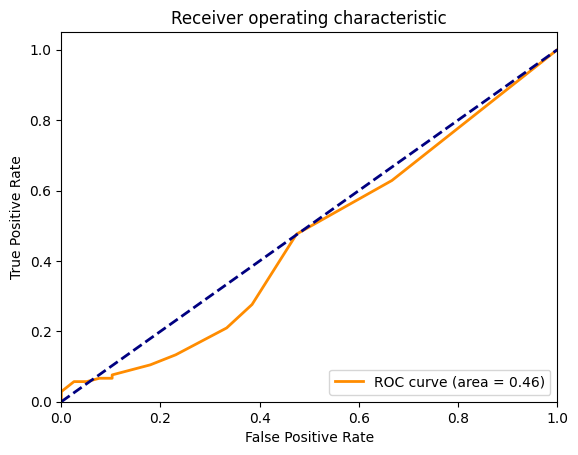

min bootstrapping aucroc:
0.32211538461538464
max bootstrapping aucroc:
0.5818149124910094
p_onesided = 0

Target_AUC = 0
p_twosided_1 = 0
p_twosided_2 = 1
p_twosided = 0
boots_mean_AUCROC =
0.4613526416336554(0.3799397590361446,0.5455555555555556)

...END AUCROC

FINISH


FINISH ALL



In [34]:
# MAIN CODE

# ! check the threshold hypothesis number

'''
for Sex in ['both', 'boys', 'girls']:
    for Input_data in ['ysr', 'cbcl']: #cbcl
        for Reporter in ['parent', 'child']: # child
            for Hypothesis in ['1','2a','2b']:
                if Input_data == 'cbcl':
                    for Wave in ['baseline', 'optimal']:'''
for Sex in ['both']:
    for Input_data in ['cbcl']: #cbcl
        for Reporter in ['child']: # child
            for Hypothesis in ['2b']:
                if Input_data == 'cbcl':
                    for Wave in ['baseline']:
                        print('\nInput Data: %s' % Input_data)
                        print('Wave: %s' % Wave)
                        print('Ksads Reporter: %s' % Reporter)
                        print('Hypothesis: %s' % Hypothesis)
                        print('Sex: %s' % Sex)
                        print('\n')
                        data_ksads = load_ksads(path_to_data, reporter = Reporter, wave = Wave, do_print = False)
                        data_input = load_cbcl(path_to_data, wave = Wave)
                        data_merged = merge_my_data(data_input, data_ksads)     
                        data_ready = preprocess_data(data_merged, percent_positives = 10, hypothesis = Hypothesis, sex = Sex)
                        print('\nFINISHED DATA PREP\n')
                        # STARTING ANALYSIS
                        print('\nSTART ANALYSIS\n')
                        print('\nInput Data: %s' % Input_data)
                        print('Wave: %s' % Wave)
                        print('Ksads Reporter: %s' % Reporter)
                        print('Hypothesis: %s' % Hypothesis) 
                        print('Sex: %s' % Sex)
                        if Hypothesis in ['1', '2a']:
                            Target_auc = 0.8 # [TODO] NEED TO DOUBLE CHECK THIS WITH SAMPLE SIZE ESTIMATION ETC
                        elif Hypothesis == '2b':
                            Target_auc = 0.7 # [TODO] NEED TO DOUBLE CHECK THIS WITH SAMPLE SIZE ESTIMATION ETC
                        fig_file_name = 'ABCD_'+Input_data+'_'+Hypothesis+'_'+Reporter+'_'+Wave+'_'+Sex
                        try:
                            y_true,y_measure = run_aucroc_and_plot(data_ready, 
                                                                path_to_save_plots='../plotting/plot_data/', 
                                                                name_to_save=fig_file_name, 
                                                                mymeasure = Input_data, 
                                                                hypothesis = Hypothesis,
                                                                nboots=100, 
                                                                target_auc=Target_auc)
                        except:
                            pass
                        print('\nFINISH\n')
    
                elif Input_data == 'ysr':
                    Wave = 'optimal'
                    print('\nInput Data: %s' % Input_data)
                    print('Wave: Always optimal')
                    print('Ksads Reporter: %s' % Reporter)
                    print('Hypothesis: %s' % Hypothesis)
                    print('Sex: %s' % Sex)
                    print('\n')
                    data_ksads = load_ksads(path_to_data, reporter = Reporter, wave = Wave, do_print = False)
                    data_input = load_ysr(path_to_data, wave = Wave)
                    data_merged = merge_my_data(data_input, data_ksads)     
                    data_ready = preprocess_data(data_merged, percent_positives = 10, hypothesis = Hypothesis, sex = Sex)
                    print('\nFINISHED DATA PREP\n')
                    # STARTING ANALYSIS
                    print('\nSTART ANALYSIS\n')
                    print('\nInput Data: %s' % Input_data)
                    print('Wave: %s' % Wave)
                    print('Ksads Reporter: %s' % Reporter)
                    print('Hypothesis: %s' % Hypothesis)
                    print('Sex: %s' % Sex)
                    if Hypothesis in ['1', '2a']:
                        Target_auc = 0.8 # [TODO] NEED TO DOUBLE CHECK THIS WITH SAMPLE SIZE ESTIMATION ETC
                    elif Hypothesis == '2b':
                        Target_auc = 0.7 # [TODO] NEED TO DOUBLE CHECK THIS WITH SAMPLE SIZE ESTIMATION ETC
                    fig_file_name = 'ABCD_'+Input_data+'_'+Hypothesis+'_'+Reporter+'_'+Wave+'_'+Sex
                    try:
                        y_true,y_measure, b_AUCROC, q25, q75 = run_aucroc_and_plot(data_ready, 
                                                                path_to_save_plots='../plotting/plot_data/', 
                                                                name_to_save=fig_file_name, 
                                                                mymeasure = Input_data, 
                                                                hypothesis = Hypothesis,
                                                                nboots=100, 
                                                                target_auc=Target_auc)
                    except:
                        pass
                    print('\nFINISH\n')
                else: 
                    print('\nWRONG INPUT DATA')

print('\nFINISH ALL\n')

In [30]:
#check what we loaded
d = pd.read_csv('/Users/zeleninam2/Documents/projects/cbcl_ksads_work/revision_2023/results/my_subsample_parent_H1.csv', sep=',', header=0, low_memory=False)
d.head()

ksads_DEPRESSION  ksads_ANXIETY  ksads_ADHD  ksads_ADHD_OR_ANXIETY  \
0                 0              0           0                      0   
1                 0              0           0                      0   
2                 0              0           1                      1   
3                 1              1           0                      1   
4                 0              0           0                      0   

   ksads_DEPyes_ANXADHDno  ksads_DEPno_ANXADHDyes  input_measure  demo_sex_v2  \
0                       0                       0            0.0          1.0   
1                       0                       0            0.0          1.0   
2                       0                       1            1.0          2.0   
3                       0                       0            4.0          2.0   
4                       0                       0            1.0          1.0   

   demo_brthdat_v2  
0              9.0  
1              9.0  
2              9.0  
3              9.0  
4             10.0

In [26]:
path_to_demo_data = path_to_data+'/abcd-data-release-5.1/core/abcd-general/abcd_p_demo.csv'
d = pd.read_csv(path_to_demo_data, sep=',', header=0, low_memory=False)
d.head()
for c in d.columns:
    print(c)


src_subject_id
eventname
demoi_p_select_language___1
demo_prim
demo_brthdat_v2
demo_ed_v2
demo_adopt_agex_v2
demo_adopt_agex_v2_bl_dk
demo_sex_v2
demo_gender_id_v2
demo_race_a_p___10
demo_race_a_p___11
demo_race_a_p___12
demo_race_a_p___13
demo_race_a_p___14
demo_race_a_p___15
demo_race_a_p___16
demo_race_a_p___17
demo_race_a_p___18
demo_race_a_p___19
demo_race_a_p___20
demo_race_a_p___21
demo_race_a_p___22
demo_race_a_p___23
demo_race_a_p___24
demo_race_a_p___25
demo_race_a_p___77
demo_race_a_p___99
demo_ethn_v2
demo_ethn2_v2
demo_origin_v2
demo_years_us_v2
demo_years_us_v2_dk
demo_relig_v2
demo_prnt_age_v2
demo_prnt_age_v2_bl_refuse
demo_prnt_gender_id_v2
demo_prnt_race_a_v2___10
demo_prnt_race_a_v2___11
demo_prnt_race_a_v2___12
demo_prnt_race_a_v2___13
demo_prnt_race_a_v2___14
demo_prnt_race_a_v2___15
demo_prnt_race_a_v2___16
demo_prnt_race_a_v2___17
demo_prnt_race_a_v2___18
demo_prnt_race_a_v2___19
demo_prnt_race_a_v2___20
demo_prnt_race_a_v2___21
demo_prnt_race_a_v2___22
demo_prnt

# NOT MAIN CODE

BEGIN LOADING KSADS...

shape at loading, baseline only
(11812, 1912)

how many nans:
ksads_1_840_t
0.0      11742
1.0         66
888.0        1
Name: count, dtype: int64
ksads_1_841_t
0.0      11782
1.0         26
888.0        1
Name: count, dtype: int64
ksads_1_843_t
0.0      11808
888.0        1
Name: count, dtype: int64
ksads_1_844_t
0.0      11808
888.0        1
Name: count, dtype: int64
ksads_1_846_t
0.0      11780
1.0         28
888.0        1
Name: count, dtype: int64
ksads_14_856_t
555.0    11812
Name: count, dtype: int64
ksads_14_855_t
555.0    11812
Name: count, dtype: int64
ksads_14_853_t
555.0    11812
Name: count, dtype: int64
ksads_5_906_t
555.0    11812
Name: count, dtype: int64
ksads_5_857_t
555.0    11812
Name: count, dtype: int64
ksads_6_908_t
555.0    11812
Name: count, dtype: int64
ksads_7_861_t
555.0    11812
Name: count, dtype: int64
ksads_7_909_t
555.0    11812
Name: count, dtype: int64
ksads_8_863_t
0.0    11748
1.0       48
Name: count, dtype: int64
ksads_8_91

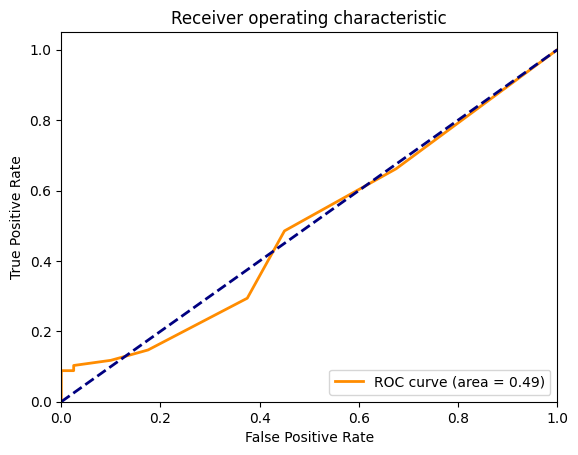

min bootstrapping aucroc:
0.2909980430528376
max bootstrapping aucroc:
0.6867283950617284
p_onesided = 0

Target_AUC = 0
p_twosided_1 = 0
p_twosided_2 = 1
p_twosided = 0
boots_mean_AUCROC =
0.49166232522516423(0.3831842576028623,0.6022376543209877)

...END AUCROC


In [37]:
# use this code if need to run for some specific parameters (and not in a loop)
# WITH BEST DIAGNOSTIC THRESHOLD AND EUCLIDIAN!

Input_data = 'cbcl'
Wave = 'baseline'
Sex = 'boys'

Reporter = 'child'
Hypothesis = '2b'

data_ksads = load_ksads(path_to_data, reporter = Reporter, wave = Wave, do_print = True)
if Input_data == 'cbcl':
    data_input = load_cbcl(path_to_data, wave = Wave)
elif Input_data == 'ysr':
    data_input = load_ysr(path_to_data, wave = Wave)
data_merged = merge_my_data(data_input, data_ksads)     
data_ready = preprocess_data(data_merged, percent_positives = 10, hypothesis = Hypothesis, sex = Sex, do_print = True)

# STARTING ANALYSIS
print('\nSTART ANALYSIS\n')
print('\nInput Data: %s' % Input_data)
print('Wave: %s' % Wave)
print('Ksads Reporter: %s' % Reporter)
print('Hypothesis: %s' % Hypothesis) 
print('Sex: %s' % Sex)
if Hypothesis in ['1', '2a']:
    Target_auc = 0.8 # [TODO] NEED TO DOUBLE CHECK THIS WITH SAMPLE SIZE ESTIMATION ETC
elif Hypothesis == '2b':
    Target_auc = 0.8 # [TODO] NEED TO DOUBLE CHECK THIS WITH SAMPLE SIZE ESTIMATION ETC
fig_file_name = 'ABCD_'+Input_data+'_'+Hypothesis+'_'+Reporter+'_'+Wave+'_'+Sex
y_true,y_measure, b_AUCROC, q25, q75, p1, p2 = run_aucroc_and_plot(data_ready, 
                                        path_to_save_plots='../plotting/plot_data/', 
                                        name_to_save=fig_file_name, 
                                        mymeasure = Input_data, 
                                        hypothesis = Hypothesis,
                                        nboots=100, 
                                        target_auc=Target_auc)

In [109]:
def predict_y(y_cbcl, threshold):
    y_score = []
    for item in y_cbcl:
        if item >= threshold:
            y_score.append(1)
        else:
            y_score.append(0)
    return y_score

In [110]:
m1 = int(min(y_measure))
m2 = int(max(y_measure))+1

In [111]:
# Create a dataframe for all data for thresholds and associated fpr, tpr, tp, tn, fp, fn

# and also euclidian distance
# --> tpr - y axis 
# --> fpr - x axis 
# We want to calculate an Euclidian distance to (0,1) for each point on the ROC curve and pick the point where that is minimized. 

## dist = sqrt((x2 - x1)^2 + (y2 - y1)^2) 
## dist = sqrt(square(x2 - x1) + square(y2 - y1)) 

# I will create the df from a list of lists

# first initiate the lists

all_roc_auc = []
all_fpr = []
all_tpr = []
all_tn = []
all_fp = []
all_fn = []
all_tp = []
all_thresholds = []
all_euclidian = []

# Point to calculate the Euclidian distance with - (0, 1)
optimal_performance = np.array((0, 1))

# now iterate through thesholds, calculate the values of interest, update the lists

for threshold in range (m1,m2):
    # predict diagnoses with the given threshold
    y_score = predict_y(y_measure, threshold)
    # calculate fp, fn, tp, tn, aucroc
    tn, fp, fn, tp = confusion_matrix(y_true, y_score).ravel()
    fpr = fp/(fp+tn)
    tpr = tp/(tp+fn)
    # calculate euclidian
    fpr_tpr_datapoint = np.array((fpr, tpr))
    sum_sq = np.sum(np.square(optimal_performance - fpr_tpr_datapoint))
    euclidian = np.sqrt(sum_sq)
    
    # update all lists
    all_fpr.append(fpr)
    all_tpr.append(tpr)
    all_tn.append(tn)
    all_fp.append(fp)
    all_fn.append(fn)
    all_tp.append(tp)
    all_thresholds.append(threshold)
    all_euclidian.append(euclidian)


# make a dataframe out of lists

conf_matrices_data = pd.DataFrame(list(zip(all_thresholds, all_euclidian, all_fpr, all_tpr, all_tp, all_tn, all_fp, all_fn)),
               columns =['threshold', 'Euclidian', 'FPR', 'TPR', 'TP', 'TN', 'FP', 'FN'])

conf_matrices_data

threshold  Euclidian       FPR       TPR   TP  TN  FP   FN
0           0   1.000000  1.000000  1.000000  105   0  78    0
1           1   0.763154  0.666667  0.628571   66  26  52   39
2           2   0.706677  0.474359  0.476190   50  41  37   55
3           3   0.819652  0.384615  0.276190   29  48  30   76
4           4   0.857883  0.333333  0.209524   22  52  26   83
5           5   0.896864  0.230769  0.133333   14  60  18   91
6           6   0.913054  0.179487  0.104762   11  64  14   94
7           7   0.929486  0.102564  0.076190    8  70   8   97
8           8   0.938952  0.102564  0.066667    7  70   8   98
9           9   0.936498  0.076923  0.066667    7  72   6   98
10         10   0.944251  0.051282  0.057143    6  74   4   99
11         11   0.943206  0.025641  0.057143    6  76   2   99
12         12   0.971429  0.000000  0.028571    3  78   0  102
13         13   0.980952  0.000000  0.019048    2  78   0  103
14         14   0.980952  0.000000  0.019048    2  78   0  103
15         15   0.990476  0.000000  0.009524    1  78   0  104
16         16   0.990476  0.000000  0.009524    1  78   0  104
17         17   0.990476  0.000000  0.009524    1  78   0  104
18         18   0.990476  0.000000  0.009524    1  78   0  104
19         19   0.990476  0.000000  0.009524    1  78   0  104

In [112]:
conf_matrices_data[['Euclidian']].idxmin()

Euclidian    2
dtype: int64

In [113]:
conf_matrices_data.loc[2]

threshold     2.000000
Euclidian     0.706677
FPR           0.474359
TPR           0.476190
TP           50.000000
TN           41.000000
FP           37.000000
FN           55.000000
Name: 2, dtype: float64

# ANXDEP and WITHDEP

BEGIN LOADING KSADS...

...FINISH LOADING KSADS
BEGIN LOADING CBCL, anx/dep or with/dep...
...FINISH LOADING CBCL, anx/dep or with/dep...
BEGIN MERGING...
...FINISH MERGING
BEGIN PREPROCESSING...

Last check of missing data. Non-null rows = 0

Check that positives and negatives dont overlap
Index([], dtype='object', name='src_subject_id')
FINAL Number of positives in the data n=30
Number of negatives in the data (before subsampling) n=6154
Overall sample size (before subsampling) n=6184
FINAL Number of negatives in the data (after subsampling) n=270
FINAL Overall sample size (before subsampling) n=300

...END PREPROCESSING

START ANALYSIS


Input Data: CBCL anx/dex or with/dep
Scale: anxiousdep
Wave: baseline
Ksads Reporter: parent
Hypothesis: 1
Sex: both
BEGIN AUCROC...

Single AUCROC score without bootstrapping:
0.923395061728395


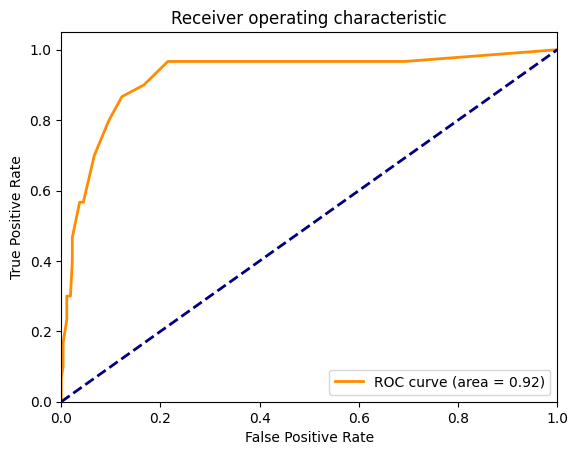

min bootstrapping aucroc:
0.7960402799112476
max bootstrapping aucroc:
0.9773544800523218
p_onesided = 0
p_twosided = 0
boots_mean_AUCROC =
0.9227520043136127(0.8563430461890825,0.9664762126865671)

...END AUCROC
BEGIN LOADING KSADS...

...FINISH LOADING KSADS
BEGIN LOADING CBCL, anx/dep or with/dep...
...FINISH LOADING CBCL, anx/dep or with/dep...
BEGIN MERGING...
...FINISH MERGING
BEGIN PREPROCESSING...

Last check of missing data. Non-null rows = 0

Check that positives and negatives dont overlap
Index([], dtype='object', name='src_subject_id')
FINAL Number of positives in the data n=30
Number of negatives in the data (before subsampling) n=999
Overall sample size (before subsampling) n=1029
FINAL Number of negatives in the data (after subsampling) n=270
FINAL Overall sample size (before subsampling) n=300

...END PREPROCESSING

START ANALYSIS


Input Data: CBCL anx/dex or with/dep
Scale: anxiousdep
Wave: baseline
Ksads Reporter: parent
Hypothesis: 2a
Sex: both
BEGIN AUCROC...

Sing

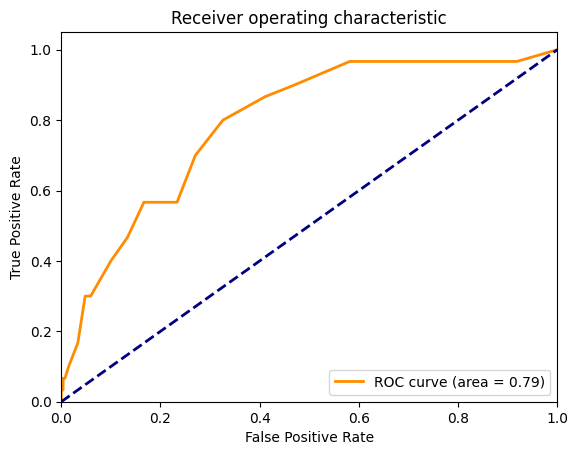

min bootstrapping aucroc:
0.6588624506934725
max bootstrapping aucroc:
0.9017901234567901
p_onesided = 0
p_twosided = 0
boots_mean_AUCROC =
0.7936405047231482(0.7190910181076868,0.868812826059295)

...END AUCROC
BEGIN LOADING KSADS...

...FINISH LOADING KSADS
BEGIN LOADING CBCL, anx/dep or with/dep...
...FINISH LOADING CBCL, anx/dep or with/dep...
BEGIN MERGING...
...FINISH MERGING
BEGIN PREPROCESSING...

Last check of missing data. Non-null rows = 0

Check that positives and negatives dont overlap
Index([], dtype='object', name='src_subject_id')
FINAL Number of positives in the data n=11
Number of negatives in the data (before subsampling) n=999
Overall sample size (before subsampling) n=1010
FINAL Number of negatives in the data (after subsampling) n=99
FINAL Overall sample size (before subsampling) n=110

...END PREPROCESSING

START ANALYSIS


Input Data: CBCL anx/dex or with/dep
Scale: anxiousdep
Wave: baseline
Ksads Reporter: parent
Hypothesis: 2b
Sex: both
BEGIN AUCROC...

Single

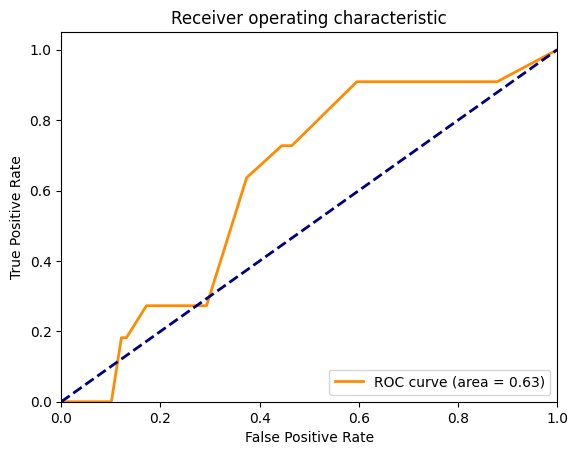

min bootstrapping aucroc:
0.3795
max bootstrapping aucroc:
0.8608815426997245
p_onesided = 0
p_twosided = 0
boots_mean_AUCROC =
0.6275266629559707(0.45399999999999996,0.778)

...END AUCROC
BEGIN LOADING KSADS...

...FINISH LOADING KSADS
BEGIN LOADING CBCL, anx/dep or with/dep...
...FINISH LOADING CBCL, anx/dep or with/dep...
BEGIN MERGING...
...FINISH MERGING
BEGIN PREPROCESSING...

Last check of missing data. Non-null rows = 0

Check that positives and negatives dont overlap
Index([], dtype='object', name='src_subject_id')
FINAL Number of positives in the data n=30
Number of negatives in the data (before subsampling) n=6154
Overall sample size (before subsampling) n=6184
FINAL Number of negatives in the data (after subsampling) n=270
FINAL Overall sample size (before subsampling) n=300
demo_sex_v2
2.0    153
1.0    147
Name: count, dtype: int64
Positive girls in sample = 19
Positive boys in sample = 11

...END PREPROCESSING

START ANALYSIS


Input Data: CBCL anx/dex or with/dep
Scale:

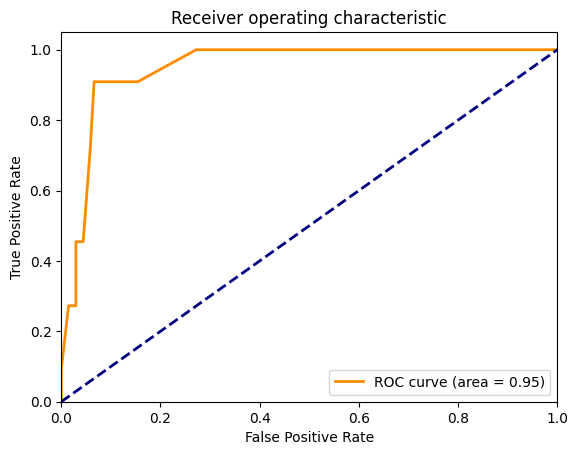

min bootstrapping aucroc:
0.8399280575539568
max bootstrapping aucroc:
0.9941546762589928
p_onesided = 1
p_twosided = 0
boots_mean_AUCROC =
0.9483345980530747(0.8988309352517986,0.9847122302158273)

...END AUCROC
BEGIN LOADING KSADS...

...FINISH LOADING KSADS
BEGIN LOADING CBCL, anx/dep or with/dep...
...FINISH LOADING CBCL, anx/dep or with/dep...
BEGIN MERGING...
...FINISH MERGING
BEGIN PREPROCESSING...

Last check of missing data. Non-null rows = 0

Check that positives and negatives dont overlap
Index([], dtype='object', name='src_subject_id')
FINAL Number of positives in the data n=30
Number of negatives in the data (before subsampling) n=999
Overall sample size (before subsampling) n=1029
FINAL Number of negatives in the data (after subsampling) n=270
FINAL Overall sample size (before subsampling) n=300
demo_sex_v2
1.0    174
2.0    125
3.0      1
Name: count, dtype: int64
Positive girls in sample = 19
Positive boys in sample = 11

...END PREPROCESSING

START ANALYSIS


Input Dat

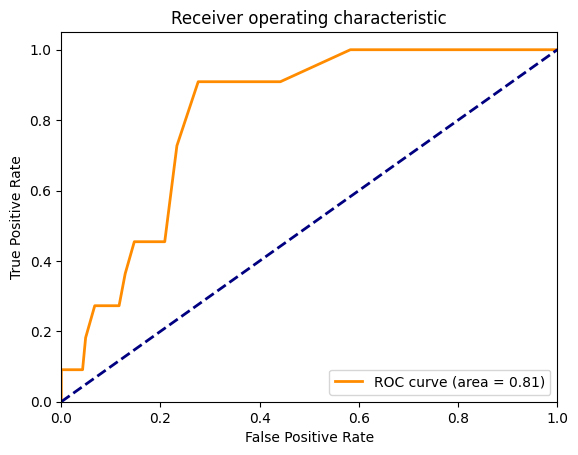

min bootstrapping aucroc:
0.641077441077441
max bootstrapping aucroc:
0.950301204819277
p_onesided = 0
p_twosided = 0
boots_mean_AUCROC =
0.8116381384215496(0.7060267857142857,0.8991769547325102)

...END AUCROC
BEGIN LOADING KSADS...

...FINISH LOADING KSADS
BEGIN LOADING CBCL, anx/dep or with/dep...
...FINISH LOADING CBCL, anx/dep or with/dep...
BEGIN MERGING...
...FINISH MERGING
BEGIN PREPROCESSING...

Last check of missing data. Non-null rows = 0

Check that positives and negatives dont overlap
Index([], dtype='object', name='src_subject_id')
FINAL Number of positives in the data n=11
Number of negatives in the data (before subsampling) n=999
Overall sample size (before subsampling) n=1010
FINAL Number of negatives in the data (after subsampling) n=99
FINAL Overall sample size (before subsampling) n=110
demo_sex_v2
1.0    61
2.0    48
3.0     1
Name: count, dtype: int64
Positive girls in sample = 8
Positive boys in sample = 3

...END PREPROCESSING

START ANALYSIS


Input Data: CBCL 

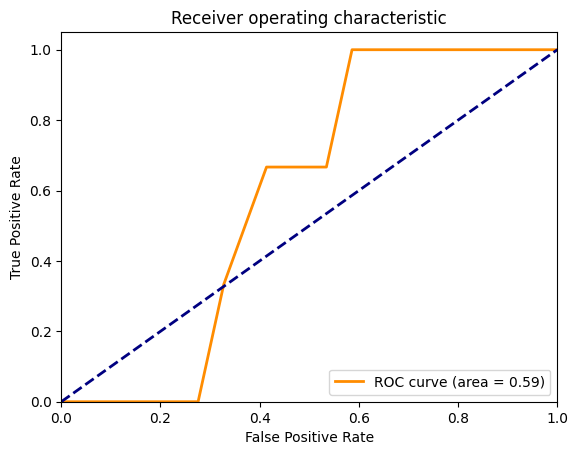

BEGIN LOADING KSADS...

...FINISH LOADING KSADS
BEGIN LOADING CBCL, anx/dep or with/dep...
...FINISH LOADING CBCL, anx/dep or with/dep...
BEGIN MERGING...
...FINISH MERGING
BEGIN PREPROCESSING...

Last check of missing data. Non-null rows = 0

Check that positives and negatives dont overlap
Index([], dtype='object', name='src_subject_id')
FINAL Number of positives in the data n=30
Number of negatives in the data (before subsampling) n=6154
Overall sample size (before subsampling) n=6184
FINAL Number of negatives in the data (after subsampling) n=270
FINAL Overall sample size (before subsampling) n=300
demo_sex_v2
1.0    157
2.0    142
3.0      1
Name: count, dtype: int64
Positive girls in sample = 19
Positive boys in sample = 11

...END PREPROCESSING

START ANALYSIS


Input Data: CBCL anx/dex or with/dep
Scale: anxiousdep
Wave: baseline
Ksads Reporter: parent
Hypothesis: 1
Sex: girls
BEGIN AUCROC...

Single AUCROC score without bootstrapping:
0.897571606475716


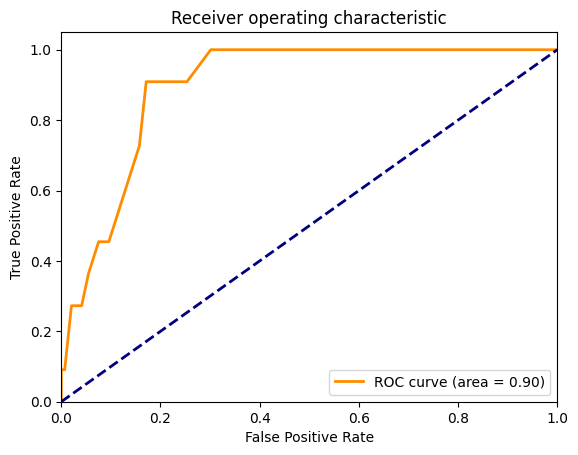

min bootstrapping aucroc:
0.7588300220750551
max bootstrapping aucroc:
0.9787581699346405
p_onesided = 0
p_twosided = 0
boots_mean_AUCROC =
0.8968381602179144(0.8250311332503113,0.9506802721088435)

...END AUCROC
BEGIN LOADING KSADS...

...FINISH LOADING KSADS
BEGIN LOADING CBCL, anx/dep or with/dep...
...FINISH LOADING CBCL, anx/dep or with/dep...
BEGIN MERGING...
...FINISH MERGING
BEGIN PREPROCESSING...

Last check of missing data. Non-null rows = 0

Check that positives and negatives dont overlap
Index([], dtype='object', name='src_subject_id')
FINAL Number of positives in the data n=30
Number of negatives in the data (before subsampling) n=999
Overall sample size (before subsampling) n=1029
FINAL Number of negatives in the data (after subsampling) n=270
FINAL Overall sample size (before subsampling) n=300
demo_sex_v2
1.0    176
2.0    123
3.0      1
Name: count, dtype: int64
Positive girls in sample = 19
Positive boys in sample = 11

...END PREPROCESSING

START ANALYSIS


Input Dat

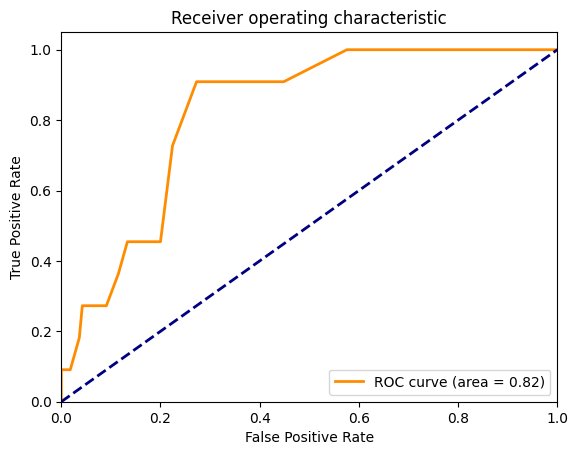

min bootstrapping aucroc:
0.6566220238095238
max bootstrapping aucroc:
0.9459002535925612
p_onesided = 0
p_twosided = 0
boots_mean_AUCROC =
0.8242613612157713(0.7304216867469879,0.911665257819104)

...END AUCROC
BEGIN LOADING KSADS...

...FINISH LOADING KSADS
BEGIN LOADING CBCL, anx/dep or with/dep...
...FINISH LOADING CBCL, anx/dep or with/dep...
BEGIN MERGING...
...FINISH MERGING
BEGIN PREPROCESSING...

Last check of missing data. Non-null rows = 0

Check that positives and negatives dont overlap
Index([], dtype='object', name='src_subject_id')
FINAL Number of positives in the data n=11
Number of negatives in the data (before subsampling) n=999
Overall sample size (before subsampling) n=1010
FINAL Number of negatives in the data (after subsampling) n=99
FINAL Overall sample size (before subsampling) n=110
demo_sex_v2
1.0    64
2.0    46
Name: count, dtype: int64
Positive girls in sample = 8
Positive boys in sample = 3

...END PREPROCESSING

START ANALYSIS


Input Data: CBCL anx/dex o

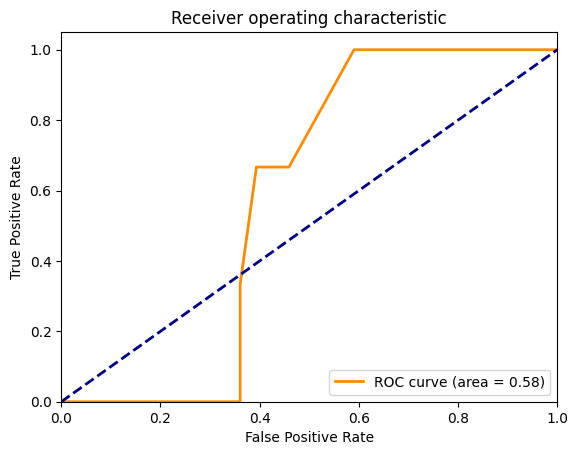

BEGIN LOADING KSADS...

...FINISH LOADING KSADS
BEGIN LOADING CBCL, anx/dep or with/dep...
...FINISH LOADING CBCL, anx/dep or with/dep...
BEGIN MERGING...
...FINISH MERGING
BEGIN PREPROCESSING...

Last check of missing data. Non-null rows = 0

Check that positives and negatives dont overlap
Index([], dtype='object', name='src_subject_id')
FINAL Number of positives in the data n=30
Number of negatives in the data (before subsampling) n=6154
Overall sample size (before subsampling) n=6184
FINAL Number of negatives in the data (after subsampling) n=270
FINAL Overall sample size (before subsampling) n=300

...END PREPROCESSING

START ANALYSIS


Input Data: CBCL anx/dex or with/dep
Scale: withdrawndep
Wave: baseline
Ksads Reporter: parent
Hypothesis: 1
Sex: both
BEGIN AUCROC...

Single AUCROC score without bootstrapping:
0.8977777777777778


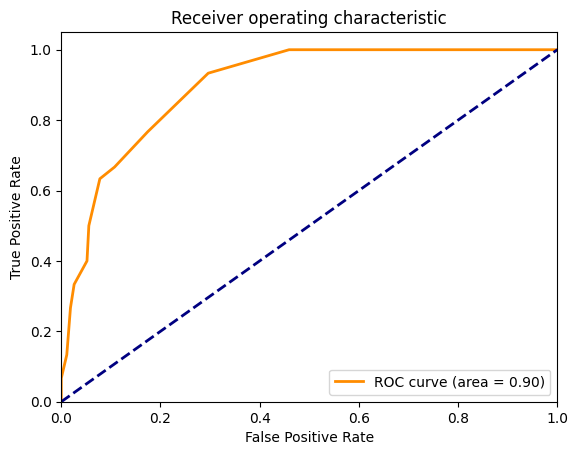

min bootstrapping aucroc:
0.8183453237410072
max bootstrapping aucroc:
0.9615283613445378
p_onesided = 1
p_twosided = 0
boots_mean_AUCROC =
0.8982977190556711(0.8525606469002696,0.9390317396544797)

...END AUCROC
BEGIN LOADING KSADS...

...FINISH LOADING KSADS
BEGIN LOADING CBCL, anx/dep or with/dep...
...FINISH LOADING CBCL, anx/dep or with/dep...
BEGIN MERGING...
...FINISH MERGING
BEGIN PREPROCESSING...

Last check of missing data. Non-null rows = 0

Check that positives and negatives dont overlap
Index([], dtype='object', name='src_subject_id')
FINAL Number of positives in the data n=30
Number of negatives in the data (before subsampling) n=999
Overall sample size (before subsampling) n=1029
FINAL Number of negatives in the data (after subsampling) n=270
FINAL Overall sample size (before subsampling) n=300

...END PREPROCESSING

START ANALYSIS


Input Data: CBCL anx/dex or with/dep
Scale: withdrawndep
Wave: baseline
Ksads Reporter: parent
Hypothesis: 2a
Sex: both
BEGIN AUCROC...

Si

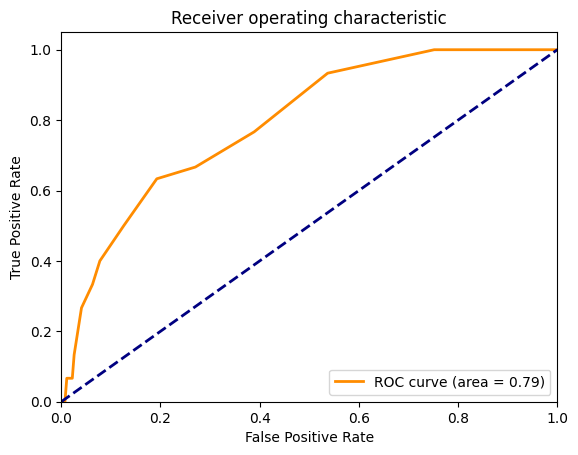

min bootstrapping aucroc:
0.6680357142857143
max bootstrapping aucroc:
0.9204306722689076
p_onesided = 0
p_twosided = 0
boots_mean_AUCROC =
0.7927643741927661(0.7102153361344539,0.8655951712521056)

...END AUCROC
BEGIN LOADING KSADS...

...FINISH LOADING KSADS
BEGIN LOADING CBCL, anx/dep or with/dep...
...FINISH LOADING CBCL, anx/dep or with/dep...
BEGIN MERGING...
...FINISH MERGING
BEGIN PREPROCESSING...

Last check of missing data. Non-null rows = 0

Check that positives and negatives dont overlap
Index([], dtype='object', name='src_subject_id')
FINAL Number of positives in the data n=11
Number of negatives in the data (before subsampling) n=999
Overall sample size (before subsampling) n=1010
FINAL Number of negatives in the data (after subsampling) n=99
FINAL Overall sample size (before subsampling) n=110

...END PREPROCESSING

START ANALYSIS


Input Data: CBCL anx/dex or with/dep
Scale: withdrawndep
Wave: baseline
Ksads Reporter: parent
Hypothesis: 2b
Sex: both
BEGIN AUCROC...

Sin

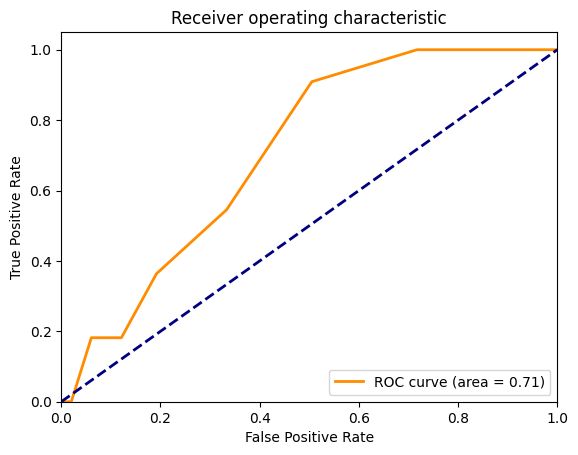

min bootstrapping aucroc:
0.4965
max bootstrapping aucroc:
0.9076190476190477
p_onesided = 0
p_twosided = 0
boots_mean_AUCROC =
0.7053265116003651(0.5825,0.8205128205128205)

...END AUCROC
BEGIN LOADING KSADS...

...FINISH LOADING KSADS
BEGIN LOADING CBCL, anx/dep or with/dep...
...FINISH LOADING CBCL, anx/dep or with/dep...
BEGIN MERGING...
...FINISH MERGING
BEGIN PREPROCESSING...

Last check of missing data. Non-null rows = 0

Check that positives and negatives dont overlap
Index([], dtype='object', name='src_subject_id')
FINAL Number of positives in the data n=30
Number of negatives in the data (before subsampling) n=6154
Overall sample size (before subsampling) n=6184
FINAL Number of negatives in the data (after subsampling) n=270
FINAL Overall sample size (before subsampling) n=300
demo_sex_v2
2.0    157
1.0    143
Name: count, dtype: int64
Positive girls in sample = 19
Positive boys in sample = 11

...END PREPROCESSING

START ANALYSIS


Input Data: CBCL anx/dex or with/dep
Scale:

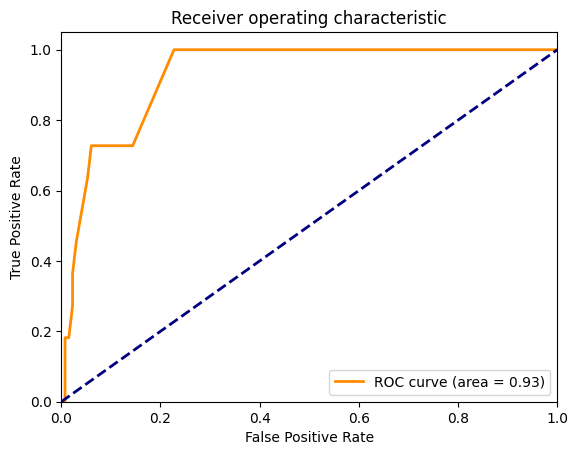

min bootstrapping aucroc:
0.8188405797101449
max bootstrapping aucroc:
0.9920289855072464
p_onesided = 1
p_twosided = 0
boots_mean_AUCROC =
0.9281762744761156(0.8722451790633609,0.9763157894736842)

...END AUCROC
BEGIN LOADING KSADS...

...FINISH LOADING KSADS
BEGIN LOADING CBCL, anx/dep or with/dep...
...FINISH LOADING CBCL, anx/dep or with/dep...
BEGIN MERGING...
...FINISH MERGING
BEGIN PREPROCESSING...

Last check of missing data. Non-null rows = 0

Check that positives and negatives dont overlap
Index([], dtype='object', name='src_subject_id')
FINAL Number of positives in the data n=30
Number of negatives in the data (before subsampling) n=999
Overall sample size (before subsampling) n=1029
FINAL Number of negatives in the data (after subsampling) n=270
FINAL Overall sample size (before subsampling) n=300
demo_sex_v2
1.0    177
2.0    123
Name: count, dtype: int64
Positive girls in sample = 19
Positive boys in sample = 11

...END PREPROCESSING

START ANALYSIS


Input Data: CBCL anx

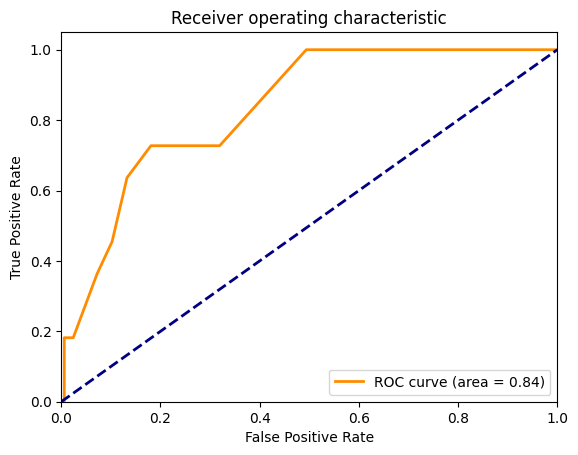

min bootstrapping aucroc:
0.6627906976744186
max bootstrapping aucroc:
1.0
p_onesided = 0
p_twosided = 0
boots_mean_AUCROC =
0.8347448944840289(0.7244949494949495,0.9305555555555556)

...END AUCROC
BEGIN LOADING KSADS...

...FINISH LOADING KSADS
BEGIN LOADING CBCL, anx/dep or with/dep...
...FINISH LOADING CBCL, anx/dep or with/dep...
BEGIN MERGING...
...FINISH MERGING
BEGIN PREPROCESSING...

Last check of missing data. Non-null rows = 0

Check that positives and negatives dont overlap
Index([], dtype='object', name='src_subject_id')
FINAL Number of positives in the data n=11
Number of negatives in the data (before subsampling) n=999
Overall sample size (before subsampling) n=1010
FINAL Number of negatives in the data (after subsampling) n=99
FINAL Overall sample size (before subsampling) n=110
demo_sex_v2
1.0    64
2.0    46
Name: count, dtype: int64
Positive girls in sample = 8
Positive boys in sample = 3

...END PREPROCESSING

START ANALYSIS


Input Data: CBCL anx/dex or with/dep
Sca

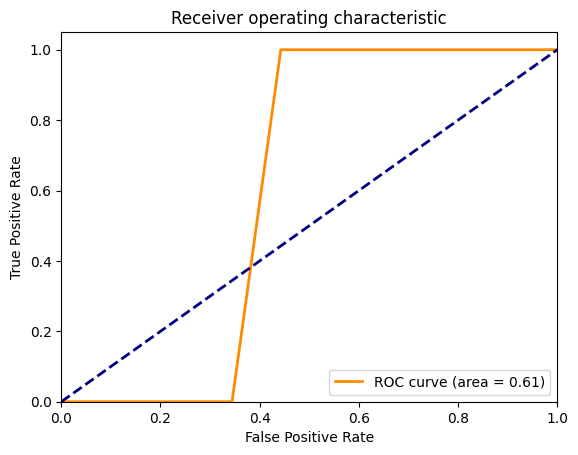

BEGIN LOADING KSADS...

...FINISH LOADING KSADS
BEGIN LOADING CBCL, anx/dep or with/dep...
...FINISH LOADING CBCL, anx/dep or with/dep...
BEGIN MERGING...
...FINISH MERGING
BEGIN PREPROCESSING...

Last check of missing data. Non-null rows = 0

Check that positives and negatives dont overlap
Index([], dtype='object', name='src_subject_id')
FINAL Number of positives in the data n=30
Number of negatives in the data (before subsampling) n=6154
Overall sample size (before subsampling) n=6184
FINAL Number of negatives in the data (after subsampling) n=270
FINAL Overall sample size (before subsampling) n=300
demo_sex_v2
1.0    151
2.0    149
Name: count, dtype: int64
Positive girls in sample = 19
Positive boys in sample = 11

...END PREPROCESSING

START ANALYSIS


Input Data: CBCL anx/dex or with/dep
Scale: withdrawndep
Wave: baseline
Ksads Reporter: parent
Hypothesis: 1
Sex: girls
BEGIN AUCROC...

Single AUCROC score without bootstrapping:
0.9292207792207792


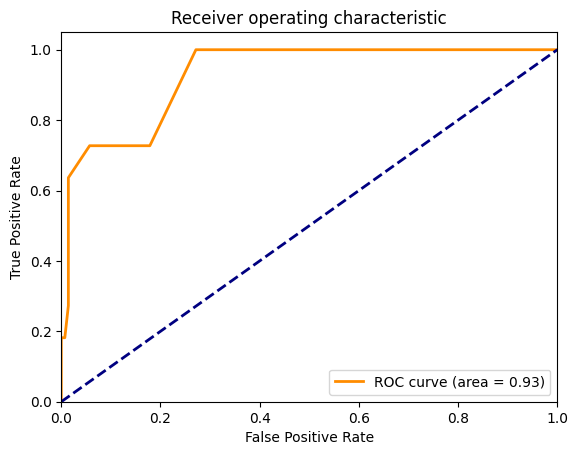

min bootstrapping aucroc:
0.7921626984126985
max bootstrapping aucroc:
1.0
p_onesided = 0
p_twosided = 0
boots_mean_AUCROC =
0.9292206466871741(0.8600649350649351,0.986038961038961)

...END AUCROC
BEGIN LOADING KSADS...

...FINISH LOADING KSADS
BEGIN LOADING CBCL, anx/dep or with/dep...
...FINISH LOADING CBCL, anx/dep or with/dep...
BEGIN MERGING...
...FINISH MERGING
BEGIN PREPROCESSING...

Last check of missing data. Non-null rows = 0

Check that positives and negatives dont overlap
Index([], dtype='object', name='src_subject_id')
FINAL Number of positives in the data n=30
Number of negatives in the data (before subsampling) n=999
Overall sample size (before subsampling) n=1029
FINAL Number of negatives in the data (after subsampling) n=270
FINAL Overall sample size (before subsampling) n=300
demo_sex_v2
1.0    167
2.0    133
Name: count, dtype: int64
Positive girls in sample = 19
Positive boys in sample = 11

...END PREPROCESSING

START ANALYSIS


Input Data: CBCL anx/dex or with/dep

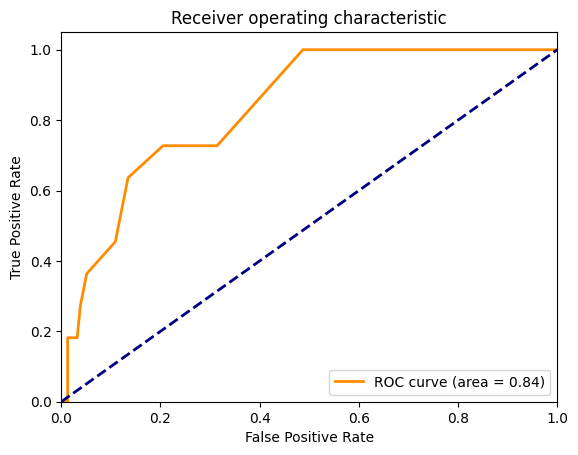

min bootstrapping aucroc:
0.6568322981366459
max bootstrapping aucroc:
0.9617283950617284
p_onesided = 0
p_twosided = 0
boots_mean_AUCROC =
0.8362656270765766(0.7213375796178344,0.9296178343949044)

...END AUCROC
BEGIN LOADING KSADS...

...FINISH LOADING KSADS
BEGIN LOADING CBCL, anx/dep or with/dep...
...FINISH LOADING CBCL, anx/dep or with/dep...
BEGIN MERGING...
...FINISH MERGING
BEGIN PREPROCESSING...

Last check of missing data. Non-null rows = 0

Check that positives and negatives dont overlap
Index([], dtype='object', name='src_subject_id')
FINAL Number of positives in the data n=11
Number of negatives in the data (before subsampling) n=999
Overall sample size (before subsampling) n=1010
FINAL Number of negatives in the data (after subsampling) n=99
FINAL Overall sample size (before subsampling) n=110
demo_sex_v2
1.0    56
2.0    54
Name: count, dtype: int64
Positive girls in sample = 8
Positive boys in sample = 3

...END PREPROCESSING

START ANALYSIS


Input Data: CBCL anx/dex 

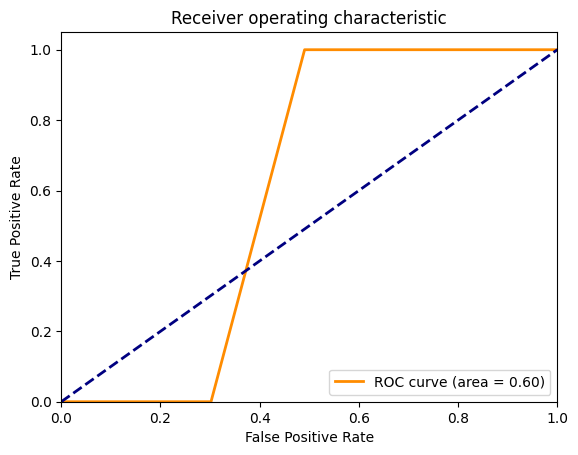

BEGIN LOADING KSADS...

...FINISH LOADING KSADS
BEGIN LOADING CBCL, anx/dep or with/dep...
...FINISH LOADING CBCL, anx/dep or with/dep...
BEGIN MERGING...
...FINISH MERGING
BEGIN PREPROCESSING...

Last check of missing data. Non-null rows = 0

Check that positives and negatives dont overlap
Index([], dtype='object', name='src_subject_id')
FINAL Number of positives in the data n=119
Number of negatives in the data (before subsampling) n=11667
Overall sample size (before subsampling) n=11786
FINAL Number of negatives in the data (after subsampling) n=1071
FINAL Overall sample size (before subsampling) n=1190

...END PREPROCESSING

START ANALYSIS


Input Data: CBCL anx/dex or with/dep
Scale: anxiousdep
Wave: baseline
Ksads Reporter: child
Hypothesis: 1
Sex: both
BEGIN AUCROC...

Single AUCROC score without bootstrapping:
0.6304717965617619


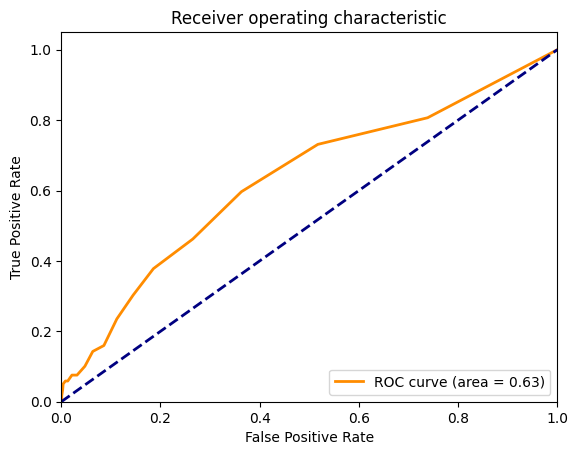

min bootstrapping aucroc:
0.5105788638985006
max bootstrapping aucroc:
0.7512672276702889
p_onesided = 0
p_twosided = 0
boots_mean_AUCROC =
0.629889211634254(0.5732820738516236,0.6857662300134848)

...END AUCROC
BEGIN LOADING KSADS...

...FINISH LOADING KSADS
BEGIN LOADING CBCL, anx/dep or with/dep...
...FINISH LOADING CBCL, anx/dep or with/dep...
BEGIN MERGING...
...FINISH MERGING
BEGIN PREPROCESSING...

Last check of missing data. Non-null rows = 0

Check that positives and negatives dont overlap
Index([], dtype='object', name='src_subject_id')
FINAL Number of positives in the data n=119
Number of negatives in the data (before subsampling) n=78
Overall sample size (before subsampling) n=197
Not enough negative samples to use the desired neg/pos rate. Using all negative samples
FINAL Number of negatives in the data (after subsampling) n=78
FINAL Overall sample size (before subsampling) n=197

...END PREPROCESSING

START ANALYSIS


Input Data: CBCL anx/dex or with/dep
Scale: anxiousdep

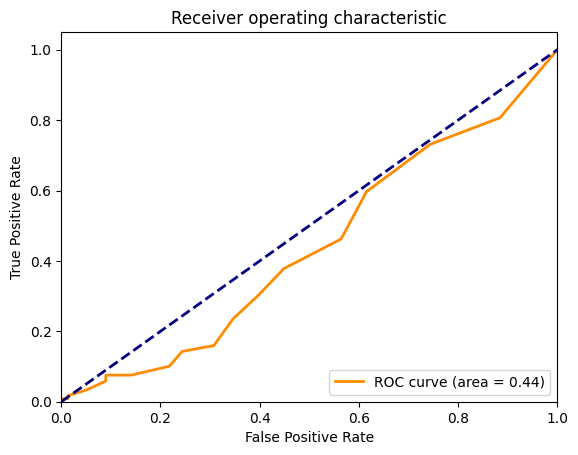

min bootstrapping aucroc:
0.32155116927697913
max bootstrapping aucroc:
0.5730615254951539
p_onesided = 0
p_twosided = 0
boots_mean_AUCROC =
0.44029264277122815(0.35933633295838024,0.5202545068928951)

...END AUCROC
BEGIN LOADING KSADS...

...FINISH LOADING KSADS
BEGIN LOADING CBCL, anx/dep or with/dep...
...FINISH LOADING CBCL, anx/dep or with/dep...
BEGIN MERGING...
...FINISH MERGING
BEGIN PREPROCESSING...

Last check of missing data. Non-null rows = 0

Check that positives and negatives dont overlap
Index([], dtype='object', name='src_subject_id')
FINAL Number of positives in the data n=105
Number of negatives in the data (before subsampling) n=78
Overall sample size (before subsampling) n=183
Not enough negative samples to use the desired neg/pos rate. Using all negative samples
FINAL Number of negatives in the data (after subsampling) n=78
FINAL Overall sample size (before subsampling) n=183

...END PREPROCESSING

START ANALYSIS


Input Data: CBCL anx/dex or with/dep
Scale: anxiou

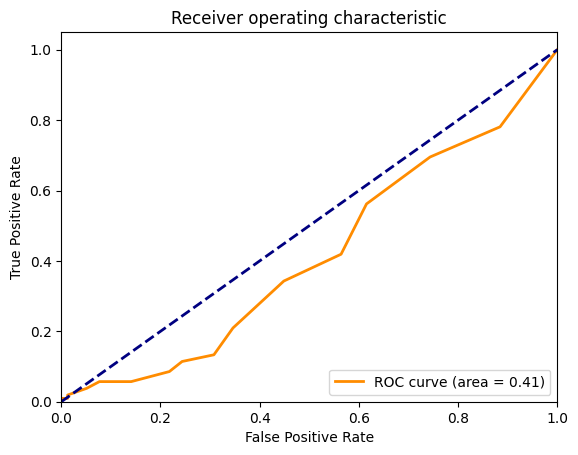

min bootstrapping aucroc:
0.28716046277665996
max bootstrapping aucroc:
0.5636752136752137
p_onesided = 0
p_twosided = 0
boots_mean_AUCROC =
0.4146602842131332(0.3294578313253012,0.5025150905432596)

...END AUCROC
BEGIN LOADING KSADS...

...FINISH LOADING KSADS
BEGIN LOADING CBCL, anx/dep or with/dep...
...FINISH LOADING CBCL, anx/dep or with/dep...
BEGIN MERGING...
...FINISH MERGING
BEGIN PREPROCESSING...

Last check of missing data. Non-null rows = 0

Check that positives and negatives dont overlap
Index([], dtype='object', name='src_subject_id')
FINAL Number of positives in the data n=119
Number of negatives in the data (before subsampling) n=11667
Overall sample size (before subsampling) n=11786
FINAL Number of negatives in the data (after subsampling) n=1071
FINAL Overall sample size (before subsampling) n=1190
demo_sex_v2
1.0    623
2.0    567
Name: count, dtype: int64
Positive girls in sample = 43
Positive boys in sample = 76

...END PREPROCESSING

START ANALYSIS


Input Data: C

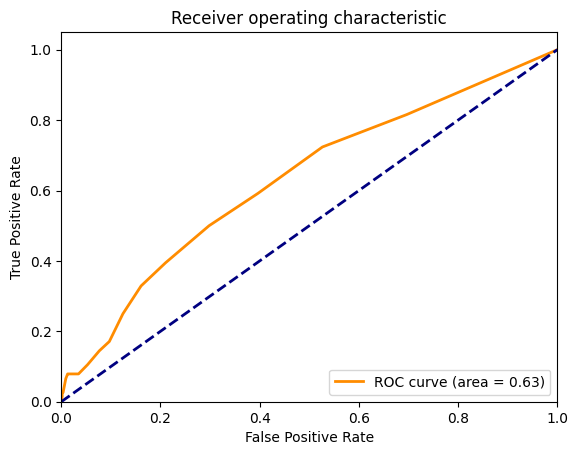

min bootstrapping aucroc:
0.522971065631616
max bootstrapping aucroc:
0.7420617173524151
p_onesided = 0
p_twosided = 0
boots_mean_AUCROC =
0.6270050468763544(0.5632687096101731,0.6905609544885981)

...END AUCROC
BEGIN LOADING KSADS...

...FINISH LOADING KSADS
BEGIN LOADING CBCL, anx/dep or with/dep...
...FINISH LOADING CBCL, anx/dep or with/dep...
BEGIN MERGING...
...FINISH MERGING
BEGIN PREPROCESSING...

Last check of missing data. Non-null rows = 0

Check that positives and negatives dont overlap
Index([], dtype='object', name='src_subject_id')
FINAL Number of positives in the data n=119
Number of negatives in the data (before subsampling) n=78
Overall sample size (before subsampling) n=197
Not enough negative samples to use the desired neg/pos rate. Using all negative samples
FINAL Number of negatives in the data (after subsampling) n=78
FINAL Overall sample size (before subsampling) n=197
demo_sex_v2
1.0    116
2.0     81
Name: count, dtype: int64
Positive girls in sample = 43
Posi

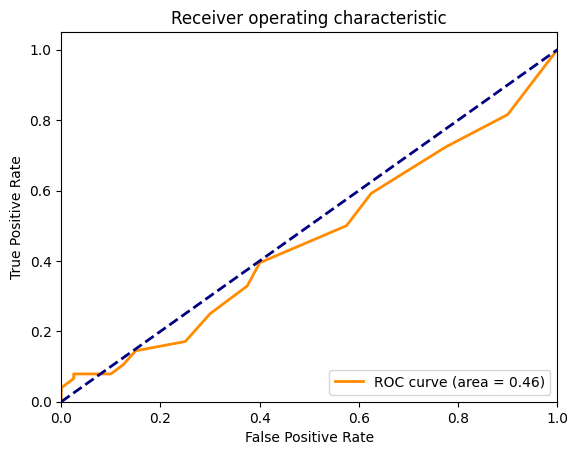

min bootstrapping aucroc:
0.3032639885222382
max bootstrapping aucroc:
0.6271604938271604
p_onesided = 0
p_twosided = 0
boots_mean_AUCROC =
0.46112223637504374(0.3594804318488529,0.5730757711889788)

...END AUCROC
BEGIN LOADING KSADS...

...FINISH LOADING KSADS
BEGIN LOADING CBCL, anx/dep or with/dep...
...FINISH LOADING CBCL, anx/dep or with/dep...
BEGIN MERGING...
...FINISH MERGING
BEGIN PREPROCESSING...

Last check of missing data. Non-null rows = 0

Check that positives and negatives dont overlap
Index([], dtype='object', name='src_subject_id')
FINAL Number of positives in the data n=105
Number of negatives in the data (before subsampling) n=78
Overall sample size (before subsampling) n=183
Not enough negative samples to use the desired neg/pos rate. Using all negative samples
FINAL Number of negatives in the data (after subsampling) n=78
FINAL Overall sample size (before subsampling) n=183
demo_sex_v2
1.0    108
2.0     75
Name: count, dtype: int64
Positive girls in sample = 37
Po

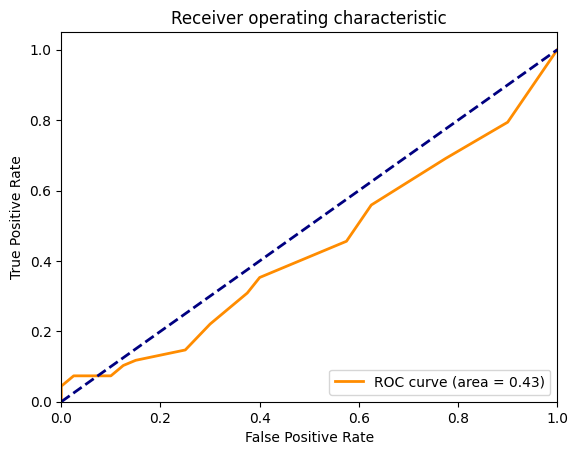

min bootstrapping aucroc:
0.2487279843444227
max bootstrapping aucroc:
0.6046464646464647
p_onesided = 0
p_twosided = 0
boots_mean_AUCROC =
0.4367017286430992(0.32500000000000007,0.5364176885916017)

...END AUCROC
BEGIN LOADING KSADS...

...FINISH LOADING KSADS
BEGIN LOADING CBCL, anx/dep or with/dep...
...FINISH LOADING CBCL, anx/dep or with/dep...
BEGIN MERGING...
...FINISH MERGING
BEGIN PREPROCESSING...

Last check of missing data. Non-null rows = 0

Check that positives and negatives dont overlap
Index([], dtype='object', name='src_subject_id')
FINAL Number of positives in the data n=119
Number of negatives in the data (before subsampling) n=11667
Overall sample size (before subsampling) n=11786
FINAL Number of negatives in the data (after subsampling) n=1071
FINAL Overall sample size (before subsampling) n=1190
demo_sex_v2
1.0    629
2.0    561
Name: count, dtype: int64
Positive girls in sample = 43
Positive boys in sample = 76

...END PREPROCESSING

START ANALYSIS


Input Data: C

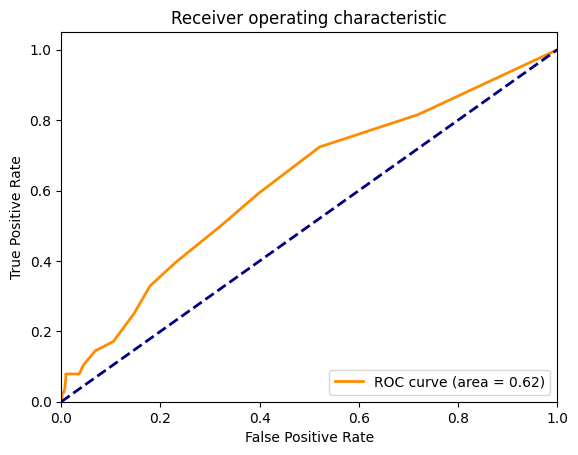

min bootstrapping aucroc:
0.5017418032786884
max bootstrapping aucroc:
0.7207460890493381
p_onesided = 0
p_twosided = 0
boots_mean_AUCROC =
0.619414788398269(0.5475972040192223,0.6883297281248675)

...END AUCROC
BEGIN LOADING KSADS...

...FINISH LOADING KSADS
BEGIN LOADING CBCL, anx/dep or with/dep...
...FINISH LOADING CBCL, anx/dep or with/dep...
BEGIN MERGING...
...FINISH MERGING
BEGIN PREPROCESSING...

Last check of missing data. Non-null rows = 0

Check that positives and negatives dont overlap
Index([], dtype='object', name='src_subject_id')
FINAL Number of positives in the data n=119
Number of negatives in the data (before subsampling) n=78
Overall sample size (before subsampling) n=197
Not enough negative samples to use the desired neg/pos rate. Using all negative samples
FINAL Number of negatives in the data (after subsampling) n=78
FINAL Overall sample size (before subsampling) n=197
demo_sex_v2
1.0    116
2.0     81
Name: count, dtype: int64
Positive girls in sample = 43
Posi

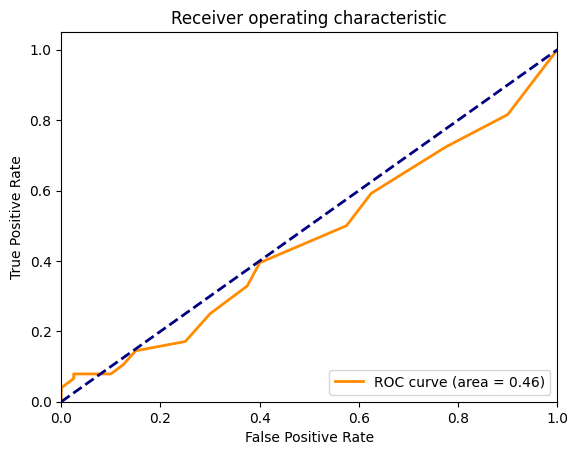

min bootstrapping aucroc:
0.29734576757532283
max bootstrapping aucroc:
0.6506578947368421
p_onesided = 0
p_twosided = 0
boots_mean_AUCROC =
0.46074144799555056(0.354673721340388,0.5733552631578946)

...END AUCROC
BEGIN LOADING KSADS...

...FINISH LOADING KSADS
BEGIN LOADING CBCL, anx/dep or with/dep...
...FINISH LOADING CBCL, anx/dep or with/dep...
BEGIN MERGING...
...FINISH MERGING
BEGIN PREPROCESSING...

Last check of missing data. Non-null rows = 0

Check that positives and negatives dont overlap
Index([], dtype='object', name='src_subject_id')
FINAL Number of positives in the data n=105
Number of negatives in the data (before subsampling) n=78
Overall sample size (before subsampling) n=183
Not enough negative samples to use the desired neg/pos rate. Using all negative samples
FINAL Number of negatives in the data (after subsampling) n=78
FINAL Overall sample size (before subsampling) n=183
demo_sex_v2
1.0    108
2.0     75
Name: count, dtype: int64
Positive girls in sample = 37
Po

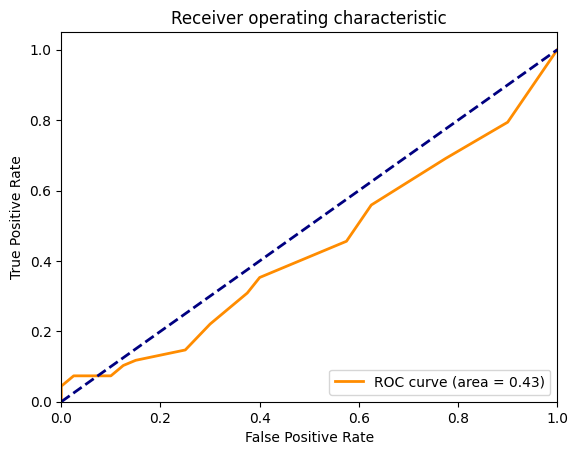

min bootstrapping aucroc:
0.25238473767885533
max bootstrapping aucroc:
0.6123934659090908
p_onesided = 0
p_twosided = 0
boots_mean_AUCROC =
0.43382730158783067(0.32586348684210525,0.5420299965120334)

...END AUCROC
BEGIN LOADING KSADS...

...FINISH LOADING KSADS
BEGIN LOADING CBCL, anx/dep or with/dep...
...FINISH LOADING CBCL, anx/dep or with/dep...
BEGIN MERGING...
...FINISH MERGING
BEGIN PREPROCESSING...

Last check of missing data. Non-null rows = 0

Check that positives and negatives dont overlap
Index([], dtype='object', name='src_subject_id')
FINAL Number of positives in the data n=119
Number of negatives in the data (before subsampling) n=11667
Overall sample size (before subsampling) n=11786
FINAL Number of negatives in the data (after subsampling) n=1071
FINAL Overall sample size (before subsampling) n=1190

...END PREPROCESSING

START ANALYSIS


Input Data: CBCL anx/dex or with/dep
Scale: withdrawndep
Wave: baseline
Ksads Reporter: child
Hypothesis: 1
Sex: both
BEGIN AUCROC

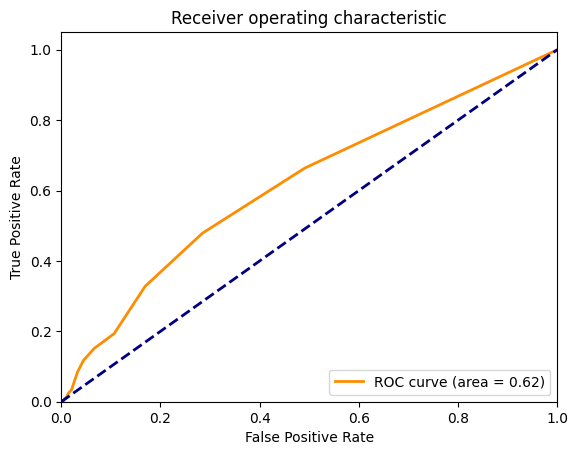

min bootstrapping aucroc:
0.5219817997977755
max bootstrapping aucroc:
0.6850273003033367
p_onesided = 0
p_twosided = 0
boots_mean_AUCROC =
0.614283563547805(0.5618881480950446,0.6637426900584795)

...END AUCROC
BEGIN LOADING KSADS...

...FINISH LOADING KSADS
BEGIN LOADING CBCL, anx/dep or with/dep...
...FINISH LOADING CBCL, anx/dep or with/dep...
BEGIN MERGING...
...FINISH MERGING
BEGIN PREPROCESSING...

Last check of missing data. Non-null rows = 0

Check that positives and negatives dont overlap
Index([], dtype='object', name='src_subject_id')
FINAL Number of positives in the data n=119
Number of negatives in the data (before subsampling) n=78
Overall sample size (before subsampling) n=197
Not enough negative samples to use the desired neg/pos rate. Using all negative samples
FINAL Number of negatives in the data (after subsampling) n=78
FINAL Overall sample size (before subsampling) n=197

...END PREPROCESSING

START ANALYSIS


Input Data: CBCL anx/dex or with/dep
Scale: withdrawnd

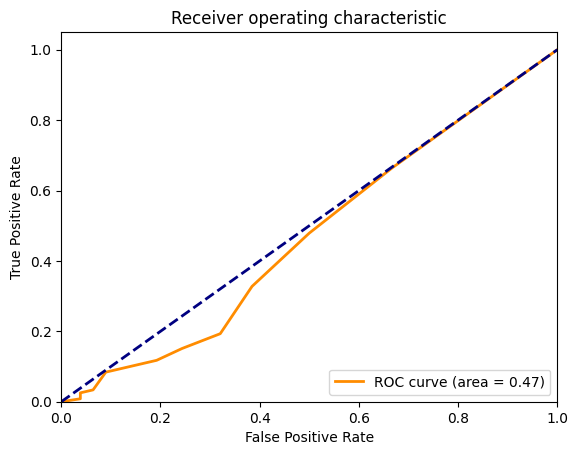

min bootstrapping aucroc:
0.3310678555893867
max bootstrapping aucroc:
0.6067347835640519
p_onesided = 0
p_twosided = 0
boots_mean_AUCROC =
0.4692642513000753(0.38355555555555554,0.554257528556594)

...END AUCROC
BEGIN LOADING KSADS...

...FINISH LOADING KSADS
BEGIN LOADING CBCL, anx/dep or with/dep...
...FINISH LOADING CBCL, anx/dep or with/dep...
BEGIN MERGING...
...FINISH MERGING
BEGIN PREPROCESSING...

Last check of missing data. Non-null rows = 0

Check that positives and negatives dont overlap
Index([], dtype='object', name='src_subject_id')
FINAL Number of positives in the data n=105
Number of negatives in the data (before subsampling) n=78
Overall sample size (before subsampling) n=183
Not enough negative samples to use the desired neg/pos rate. Using all negative samples
FINAL Number of negatives in the data (after subsampling) n=78
FINAL Overall sample size (before subsampling) n=183

...END PREPROCESSING

START ANALYSIS


Input Data: CBCL anx/dex or with/dep
Scale: withdrawn

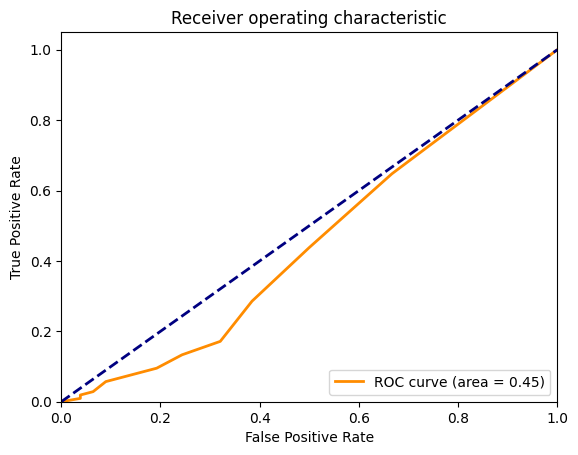

min bootstrapping aucroc:
0.3052783613445378
max bootstrapping aucroc:
0.5845301850048685
p_onesided = 0
p_twosided = 0
boots_mean_AUCROC =
0.4490528319060783(0.3665744466800805,0.5327838827838829)

...END AUCROC
BEGIN LOADING KSADS...

...FINISH LOADING KSADS
BEGIN LOADING CBCL, anx/dep or with/dep...
...FINISH LOADING CBCL, anx/dep or with/dep...
BEGIN MERGING...
...FINISH MERGING
BEGIN PREPROCESSING...

Last check of missing data. Non-null rows = 0

Check that positives and negatives dont overlap
Index([], dtype='object', name='src_subject_id')
FINAL Number of positives in the data n=119
Number of negatives in the data (before subsampling) n=11667
Overall sample size (before subsampling) n=11786
FINAL Number of negatives in the data (after subsampling) n=1071
FINAL Overall sample size (before subsampling) n=1190
demo_sex_v2
1.0    644
2.0    546
Name: count, dtype: int64
Positive girls in sample = 43
Positive boys in sample = 76

...END PREPROCESSING

START ANALYSIS


Input Data: CB

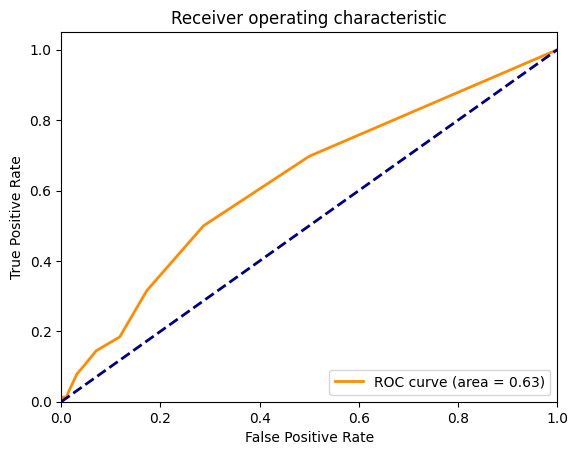

min bootstrapping aucroc:
0.5298883845361051
max bootstrapping aucroc:
0.7461195211477101
p_onesided = 0
p_twosided = 0
boots_mean_AUCROC =
0.6246135496345817(0.5559105797201035,0.6868846347827994)

...END AUCROC
BEGIN LOADING KSADS...

...FINISH LOADING KSADS
BEGIN LOADING CBCL, anx/dep or with/dep...
...FINISH LOADING CBCL, anx/dep or with/dep...
BEGIN MERGING...
...FINISH MERGING
BEGIN PREPROCESSING...

Last check of missing data. Non-null rows = 0

Check that positives and negatives dont overlap
Index([], dtype='object', name='src_subject_id')
FINAL Number of positives in the data n=119
Number of negatives in the data (before subsampling) n=78
Overall sample size (before subsampling) n=197
Not enough negative samples to use the desired neg/pos rate. Using all negative samples
FINAL Number of negatives in the data (after subsampling) n=78
FINAL Overall sample size (before subsampling) n=197
demo_sex_v2
1.0    116
2.0     81
Name: count, dtype: int64
Positive girls in sample = 43
Pos

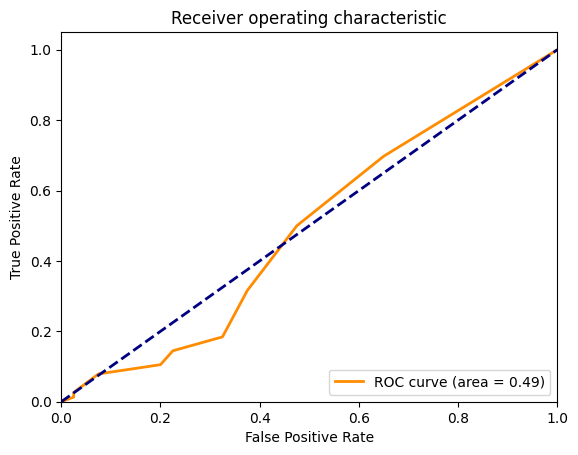

min bootstrapping aucroc:
0.32400257400257404
max bootstrapping aucroc:
0.7087209302325581
p_onesided = 0
p_twosided = 0
boots_mean_AUCROC =
0.49282735845396214(0.38146341463414635,0.6102941176470589)

...END AUCROC
BEGIN LOADING KSADS...

...FINISH LOADING KSADS
BEGIN LOADING CBCL, anx/dep or with/dep...
...FINISH LOADING CBCL, anx/dep or with/dep...
BEGIN MERGING...
...FINISH MERGING
BEGIN PREPROCESSING...

Last check of missing data. Non-null rows = 0

Check that positives and negatives dont overlap
Index([], dtype='object', name='src_subject_id')
FINAL Number of positives in the data n=105
Number of negatives in the data (before subsampling) n=78
Overall sample size (before subsampling) n=183
Not enough negative samples to use the desired neg/pos rate. Using all negative samples
FINAL Number of negatives in the data (after subsampling) n=78
FINAL Overall sample size (before subsampling) n=183
demo_sex_v2
1.0    108
2.0     75
Name: count, dtype: int64
Positive girls in sample = 37


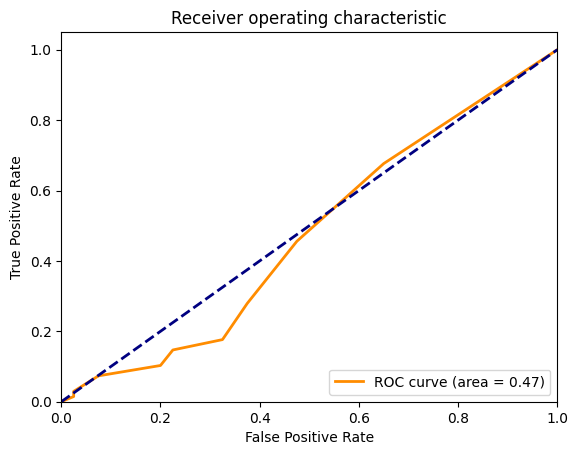

min bootstrapping aucroc:
0.3046704495853339
max bootstrapping aucroc:
0.6399147727272727
p_onesided = 0
p_twosided = 0
boots_mean_AUCROC =
0.4717545980193325(0.36100178890876566,0.5863997113997115)

...END AUCROC
BEGIN LOADING KSADS...

...FINISH LOADING KSADS
BEGIN LOADING CBCL, anx/dep or with/dep...
...FINISH LOADING CBCL, anx/dep or with/dep...
BEGIN MERGING...
...FINISH MERGING
BEGIN PREPROCESSING...

Last check of missing data. Non-null rows = 0

Check that positives and negatives dont overlap
Index([], dtype='object', name='src_subject_id')
FINAL Number of positives in the data n=119
Number of negatives in the data (before subsampling) n=11667
Overall sample size (before subsampling) n=11786
FINAL Number of negatives in the data (after subsampling) n=1071
FINAL Overall sample size (before subsampling) n=1190
demo_sex_v2
1.0    619
2.0    571
Name: count, dtype: int64
Positive girls in sample = 43
Positive boys in sample = 76

...END PREPROCESSING

START ANALYSIS


Input Data: C

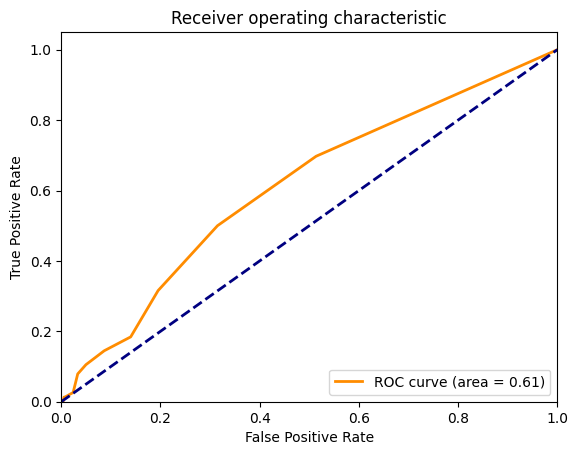

min bootstrapping aucroc:
0.4644398489480309
max bootstrapping aucroc:
0.7092592592592593
p_onesided = 0
p_twosided = 0
boots_mean_AUCROC =
0.609755036488975(0.545171875717105,0.6781741465285769)

...END AUCROC
BEGIN LOADING KSADS...

...FINISH LOADING KSADS
BEGIN LOADING CBCL, anx/dep or with/dep...
...FINISH LOADING CBCL, anx/dep or with/dep...
BEGIN MERGING...
...FINISH MERGING
BEGIN PREPROCESSING...

Last check of missing data. Non-null rows = 0

Check that positives and negatives dont overlap
Index([], dtype='object', name='src_subject_id')
FINAL Number of positives in the data n=119
Number of negatives in the data (before subsampling) n=78
Overall sample size (before subsampling) n=197
Not enough negative samples to use the desired neg/pos rate. Using all negative samples
FINAL Number of negatives in the data (after subsampling) n=78
FINAL Overall sample size (before subsampling) n=197
demo_sex_v2
1.0    116
2.0     81
Name: count, dtype: int64
Positive girls in sample = 43
Posit

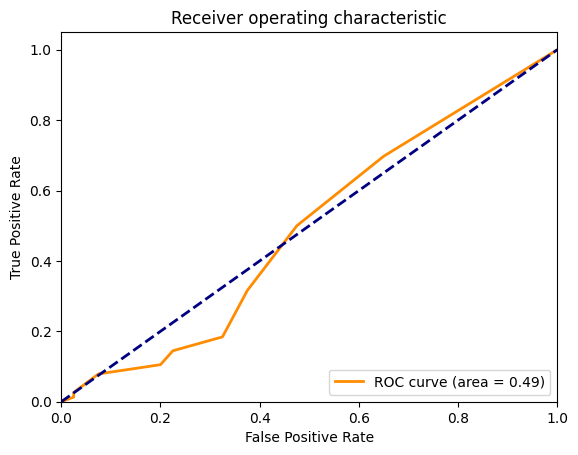

min bootstrapping aucroc:
0.3324898785425101
max bootstrapping aucroc:
0.6838731443994602
p_onesided = 0
p_twosided = 0
boots_mean_AUCROC =
0.4880294897319449(0.37545787545787546,0.6070075757575757)

...END AUCROC
BEGIN LOADING KSADS...

...FINISH LOADING KSADS
BEGIN LOADING CBCL, anx/dep or with/dep...
...FINISH LOADING CBCL, anx/dep or with/dep...
BEGIN MERGING...
...FINISH MERGING
BEGIN PREPROCESSING...

Last check of missing data. Non-null rows = 0

Check that positives and negatives dont overlap
Index([], dtype='object', name='src_subject_id')
FINAL Number of positives in the data n=105
Number of negatives in the data (before subsampling) n=78
Overall sample size (before subsampling) n=183
Not enough negative samples to use the desired neg/pos rate. Using all negative samples
FINAL Number of negatives in the data (after subsampling) n=78
FINAL Overall sample size (before subsampling) n=183
demo_sex_v2
1.0    108
2.0     75
Name: count, dtype: int64
Positive girls in sample = 37
Po

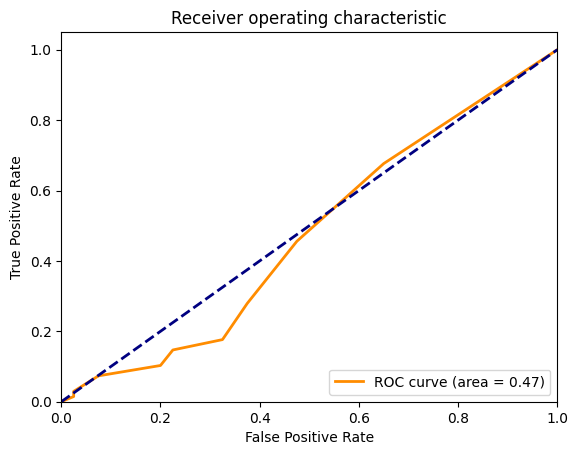

min bootstrapping aucroc:
0.28199608610567517
max bootstrapping aucroc:
0.6701112877583465
p_onesided = 0
p_twosided = 0
boots_mean_AUCROC =
0.47367060555223806(0.35470085470085466,0.5840548340548342)

...END AUCROC
BEGIN LOADING KSADS...

...FINISH LOADING KSADS
BEGIN LOADING CBCL, anx/dep or with/dep...
...FINISH LOADING CBCL, anx/dep or with/dep...
BEGIN MERGING...
...FINISH MERGING
BEGIN PREPROCESSING...

Last check of missing data. Non-null rows = 0

Check that positives and negatives dont overlap
Index([], dtype='object', name='src_subject_id')
FINAL Number of positives in the data n=83
Number of negatives in the data (before subsampling) n=10619
Overall sample size (before subsampling) n=10702
FINAL Number of negatives in the data (after subsampling) n=747
FINAL Overall sample size (before subsampling) n=830

...END PREPROCESSING

START ANALYSIS


Input Data: CBCL anx/dex or with/dep
Scale: anxiousdep
Wave: optimal
Ksads Reporter: parent
Hypothesis: 1
Sex: both
BEGIN AUCROC...



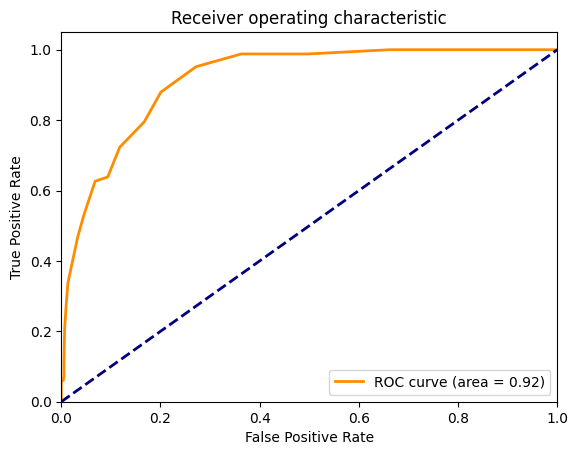

min bootstrapping aucroc:
0.8552806086835125
max bootstrapping aucroc:
0.9530835543766578
p_onesided = 1
p_twosided = 0
boots_mean_AUCROC =
0.9157732712896043(0.8881861063464838,0.9405416666666666)

...END AUCROC
BEGIN LOADING KSADS...

...FINISH LOADING KSADS
BEGIN LOADING CBCL, anx/dep or with/dep...
...FINISH LOADING CBCL, anx/dep or with/dep...
BEGIN MERGING...
...FINISH MERGING
BEGIN PREPROCESSING...

Last check of missing data. Non-null rows = 0

Check that positives and negatives dont overlap
Index([], dtype='object', name='src_subject_id')
FINAL Number of positives in the data n=83
Number of negatives in the data (before subsampling) n=1372
Overall sample size (before subsampling) n=1455
FINAL Number of negatives in the data (after subsampling) n=747
FINAL Overall sample size (before subsampling) n=830

...END PREPROCESSING

START ANALYSIS


Input Data: CBCL anx/dex or with/dep
Scale: anxiousdep
Wave: optimal
Ksads Reporter: parent
Hypothesis: 2a
Sex: both
BEGIN AUCROC...

Sing

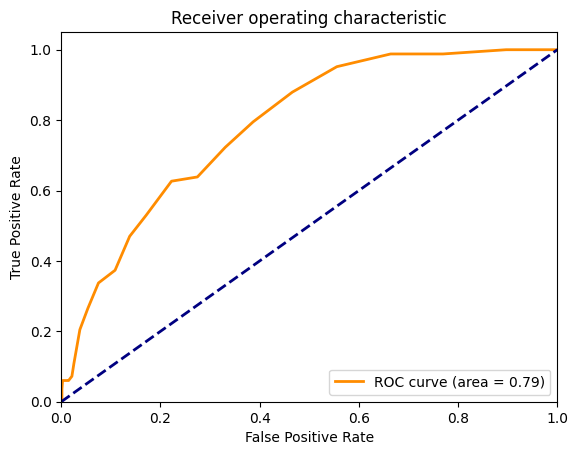

min bootstrapping aucroc:
0.7231699879674958
max bootstrapping aucroc:
0.8621478621478622
p_onesided = 0
p_twosided = 0
boots_mean_AUCROC =
0.7855420150802571(0.7420881584922798,0.8279381898454747)

...END AUCROC
BEGIN LOADING KSADS...

...FINISH LOADING KSADS
BEGIN LOADING CBCL, anx/dep or with/dep...
...FINISH LOADING CBCL, anx/dep or with/dep...
BEGIN MERGING...
...FINISH MERGING
BEGIN PREPROCESSING...

Last check of missing data. Non-null rows = 0

Check that positives and negatives dont overlap
Index([], dtype='object', name='src_subject_id')
FINAL Number of positives in the data n=33
Number of negatives in the data (before subsampling) n=1372
Overall sample size (before subsampling) n=1405
FINAL Number of negatives in the data (after subsampling) n=297
FINAL Overall sample size (before subsampling) n=330

...END PREPROCESSING

START ANALYSIS


Input Data: CBCL anx/dex or with/dep
Scale: anxiousdep
Wave: optimal
Ksads Reporter: parent
Hypothesis: 2b
Sex: both
BEGIN AUCROC...

Sing

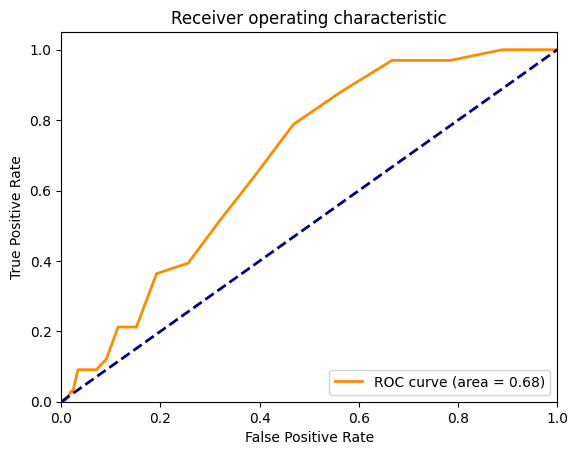

min bootstrapping aucroc:
0.5639297385620915
max bootstrapping aucroc:
0.8201013513513513
p_onesided = 0
p_twosided = 0
boots_mean_AUCROC =
0.6832380498484841(0.6032388663967612,0.759796626984127)

...END AUCROC
BEGIN LOADING KSADS...

...FINISH LOADING KSADS
BEGIN LOADING CBCL, anx/dep or with/dep...
...FINISH LOADING CBCL, anx/dep or with/dep...
BEGIN MERGING...
...FINISH MERGING
BEGIN PREPROCESSING...

Last check of missing data. Non-null rows = 0

Check that positives and negatives dont overlap
Index([], dtype='object', name='src_subject_id')
FINAL Number of positives in the data n=83
Number of negatives in the data (before subsampling) n=10619
Overall sample size (before subsampling) n=10702
FINAL Number of negatives in the data (after subsampling) n=747
FINAL Overall sample size (before subsampling) n=830
demo_sex_v2
1.0    434
2.0    396
Name: count, dtype: int64
Positive girls in sample = 45
Positive boys in sample = 38

...END PREPROCESSING

START ANALYSIS


Input Data: CBCL a

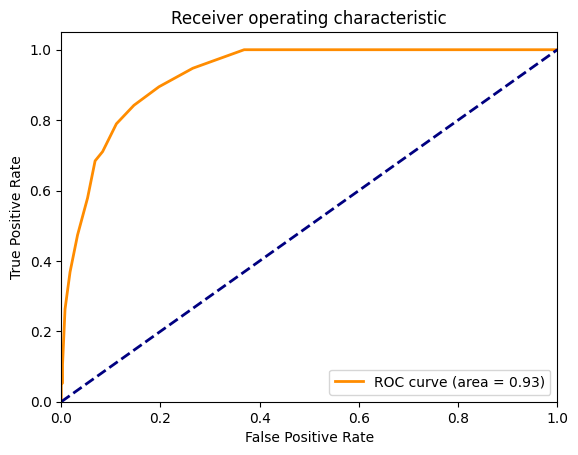

min bootstrapping aucroc:
0.8689711132749107
max bootstrapping aucroc:
0.9853078358208954
p_onesided = 1
p_twosided = 0
boots_mean_AUCROC =
0.9297775232800498(0.8990441176470588,0.9578125)

...END AUCROC
BEGIN LOADING KSADS...

...FINISH LOADING KSADS
BEGIN LOADING CBCL, anx/dep or with/dep...
...FINISH LOADING CBCL, anx/dep or with/dep...
BEGIN MERGING...
...FINISH MERGING
BEGIN PREPROCESSING...

Last check of missing data. Non-null rows = 0

Check that positives and negatives dont overlap
Index([], dtype='object', name='src_subject_id')
FINAL Number of positives in the data n=83
Number of negatives in the data (before subsampling) n=1372
Overall sample size (before subsampling) n=1455
FINAL Number of negatives in the data (after subsampling) n=747
FINAL Overall sample size (before subsampling) n=830
demo_sex_v2
1.0    474
2.0    355
3.0      1
Name: count, dtype: int64
Positive girls in sample = 45
Positive boys in sample = 38

...END PREPROCESSING

START ANALYSIS


Input Data: CBCL 

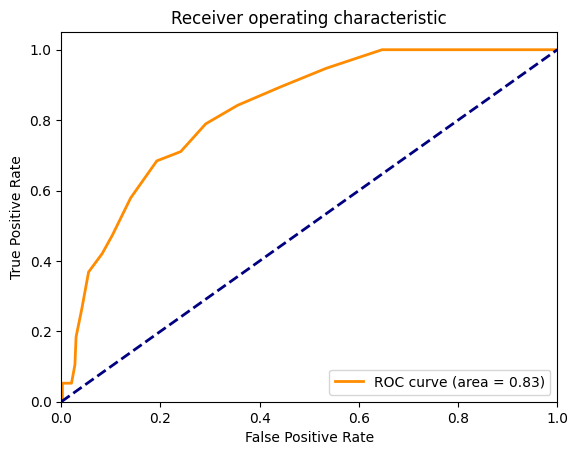

min bootstrapping aucroc:
0.7337466098411468
max bootstrapping aucroc:
0.9273061497326204
p_onesided = 0
p_twosided = 0
boots_mean_AUCROC =
0.8296249460515931(0.7669647387113141,0.8828470380194519)

...END AUCROC
BEGIN LOADING KSADS...

...FINISH LOADING KSADS
BEGIN LOADING CBCL, anx/dep or with/dep...
...FINISH LOADING CBCL, anx/dep or with/dep...
BEGIN MERGING...
...FINISH MERGING
BEGIN PREPROCESSING...

Last check of missing data. Non-null rows = 0

Check that positives and negatives dont overlap
Index([], dtype='object', name='src_subject_id')
FINAL Number of positives in the data n=33
Number of negatives in the data (before subsampling) n=1372
Overall sample size (before subsampling) n=1405
FINAL Number of negatives in the data (after subsampling) n=297
FINAL Overall sample size (before subsampling) n=330
demo_sex_v2
1.0    173
2.0    156
3.0      1
Name: count, dtype: int64
Positive girls in sample = 21
Positive boys in sample = 12

...END PREPROCESSING

START ANALYSIS


Input Da

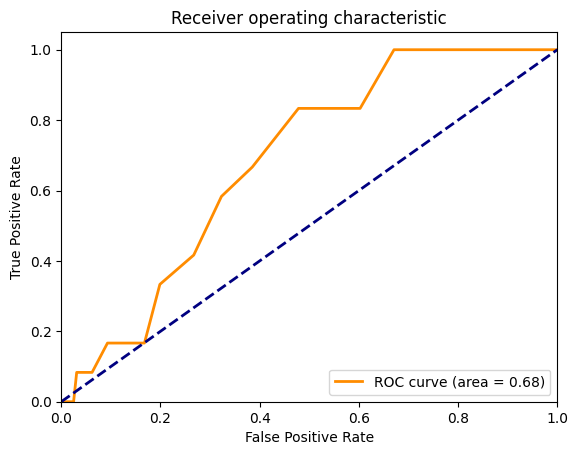

min bootstrapping aucroc:
0.46818181818181814
max bootstrapping aucroc:
0.8916666666666666
p_onesided = 0
p_twosided = 0
boots_mean_AUCROC =
0.6843511851478894(0.5576687116564416,0.8099593495934959)

...END AUCROC
BEGIN LOADING KSADS...

...FINISH LOADING KSADS
BEGIN LOADING CBCL, anx/dep or with/dep...
...FINISH LOADING CBCL, anx/dep or with/dep...
BEGIN MERGING...
...FINISH MERGING
BEGIN PREPROCESSING...

Last check of missing data. Non-null rows = 0

Check that positives and negatives dont overlap
Index([], dtype='object', name='src_subject_id')
FINAL Number of positives in the data n=83
Number of negatives in the data (before subsampling) n=10619
Overall sample size (before subsampling) n=10702
FINAL Number of negatives in the data (after subsampling) n=747
FINAL Overall sample size (before subsampling) n=830
demo_sex_v2
2.0    420
1.0    410
Name: count, dtype: int64
Positive girls in sample = 45
Positive boys in sample = 38

...END PREPROCESSING

START ANALYSIS


Input Data: CBCL

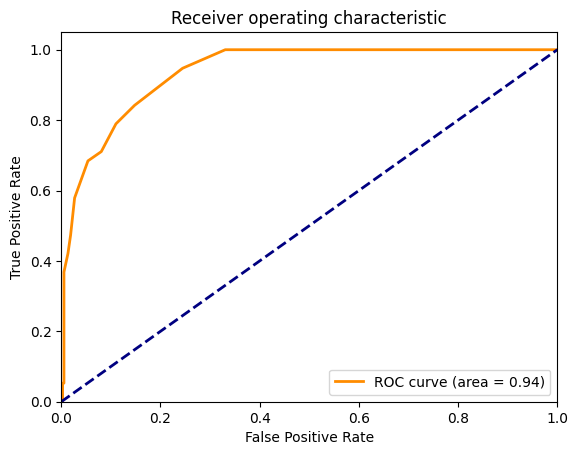

min bootstrapping aucroc:
0.8832044418005156
max bootstrapping aucroc:
0.987705684367988
p_onesided = 1
p_twosided = 0
boots_mean_AUCROC =
0.9377539167214644(0.9039262343842951,0.9653362295230337)

...END AUCROC
BEGIN LOADING KSADS...

...FINISH LOADING KSADS
BEGIN LOADING CBCL, anx/dep or with/dep...
...FINISH LOADING CBCL, anx/dep or with/dep...
BEGIN MERGING...
...FINISH MERGING
BEGIN PREPROCESSING...

Last check of missing data. Non-null rows = 0

Check that positives and negatives dont overlap
Index([], dtype='object', name='src_subject_id')
FINAL Number of positives in the data n=83
Number of negatives in the data (before subsampling) n=1372
Overall sample size (before subsampling) n=1455
FINAL Number of negatives in the data (after subsampling) n=747
FINAL Overall sample size (before subsampling) n=830
demo_sex_v2
1.0    449
2.0    381
Name: count, dtype: int64
Positive girls in sample = 45
Positive boys in sample = 38

...END PREPROCESSING

START ANALYSIS


Input Data: CBCL anx

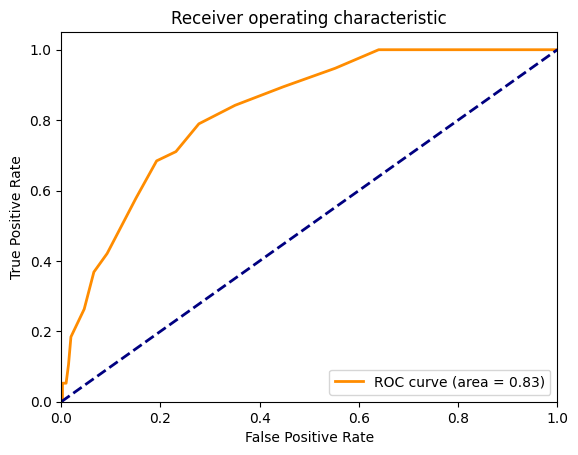

min bootstrapping aucroc:
0.7248113041951905
max bootstrapping aucroc:
0.9116229624379872
p_onesided = 0
p_twosided = 0
boots_mean_AUCROC =
0.8267016273219505(0.7664337885042871,0.8823529411764706)

...END AUCROC
BEGIN LOADING KSADS...

...FINISH LOADING KSADS
BEGIN LOADING CBCL, anx/dep or with/dep...
...FINISH LOADING CBCL, anx/dep or with/dep...
BEGIN MERGING...
...FINISH MERGING
BEGIN PREPROCESSING...

Last check of missing data. Non-null rows = 0

Check that positives and negatives dont overlap
Index([], dtype='object', name='src_subject_id')
FINAL Number of positives in the data n=33
Number of negatives in the data (before subsampling) n=1372
Overall sample size (before subsampling) n=1405
FINAL Number of negatives in the data (after subsampling) n=297
FINAL Overall sample size (before subsampling) n=330
demo_sex_v2
1.0    178
2.0    152
Name: count, dtype: int64
Positive girls in sample = 21
Positive boys in sample = 12

...END PREPROCESSING

START ANALYSIS


Input Data: CBCL an

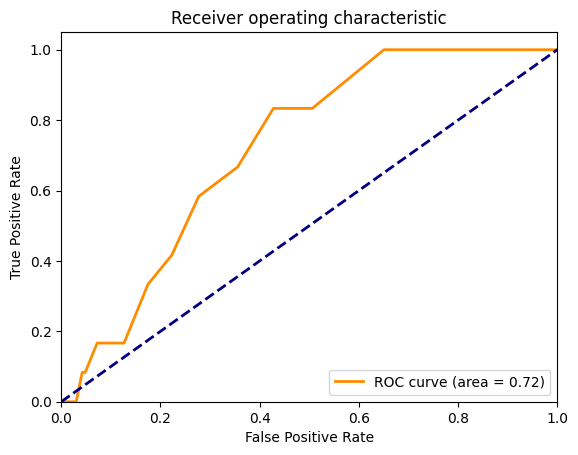

min bootstrapping aucroc:
0.5315732172019597
max bootstrapping aucroc:
0.8952095808383234
p_onesided = 0
p_twosided = 0
boots_mean_AUCROC =
0.7236285420405023(0.6020833333333333,0.831360946745562)

...END AUCROC
BEGIN LOADING KSADS...

...FINISH LOADING KSADS
BEGIN LOADING CBCL, anx/dep or with/dep...
...FINISH LOADING CBCL, anx/dep or with/dep...
BEGIN MERGING...
...FINISH MERGING
BEGIN PREPROCESSING...

Last check of missing data. Non-null rows = 0

Check that positives and negatives dont overlap
Index([], dtype='object', name='src_subject_id')
FINAL Number of positives in the data n=83
Number of negatives in the data (before subsampling) n=10618
Overall sample size (before subsampling) n=10701
FINAL Number of negatives in the data (after subsampling) n=747
FINAL Overall sample size (before subsampling) n=830

...END PREPROCESSING

START ANALYSIS


Input Data: CBCL anx/dex or with/dep
Scale: withdrawndep
Wave: optimal
Ksads Reporter: parent
Hypothesis: 1
Sex: both
BEGIN AUCROC...

Si

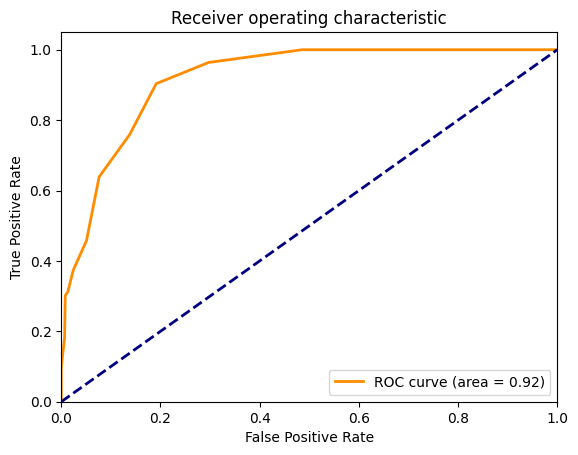

min bootstrapping aucroc:
0.8809683390782587
max bootstrapping aucroc:
0.9562508937508937
p_onesided = 1
p_twosided = 0
boots_mean_AUCROC =
0.9178630833114186(0.8956390544208404,0.939788838612368)

...END AUCROC
BEGIN LOADING KSADS...

...FINISH LOADING KSADS
BEGIN LOADING CBCL, anx/dep or with/dep...
...FINISH LOADING CBCL, anx/dep or with/dep...
BEGIN MERGING...
...FINISH MERGING
BEGIN PREPROCESSING...

Last check of missing data. Non-null rows = 0

Check that positives and negatives dont overlap
Index([], dtype='object', name='src_subject_id')
FINAL Number of positives in the data n=83
Number of negatives in the data (before subsampling) n=1372
Overall sample size (before subsampling) n=1455
FINAL Number of negatives in the data (after subsampling) n=747
FINAL Overall sample size (before subsampling) n=830

...END PREPROCESSING

START ANALYSIS


Input Data: CBCL anx/dex or with/dep
Scale: withdrawndep
Wave: optimal
Ksads Reporter: parent
Hypothesis: 2a
Sex: both
BEGIN AUCROC...

Sin

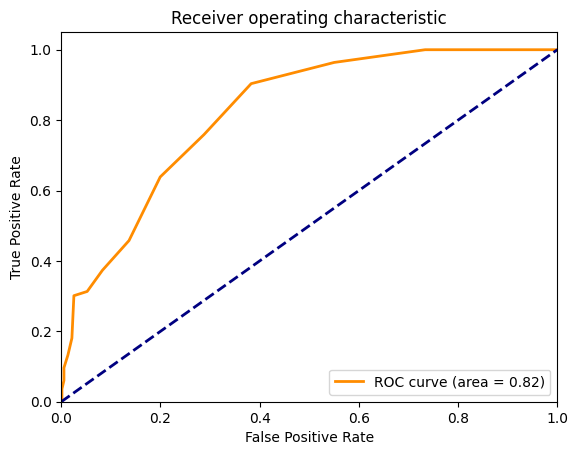

min bootstrapping aucroc:
0.7547099836819463
max bootstrapping aucroc:
0.8941732177952475
p_onesided = 0
p_twosided = 0
boots_mean_AUCROC =
0.8226555048899085(0.781681382912573,0.8618166666666667)

...END AUCROC
BEGIN LOADING KSADS...

...FINISH LOADING KSADS
BEGIN LOADING CBCL, anx/dep or with/dep...
...FINISH LOADING CBCL, anx/dep or with/dep...
BEGIN MERGING...
...FINISH MERGING
BEGIN PREPROCESSING...

Last check of missing data. Non-null rows = 0

Check that positives and negatives dont overlap
Index([], dtype='object', name='src_subject_id')
FINAL Number of positives in the data n=33
Number of negatives in the data (before subsampling) n=1372
Overall sample size (before subsampling) n=1405
FINAL Number of negatives in the data (after subsampling) n=297
FINAL Overall sample size (before subsampling) n=330

...END PREPROCESSING

START ANALYSIS


Input Data: CBCL anx/dex or with/dep
Scale: withdrawndep
Wave: optimal
Ksads Reporter: parent
Hypothesis: 2b
Sex: both
BEGIN AUCROC...

Sin

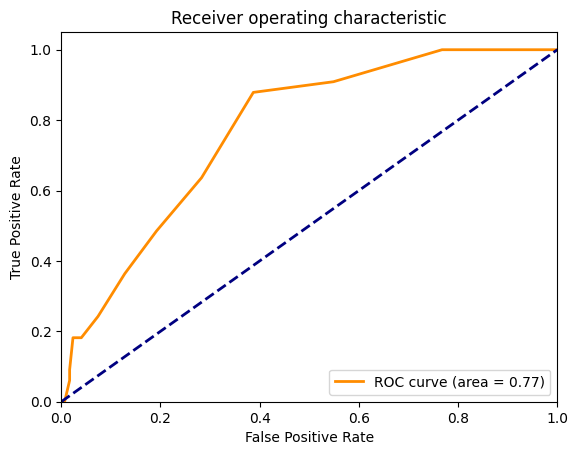

min bootstrapping aucroc:
0.60712272129299
max bootstrapping aucroc:
0.8797061524334252
p_onesided = 0
p_twosided = 0
boots_mean_AUCROC =
0.7723591153259078(0.7021791767554479,0.8390333369295501)

...END AUCROC
BEGIN LOADING KSADS...

...FINISH LOADING KSADS
BEGIN LOADING CBCL, anx/dep or with/dep...
...FINISH LOADING CBCL, anx/dep or with/dep...
BEGIN MERGING...
...FINISH MERGING
BEGIN PREPROCESSING...

Last check of missing data. Non-null rows = 0

Check that positives and negatives dont overlap
Index([], dtype='object', name='src_subject_id')
FINAL Number of positives in the data n=83
Number of negatives in the data (before subsampling) n=10618
Overall sample size (before subsampling) n=10701
FINAL Number of negatives in the data (after subsampling) n=747
FINAL Overall sample size (before subsampling) n=830
demo_sex_v2
1.0    417
2.0    412
3.0      1
Name: count, dtype: int64
Positive girls in sample = 45
Positive boys in sample = 38

...END PREPROCESSING

START ANALYSIS


Input Da

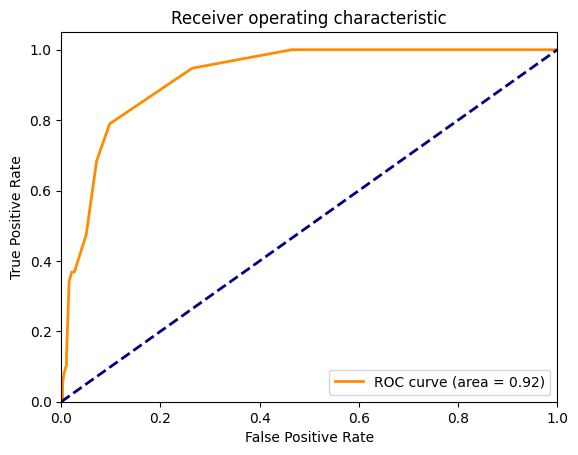

min bootstrapping aucroc:
0.8650974025974026
max bootstrapping aucroc:
0.9758482366705666
p_onesided = 1
p_twosided = 0
boots_mean_AUCROC =
0.9229242966062059(0.8868510845722641,0.9543006731488407)

...END AUCROC
BEGIN LOADING KSADS...

...FINISH LOADING KSADS
BEGIN LOADING CBCL, anx/dep or with/dep...
...FINISH LOADING CBCL, anx/dep or with/dep...
BEGIN MERGING...
...FINISH MERGING
BEGIN PREPROCESSING...

Last check of missing data. Non-null rows = 0

Check that positives and negatives dont overlap
Index([], dtype='object', name='src_subject_id')
FINAL Number of positives in the data n=83
Number of negatives in the data (before subsampling) n=1372
Overall sample size (before subsampling) n=1455
FINAL Number of negatives in the data (after subsampling) n=747
FINAL Overall sample size (before subsampling) n=830
demo_sex_v2
1.0    472
2.0    357
3.0      1
Name: count, dtype: int64
Positive girls in sample = 45
Positive boys in sample = 38

...END PREPROCESSING

START ANALYSIS


Input Da

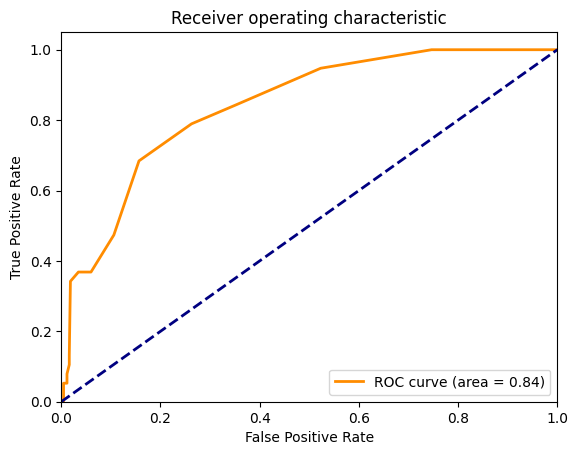

min bootstrapping aucroc:
0.7214129211819743
max bootstrapping aucroc:
0.9385926413576184
p_onesided = 0
p_twosided = 0
boots_mean_AUCROC =
0.8393169316567368(0.776186973006621,0.8984664351851851)

...END AUCROC
BEGIN LOADING KSADS...

...FINISH LOADING KSADS
BEGIN LOADING CBCL, anx/dep or with/dep...
...FINISH LOADING CBCL, anx/dep or with/dep...
BEGIN MERGING...
...FINISH MERGING
BEGIN PREPROCESSING...

Last check of missing data. Non-null rows = 0

Check that positives and negatives dont overlap
Index([], dtype='object', name='src_subject_id')
FINAL Number of positives in the data n=33
Number of negatives in the data (before subsampling) n=1372
Overall sample size (before subsampling) n=1405
FINAL Number of negatives in the data (after subsampling) n=297
FINAL Overall sample size (before subsampling) n=330
demo_sex_v2
1.0    182
2.0    148
Name: count, dtype: int64
Positive girls in sample = 21
Positive boys in sample = 12

...END PREPROCESSING

START ANALYSIS


Input Data: CBCL anx

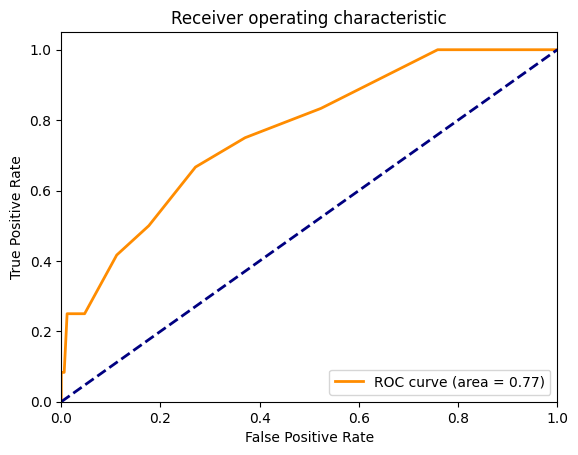

min bootstrapping aucroc:
0.5555232558139535
max bootstrapping aucroc:
0.9493534482758621
p_onesided = 0
p_twosided = 0
boots_mean_AUCROC =
0.7674115949008922(0.6246234939759037,0.8961925287356322)

...END AUCROC
BEGIN LOADING KSADS...

...FINISH LOADING KSADS
BEGIN LOADING CBCL, anx/dep or with/dep...
...FINISH LOADING CBCL, anx/dep or with/dep...
BEGIN MERGING...
...FINISH MERGING
BEGIN PREPROCESSING...

Last check of missing data. Non-null rows = 0

Check that positives and negatives dont overlap
Index([], dtype='object', name='src_subject_id')
FINAL Number of positives in the data n=83
Number of negatives in the data (before subsampling) n=10618
Overall sample size (before subsampling) n=10701
FINAL Number of negatives in the data (after subsampling) n=747
FINAL Overall sample size (before subsampling) n=830
demo_sex_v2
1.0    444
2.0    386
Name: count, dtype: int64
Positive girls in sample = 45
Positive boys in sample = 38

...END PREPROCESSING

START ANALYSIS


Input Data: CBCL 

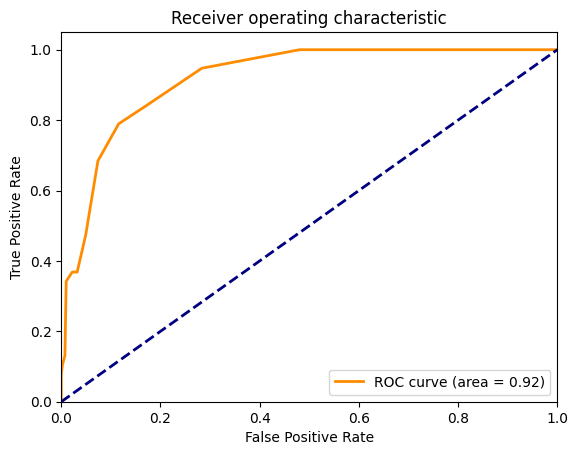

min bootstrapping aucroc:
0.8628007848807189
max bootstrapping aucroc:
0.9612856099342586
p_onesided = 1
p_twosided = 0
boots_mean_AUCROC =
0.9190452010457781(0.8844650888446509,0.9494485294117647)

...END AUCROC
BEGIN LOADING KSADS...

...FINISH LOADING KSADS
BEGIN LOADING CBCL, anx/dep or with/dep...
...FINISH LOADING CBCL, anx/dep or with/dep...
BEGIN MERGING...
...FINISH MERGING
BEGIN PREPROCESSING...

Last check of missing data. Non-null rows = 0

Check that positives and negatives dont overlap
Index([], dtype='object', name='src_subject_id')
FINAL Number of positives in the data n=83
Number of negatives in the data (before subsampling) n=1372
Overall sample size (before subsampling) n=1455
FINAL Number of negatives in the data (after subsampling) n=747
FINAL Overall sample size (before subsampling) n=830
demo_sex_v2
1.0    474
2.0    356
Name: count, dtype: int64
Positive girls in sample = 45
Positive boys in sample = 38

...END PREPROCESSING

START ANALYSIS


Input Data: CBCL an

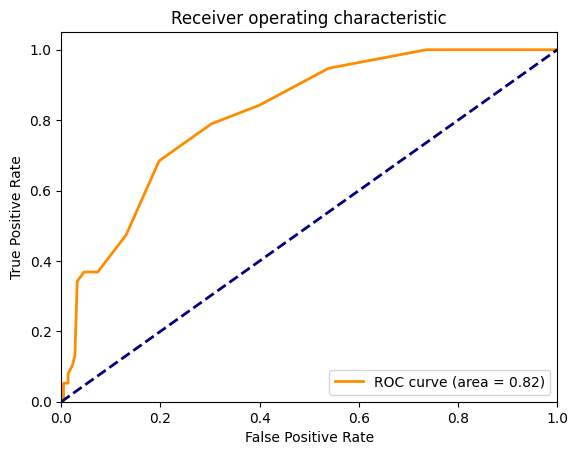

min bootstrapping aucroc:
0.698425925925926
max bootstrapping aucroc:
0.9120655080213904
p_onesided = 0
p_twosided = 0
boots_mean_AUCROC =
0.8190529915513908(0.7577659888004715,0.8772058823529412)

...END AUCROC
BEGIN LOADING KSADS...

...FINISH LOADING KSADS
BEGIN LOADING CBCL, anx/dep or with/dep...
...FINISH LOADING CBCL, anx/dep or with/dep...
BEGIN MERGING...
...FINISH MERGING
BEGIN PREPROCESSING...

Last check of missing data. Non-null rows = 0

Check that positives and negatives dont overlap
Index([], dtype='object', name='src_subject_id')
FINAL Number of positives in the data n=33
Number of negatives in the data (before subsampling) n=1372
Overall sample size (before subsampling) n=1405
FINAL Number of negatives in the data (after subsampling) n=297
FINAL Overall sample size (before subsampling) n=330
demo_sex_v2
1.0    174
2.0    156
Name: count, dtype: int64
Positive girls in sample = 21
Positive boys in sample = 12

...END PREPROCESSING

START ANALYSIS


Input Data: CBCL anx

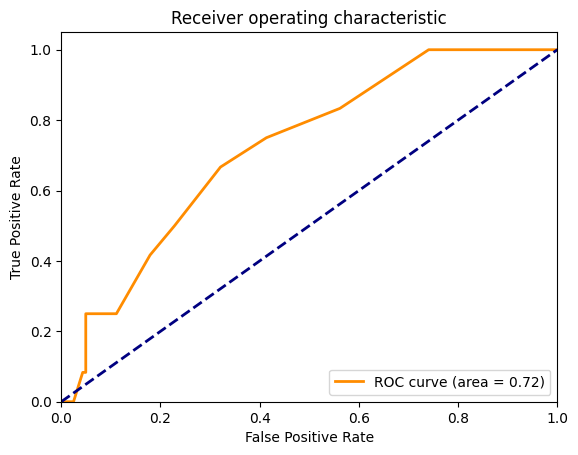

min bootstrapping aucroc:
0.4650887573964497
max bootstrapping aucroc:
0.9121212121212121
p_onesided = 0
p_twosided = 0
boots_mean_AUCROC =
0.7215237899762449(0.5895843287147635,0.845734126984127)

...END AUCROC
BEGIN LOADING KSADS...

...FINISH LOADING KSADS
BEGIN LOADING CBCL, anx/dep or with/dep...
...FINISH LOADING CBCL, anx/dep or with/dep...
BEGIN MERGING...
...FINISH MERGING
BEGIN PREPROCESSING...

Last check of missing data. Non-null rows = 0

Check that positives and negatives dont overlap
Index([], dtype='object', name='src_subject_id')
FINAL Number of positives in the data n=96
Number of negatives in the data (before subsampling) n=10684
Overall sample size (before subsampling) n=10780
FINAL Number of negatives in the data (after subsampling) n=864
FINAL Overall sample size (before subsampling) n=960

...END PREPROCESSING

START ANALYSIS


Input Data: CBCL anx/dex or with/dep
Scale: anxiousdep
Wave: optimal
Ksads Reporter: child
Hypothesis: 1
Sex: both
BEGIN AUCROC...

Singl

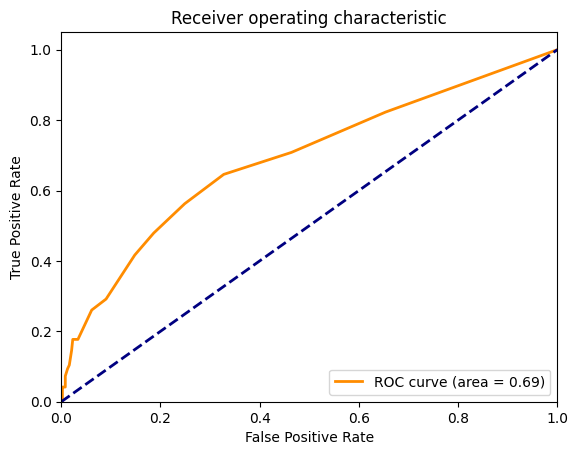

min bootstrapping aucroc:
0.6027372911482404
max bootstrapping aucroc:
0.7816566566566566
p_onesided = 0
p_twosided = 0
boots_mean_AUCROC =
0.6878168241435985(0.6298593683413041,0.7490348837209302)

...END AUCROC
BEGIN LOADING KSADS...

...FINISH LOADING KSADS
BEGIN LOADING CBCL, anx/dep or with/dep...
...FINISH LOADING CBCL, anx/dep or with/dep...
BEGIN MERGING...
...FINISH MERGING
BEGIN PREPROCESSING...

Last check of missing data. Non-null rows = 0

Check that positives and negatives dont overlap
Index([], dtype='object', name='src_subject_id')
FINAL Number of positives in the data n=96
Number of negatives in the data (before subsampling) n=118
Overall sample size (before subsampling) n=214
Not enough negative samples to use the desired neg/pos rate. Using all negative samples
FINAL Number of negatives in the data (after subsampling) n=118
FINAL Overall sample size (before subsampling) n=214

...END PREPROCESSING

START ANALYSIS


Input Data: CBCL anx/dex or with/dep
Scale: anxiousd

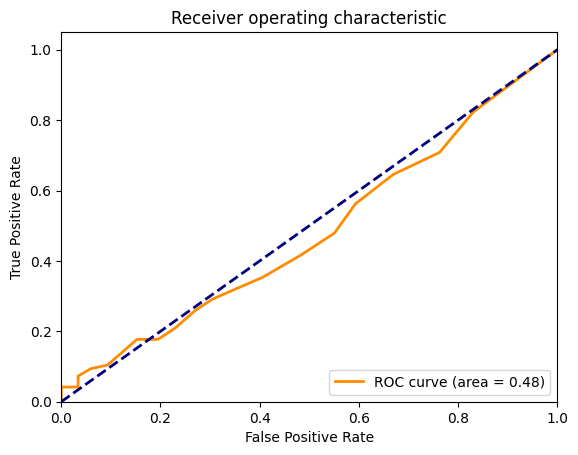

min bootstrapping aucroc:
0.3689010487916097
max bootstrapping aucroc:
0.6029270423765837
p_onesided = 0
p_twosided = 0
boots_mean_AUCROC =
0.4792558290993295(0.40637941668869504,0.5551754385964912)

...END AUCROC
BEGIN LOADING KSADS...

...FINISH LOADING KSADS
BEGIN LOADING CBCL, anx/dep or with/dep...
...FINISH LOADING CBCL, anx/dep or with/dep...
BEGIN MERGING...
...FINISH MERGING
BEGIN PREPROCESSING...

Last check of missing data. Non-null rows = 0

Check that positives and negatives dont overlap
Index([], dtype='object', name='src_subject_id')
FINAL Number of positives in the data n=71
Number of negatives in the data (before subsampling) n=118
Overall sample size (before subsampling) n=189
Not enough negative samples to use the desired neg/pos rate. Using all negative samples
FINAL Number of negatives in the data (after subsampling) n=118
FINAL Overall sample size (before subsampling) n=189

...END PREPROCESSING

START ANALYSIS


Input Data: CBCL anx/dex or with/dep
Scale: anxious

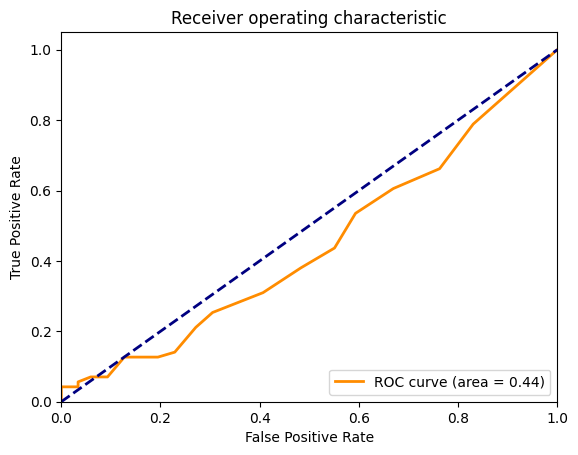

min bootstrapping aucroc:
0.32385964912280707
max bootstrapping aucroc:
0.5864325911426473
p_onesided = 0
p_twosided = 0
boots_mean_AUCROC =
0.4436162100110749(0.3615825688073394,0.5303223562152133)

...END AUCROC
BEGIN LOADING KSADS...

...FINISH LOADING KSADS
BEGIN LOADING CBCL, anx/dep or with/dep...
...FINISH LOADING CBCL, anx/dep or with/dep...
BEGIN MERGING...
...FINISH MERGING
BEGIN PREPROCESSING...

Last check of missing data. Non-null rows = 0

Check that positives and negatives dont overlap
Index([], dtype='object', name='src_subject_id')
FINAL Number of positives in the data n=96
Number of negatives in the data (before subsampling) n=10684
Overall sample size (before subsampling) n=10780
FINAL Number of negatives in the data (after subsampling) n=864
FINAL Overall sample size (before subsampling) n=960
demo_sex_v2
2.0    482
1.0    478
Name: count, dtype: int64
Positive girls in sample = 71
Positive boys in sample = 25

...END PREPROCESSING

START ANALYSIS


Input Data: CBCL

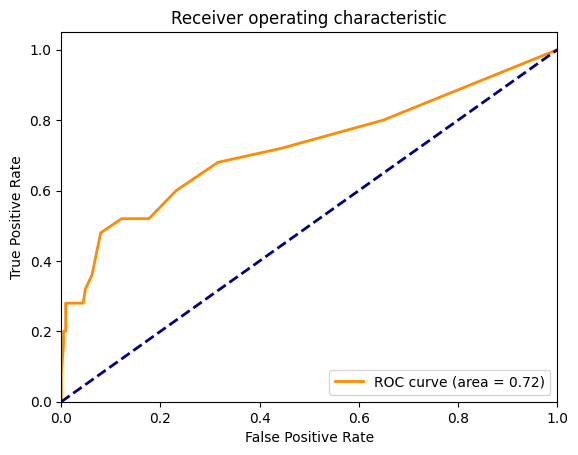

min bootstrapping aucroc:
0.4316881258941344
max bootstrapping aucroc:
0.9310322827612607
p_onesided = 0
p_twosided = 0
boots_mean_AUCROC =
0.7192519570575411(0.5909933774834437,0.8454746136865342)

...END AUCROC
BEGIN LOADING KSADS...

...FINISH LOADING KSADS
BEGIN LOADING CBCL, anx/dep or with/dep...
...FINISH LOADING CBCL, anx/dep or with/dep...
BEGIN MERGING...
...FINISH MERGING
BEGIN PREPROCESSING...

Last check of missing data. Non-null rows = 0

Check that positives and negatives dont overlap
Index([], dtype='object', name='src_subject_id')
FINAL Number of positives in the data n=96
Number of negatives in the data (before subsampling) n=118
Overall sample size (before subsampling) n=214
Not enough negative samples to use the desired neg/pos rate. Using all negative samples
FINAL Number of negatives in the data (after subsampling) n=118
FINAL Overall sample size (before subsampling) n=214
demo_sex_v2
2.0    166
1.0     48
Name: count, dtype: int64
Positive girls in sample = 71
Po

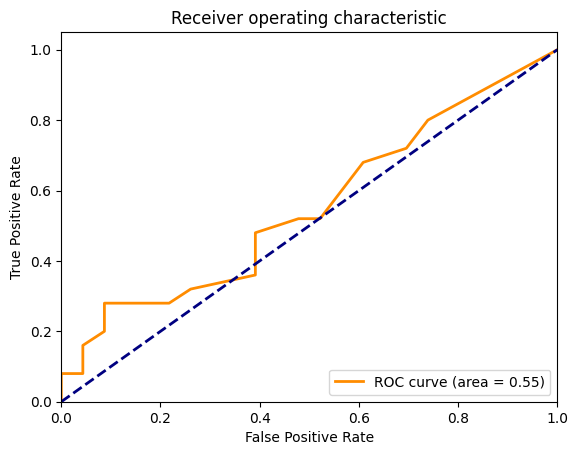

min bootstrapping aucroc:
0.26608695652173914
max bootstrapping aucroc:
0.7998251748251748
p_onesided = 0
p_twosided = 0
boots_mean_AUCROC =
0.5525603044338913(0.38536155202821865,0.7121739130434783)

...END AUCROC
BEGIN LOADING KSADS...

...FINISH LOADING KSADS
BEGIN LOADING CBCL, anx/dep or with/dep...
...FINISH LOADING CBCL, anx/dep or with/dep...
BEGIN MERGING...
...FINISH MERGING
BEGIN PREPROCESSING...

Last check of missing data. Non-null rows = 0

Check that positives and negatives dont overlap
Index([], dtype='object', name='src_subject_id')
FINAL Number of positives in the data n=71
Number of negatives in the data (before subsampling) n=118
Overall sample size (before subsampling) n=189
Not enough negative samples to use the desired neg/pos rate. Using all negative samples
FINAL Number of negatives in the data (after subsampling) n=118
FINAL Overall sample size (before subsampling) n=189
demo_sex_v2
2.0    144
1.0     45
Name: count, dtype: int64
Positive girls in sample = 49


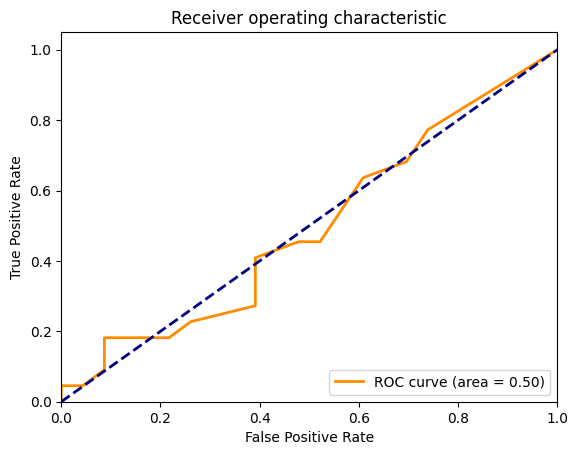

min bootstrapping aucroc:
0.22844827586206898
max bootstrapping aucroc:
0.7678571428571428
p_onesided = 0
p_twosided = 0
boots_mean_AUCROC =
0.49655580723843673(0.33035714285714285,0.6627155172413792)

...END AUCROC
BEGIN LOADING KSADS...

...FINISH LOADING KSADS
BEGIN LOADING CBCL, anx/dep or with/dep...
...FINISH LOADING CBCL, anx/dep or with/dep...
BEGIN MERGING...
...FINISH MERGING
BEGIN PREPROCESSING...

Last check of missing data. Non-null rows = 0

Check that positives and negatives dont overlap
Index([], dtype='object', name='src_subject_id')
FINAL Number of positives in the data n=96
Number of negatives in the data (before subsampling) n=10684
Overall sample size (before subsampling) n=10780
FINAL Number of negatives in the data (after subsampling) n=864
FINAL Overall sample size (before subsampling) n=960
demo_sex_v2
2.0    484
1.0    476
Name: count, dtype: int64
Positive girls in sample = 71
Positive boys in sample = 25

...END PREPROCESSING

START ANALYSIS


Input Data: CB

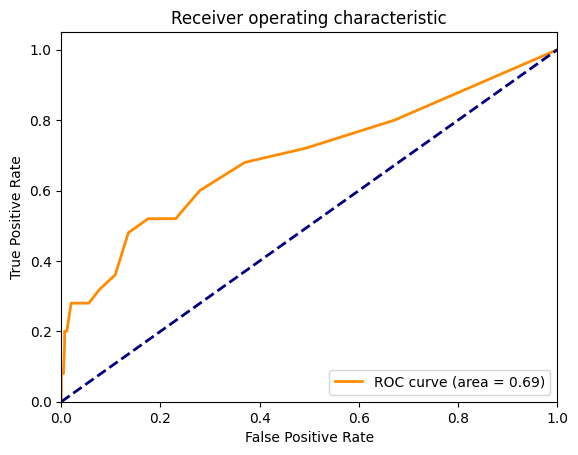

min bootstrapping aucroc:
0.5014395946101577
max bootstrapping aucroc:
0.9034334763948497
p_onesided = 0
p_twosided = 0
boots_mean_AUCROC =
0.6935057739294572(0.5677614795918368,0.8150350294985251)

...END AUCROC
BEGIN LOADING KSADS...

...FINISH LOADING KSADS
BEGIN LOADING CBCL, anx/dep or with/dep...
...FINISH LOADING CBCL, anx/dep or with/dep...
BEGIN MERGING...
...FINISH MERGING
BEGIN PREPROCESSING...

Last check of missing data. Non-null rows = 0

Check that positives and negatives dont overlap
Index([], dtype='object', name='src_subject_id')
FINAL Number of positives in the data n=96
Number of negatives in the data (before subsampling) n=118
Overall sample size (before subsampling) n=214
Not enough negative samples to use the desired neg/pos rate. Using all negative samples
FINAL Number of negatives in the data (after subsampling) n=118
FINAL Overall sample size (before subsampling) n=214
demo_sex_v2
2.0    166
1.0     48
Name: count, dtype: int64
Positive girls in sample = 71
Po

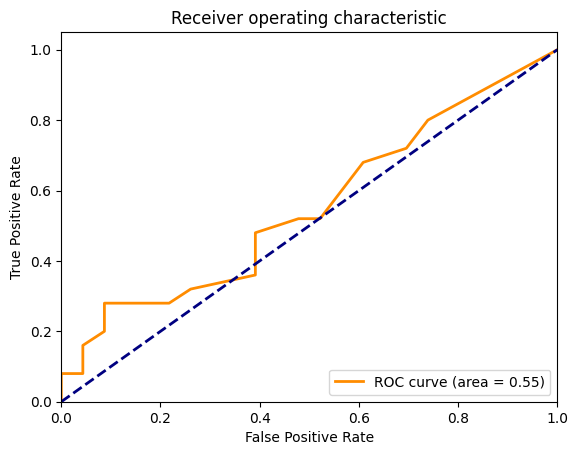

min bootstrapping aucroc:
0.2675521821631879
max bootstrapping aucroc:
0.8306878306878307
p_onesided = 0
p_twosided = 0
boots_mean_AUCROC =
0.552041337521148(0.38796296296296295,0.7095652173913043)

...END AUCROC
BEGIN LOADING KSADS...

...FINISH LOADING KSADS
BEGIN LOADING CBCL, anx/dep or with/dep...
...FINISH LOADING CBCL, anx/dep or with/dep...
BEGIN MERGING...
...FINISH MERGING
BEGIN PREPROCESSING...

Last check of missing data. Non-null rows = 0

Check that positives and negatives dont overlap
Index([], dtype='object', name='src_subject_id')
FINAL Number of positives in the data n=71
Number of negatives in the data (before subsampling) n=118
Overall sample size (before subsampling) n=189
Not enough negative samples to use the desired neg/pos rate. Using all negative samples
FINAL Number of negatives in the data (after subsampling) n=118
FINAL Overall sample size (before subsampling) n=189
demo_sex_v2
2.0    144
1.0     45
Name: count, dtype: int64
Positive girls in sample = 49
Po

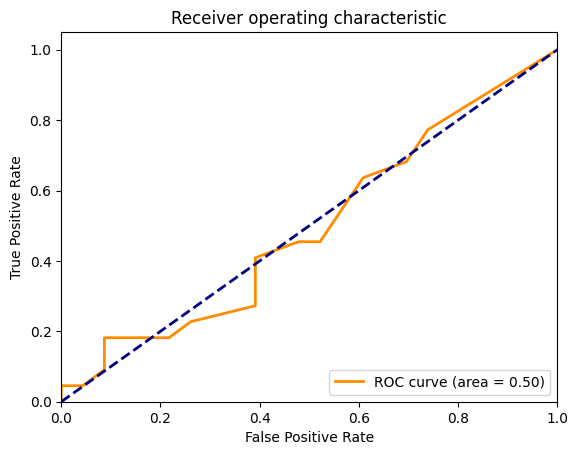

min bootstrapping aucroc:
0.208
max bootstrapping aucroc:
0.734189723320158
p_onesided = 0
p_twosided = 0
boots_mean_AUCROC =
0.4926190885825753(0.32219827586206895,0.6551383399209487)

...END AUCROC
BEGIN LOADING KSADS...

...FINISH LOADING KSADS
BEGIN LOADING CBCL, anx/dep or with/dep...
...FINISH LOADING CBCL, anx/dep or with/dep...
BEGIN MERGING...
...FINISH MERGING
BEGIN PREPROCESSING...

Last check of missing data. Non-null rows = 0

Check that positives and negatives dont overlap
Index([], dtype='object', name='src_subject_id')
FINAL Number of positives in the data n=96
Number of negatives in the data (before subsampling) n=10683
Overall sample size (before subsampling) n=10779
FINAL Number of negatives in the data (after subsampling) n=864
FINAL Overall sample size (before subsampling) n=960

...END PREPROCESSING

START ANALYSIS


Input Data: CBCL anx/dex or with/dep
Scale: withdrawndep
Wave: optimal
Ksads Reporter: child
Hypothesis: 1
Sex: both
BEGIN AUCROC...

Single AUCROC s

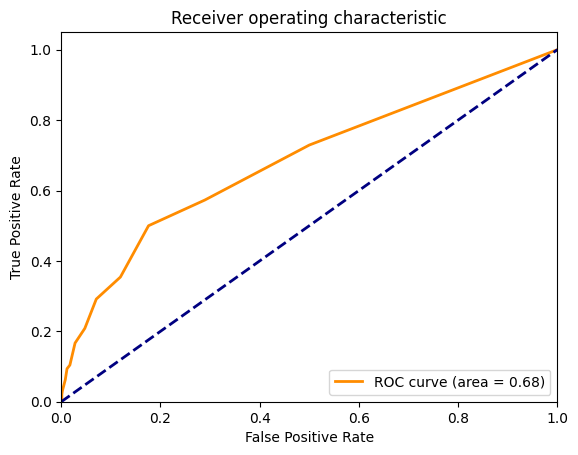

min bootstrapping aucroc:
0.5714009287925697
max bootstrapping aucroc:
0.7718817397555715
p_onesided = 0
p_twosided = 0
boots_mean_AUCROC =
0.6823931964380386(0.6184172453703702,0.739061684924361)

...END AUCROC
BEGIN LOADING KSADS...

...FINISH LOADING KSADS
BEGIN LOADING CBCL, anx/dep or with/dep...
...FINISH LOADING CBCL, anx/dep or with/dep...
BEGIN MERGING...
...FINISH MERGING
BEGIN PREPROCESSING...

Last check of missing data. Non-null rows = 0

Check that positives and negatives dont overlap
Index([], dtype='object', name='src_subject_id')
FINAL Number of positives in the data n=96
Number of negatives in the data (before subsampling) n=118
Overall sample size (before subsampling) n=214
Not enough negative samples to use the desired neg/pos rate. Using all negative samples
FINAL Number of negatives in the data (after subsampling) n=118
FINAL Overall sample size (before subsampling) n=214

...END PREPROCESSING

START ANALYSIS


Input Data: CBCL anx/dex or with/dep
Scale: withdrawn

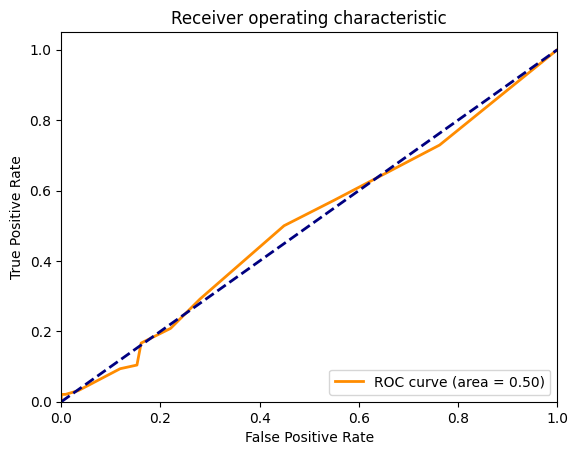

min bootstrapping aucroc:
0.3734802763928977
max bootstrapping aucroc:
0.6453373015873016
p_onesided = 0
p_twosided = 0
boots_mean_AUCROC =
0.5020416896406094(0.42385321100917434,0.5795175438596492)

...END AUCROC
BEGIN LOADING KSADS...

...FINISH LOADING KSADS
BEGIN LOADING CBCL, anx/dep or with/dep...
...FINISH LOADING CBCL, anx/dep or with/dep...
BEGIN MERGING...
...FINISH MERGING
BEGIN PREPROCESSING...

Last check of missing data. Non-null rows = 0

Check that positives and negatives dont overlap
Index([], dtype='object', name='src_subject_id')
FINAL Number of positives in the data n=71
Number of negatives in the data (before subsampling) n=118
Overall sample size (before subsampling) n=189
Not enough negative samples to use the desired neg/pos rate. Using all negative samples
FINAL Number of negatives in the data (after subsampling) n=118
FINAL Overall sample size (before subsampling) n=189

...END PREPROCESSING

START ANALYSIS


Input Data: CBCL anx/dex or with/dep
Scale: withdra

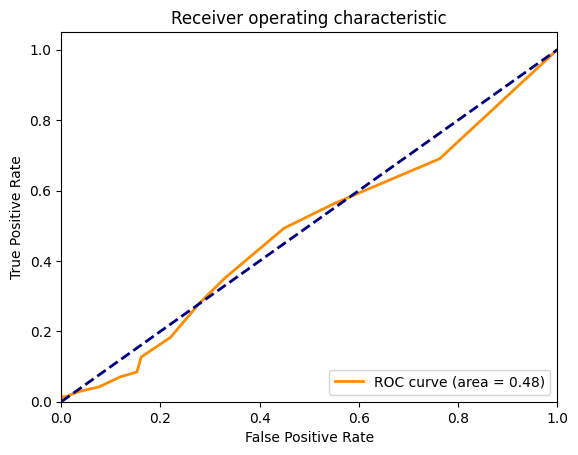

min bootstrapping aucroc:
0.326507049100632
max bootstrapping aucroc:
0.6144927536231883
p_onesided = 0
p_twosided = 0
boots_mean_AUCROC =
0.4866720801343149(0.40561536579398094,0.5732431149097816)

...END AUCROC
BEGIN LOADING KSADS...

...FINISH LOADING KSADS
BEGIN LOADING CBCL, anx/dep or with/dep...
...FINISH LOADING CBCL, anx/dep or with/dep...
BEGIN MERGING...
...FINISH MERGING
BEGIN PREPROCESSING...

Last check of missing data. Non-null rows = 0

Check that positives and negatives dont overlap
Index([], dtype='object', name='src_subject_id')
FINAL Number of positives in the data n=96
Number of negatives in the data (before subsampling) n=10683
Overall sample size (before subsampling) n=10779
FINAL Number of negatives in the data (after subsampling) n=864
FINAL Overall sample size (before subsampling) n=960
demo_sex_v2
1.0    493
2.0    467
Name: count, dtype: int64
Positive girls in sample = 71
Positive boys in sample = 25

...END PREPROCESSING

START ANALYSIS


Input Data: CBCL 

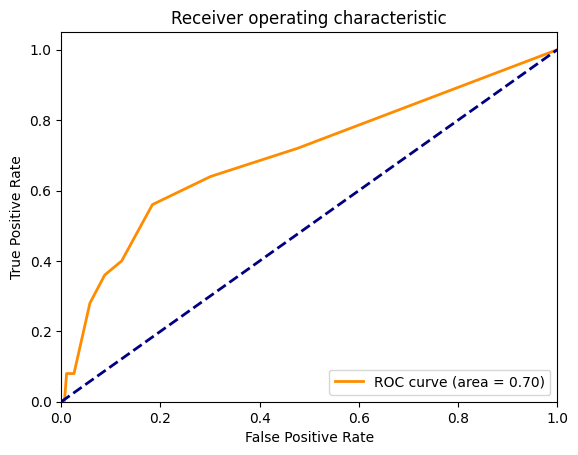

min bootstrapping aucroc:
0.516049953746531
max bootstrapping aucroc:
0.8943674484719261
p_onesided = 0
p_twosided = 0
boots_mean_AUCROC =
0.6957413000873008(0.5784055345083181,0.8068397505422993)

...END AUCROC
BEGIN LOADING KSADS...

...FINISH LOADING KSADS
BEGIN LOADING CBCL, anx/dep or with/dep...
...FINISH LOADING CBCL, anx/dep or with/dep...
BEGIN MERGING...
...FINISH MERGING
BEGIN PREPROCESSING...

Last check of missing data. Non-null rows = 0

Check that positives and negatives dont overlap
Index([], dtype='object', name='src_subject_id')
FINAL Number of positives in the data n=96
Number of negatives in the data (before subsampling) n=118
Overall sample size (before subsampling) n=214
Not enough negative samples to use the desired neg/pos rate. Using all negative samples
FINAL Number of negatives in the data (after subsampling) n=118
FINAL Overall sample size (before subsampling) n=214
demo_sex_v2
2.0    166
1.0     48
Name: count, dtype: int64
Positive girls in sample = 71
Pos

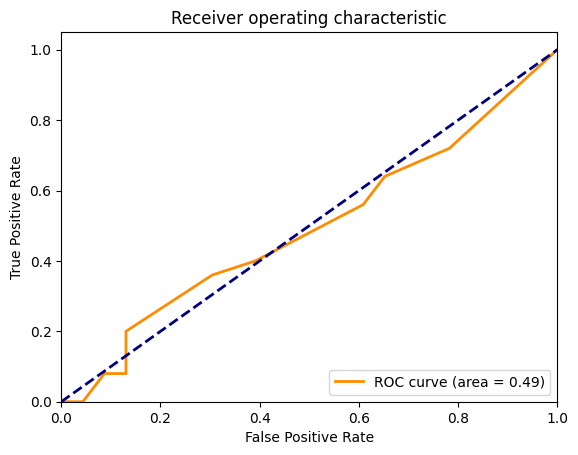

min bootstrapping aucroc:
0.23842592592592593
max bootstrapping aucroc:
0.7660869565217392
p_onesided = 0
p_twosided = 0
boots_mean_AUCROC =
0.4950630105075678(0.3277777777777778,0.6547826086956521)

...END AUCROC
BEGIN LOADING KSADS...

...FINISH LOADING KSADS
BEGIN LOADING CBCL, anx/dep or with/dep...
...FINISH LOADING CBCL, anx/dep or with/dep...
BEGIN MERGING...
...FINISH MERGING
BEGIN PREPROCESSING...

Last check of missing data. Non-null rows = 0

Check that positives and negatives dont overlap
Index([], dtype='object', name='src_subject_id')
FINAL Number of positives in the data n=71
Number of negatives in the data (before subsampling) n=118
Overall sample size (before subsampling) n=189
Not enough negative samples to use the desired neg/pos rate. Using all negative samples
FINAL Number of negatives in the data (after subsampling) n=118
FINAL Overall sample size (before subsampling) n=189
demo_sex_v2
2.0    144
1.0     45
Name: count, dtype: int64
Positive girls in sample = 49
P

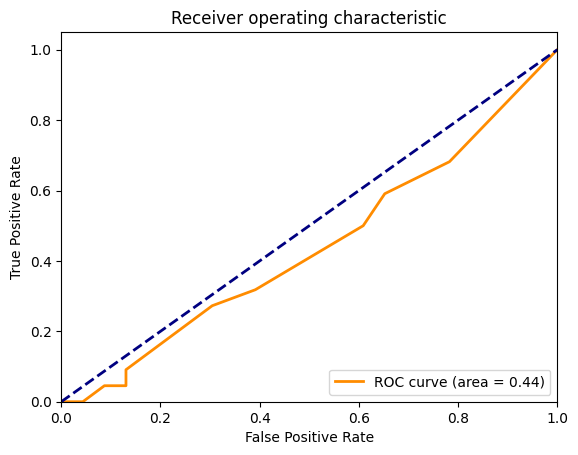

min bootstrapping aucroc:
0.17658730158730157
max bootstrapping aucroc:
0.7316810344827586
p_onesided = 0
p_twosided = 0
boots_mean_AUCROC =
0.4386211210991732(0.2737154150197628,0.6049382716049383)

...END AUCROC
BEGIN LOADING KSADS...

...FINISH LOADING KSADS
BEGIN LOADING CBCL, anx/dep or with/dep...
...FINISH LOADING CBCL, anx/dep or with/dep...
BEGIN MERGING...
...FINISH MERGING
BEGIN PREPROCESSING...

Last check of missing data. Non-null rows = 0

Check that positives and negatives dont overlap
Index([], dtype='object', name='src_subject_id')
FINAL Number of positives in the data n=96
Number of negatives in the data (before subsampling) n=10683
Overall sample size (before subsampling) n=10779
FINAL Number of negatives in the data (after subsampling) n=864
FINAL Overall sample size (before subsampling) n=960
demo_sex_v2
1.0    491
2.0    469
Name: count, dtype: int64
Positive girls in sample = 71
Positive boys in sample = 25

...END PREPROCESSING

START ANALYSIS


Input Data: CBCL

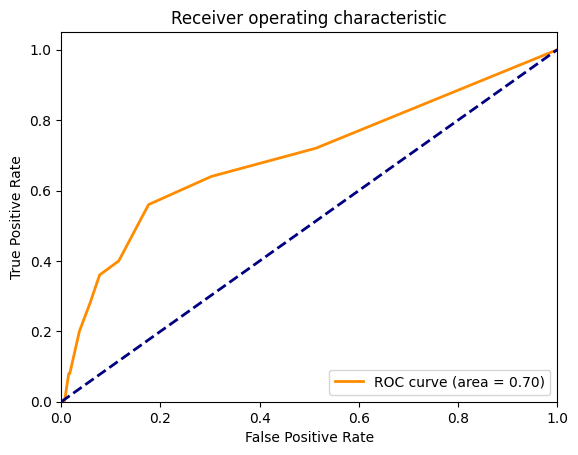

min bootstrapping aucroc:
0.4713815789473684
max bootstrapping aucroc:
0.8843335390311633
p_onesided = 0
p_twosided = 0
boots_mean_AUCROC =
0.6966667751987133(0.5735557545902373,0.8108354011579818)

...END AUCROC
BEGIN LOADING KSADS...

...FINISH LOADING KSADS
BEGIN LOADING CBCL, anx/dep or with/dep...
...FINISH LOADING CBCL, anx/dep or with/dep...
BEGIN MERGING...
...FINISH MERGING
BEGIN PREPROCESSING...

Last check of missing data. Non-null rows = 0

Check that positives and negatives dont overlap
Index([], dtype='object', name='src_subject_id')
FINAL Number of positives in the data n=96
Number of negatives in the data (before subsampling) n=118
Overall sample size (before subsampling) n=214
Not enough negative samples to use the desired neg/pos rate. Using all negative samples
FINAL Number of negatives in the data (after subsampling) n=118
FINAL Overall sample size (before subsampling) n=214
demo_sex_v2
2.0    166
1.0     48
Name: count, dtype: int64
Positive girls in sample = 71
Po

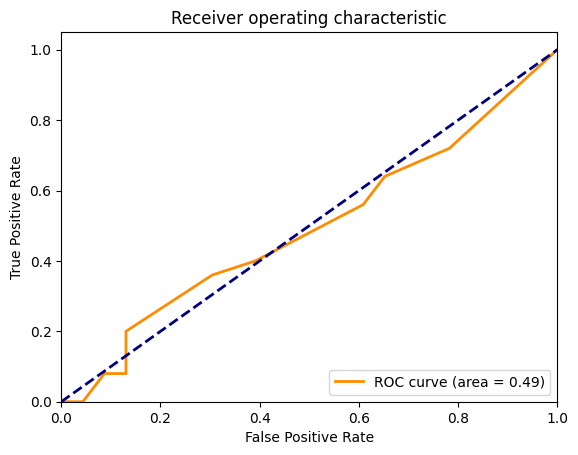

min bootstrapping aucroc:
0.2654320987654321
max bootstrapping aucroc:
0.7741071428571429
p_onesided = 0
p_twosided = 0
boots_mean_AUCROC =
0.4991754376725062(0.34391534391534395,0.6579861111111112)

...END AUCROC
BEGIN LOADING KSADS...

...FINISH LOADING KSADS
BEGIN LOADING CBCL, anx/dep or with/dep...
...FINISH LOADING CBCL, anx/dep or with/dep...
BEGIN MERGING...
...FINISH MERGING
BEGIN PREPROCESSING...

Last check of missing data. Non-null rows = 0

Check that positives and negatives dont overlap
Index([], dtype='object', name='src_subject_id')
FINAL Number of positives in the data n=71
Number of negatives in the data (before subsampling) n=118
Overall sample size (before subsampling) n=189
Not enough negative samples to use the desired neg/pos rate. Using all negative samples
FINAL Number of negatives in the data (after subsampling) n=118
FINAL Overall sample size (before subsampling) n=189
demo_sex_v2
2.0    144
1.0     45
Name: count, dtype: int64
Positive girls in sample = 49
P

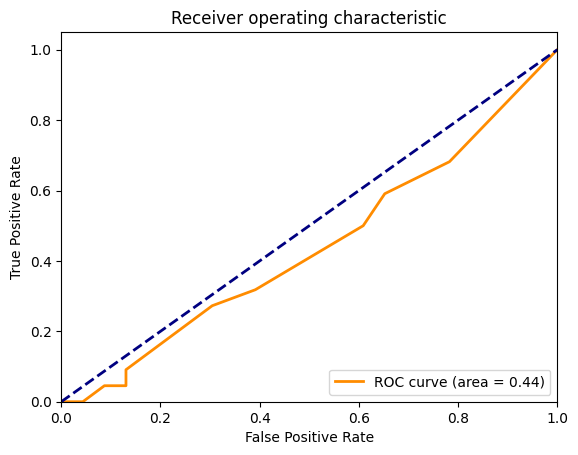

min bootstrapping aucroc:
0.15999999999999998
max bootstrapping aucroc:
0.7540485829959515
p_onesided = 0
p_twosided = 0
boots_mean_AUCROC =
0.43490317816124274(0.26778656126482214,0.5931174089068827)

...END AUCROC
END ALL


In [125]:
# MAIN CODE FOR ANXDEP/WITHDEP
# only cbcl, not ysr

Input_data = 'cbcl'
Wave = ['baseline', 'optimal']
Reporter = ['parent', 'child']
Scale = ['anxiousdep', 'withdrawndep']
Sex = ['both', 'boys', 'girls']
Hypothesis = ['1', '2a', '2b']

for wave in Wave:
    for reporter in Reporter:
        for scale in Scale:
            for sex in Sex:
                for hypothesis in Hypothesis:
                    data_ksads = load_ksads(path_to_data, reporter = reporter, wave = wave, do_print = False)
                    data_input = load_cbcl_anxdep_withdep(path_to_data, wave = wave, scale = scale, do_print = False)
                    data_merged = merge_my_data(data_input, data_ksads)     
                    data_ready = preprocess_data(data_merged, percent_positives = 10, hypothesis = hypothesis, sex = sex)
                    # STARTING ANALYSIS
                    print('\nSTART ANALYSIS\n')
                    print('\nInput Data: CBCL anx/dex or with/dep')
                    print('Scale: %s' % scale)
                    print('Wave: %s' % wave)
                    print('Ksads Reporter: %s' % reporter)
                    print('Hypothesis: %s' % hypothesis) 
                    print('Sex: %s' % sex)
                    if hypothesis in ['1', '2a']:
                        Target_auc = 0.8 # [TODO] NEED TO DOUBLE CHECK THIS WITH SAMPLE SIZE ESTIMATION ETC
                    elif hypothesis == '2b':
                        Target_auc = 0.7 # [TODO] NEED TO DOUBLE CHECK THIS WITH SAMPLE SIZE ESTIMATION ETC
                    fig_file_name = 'ABCD_'+Input_data+scale+'_'+hypothesis+'_'+reporter+'_'+wave+'_'+sex
                    try:
                        y_true,y_measure, b_AUCROC, q25, q75 = run_aucroc_and_plot(data_ready, 
                                                            path_to_save_plots='../plotting/plot_data/', 
                                                            name_to_save=fig_file_name, 
                                                            mymeasure = Input_data, 
                                                            hypothesis = hypothesis,
                                                            nboots=100, 
                                                            target_auc=Target_auc,
                                                            do_print = False)
                    except:
                        pass
print('END ALL')

# Use this code to create a csv with output


Input Data: ysr
Wave: Always optimal
Ksads Reporter: parent
Hypothesis: 1
Sex: girls


BEGIN LOADING KSADS...

...FINISH LOADING KSADS
BEGIN LOADING YSR...
...FINISH LOADING YSR
BEGIN MERGING...
...FINISH MERGING
BEGIN PREPROCESSING...

Last check of missing data. Non-null rows = 0

Check that positives and negatives dont overlap
Index([], dtype='object', name='src_subject_id')
FINAL Number of positives in the data n=81
Number of negatives in the data (before subsampling) n=10199
Overall sample size (before subsampling) n=10280
FINAL Number of negatives in the data (after subsampling) n=729
FINAL Overall sample size (before subsampling) n=810
demo_sex_v2
1.0    417
2.0    393
Name: count, dtype: int64
Positive girls in sample = 44
Positive boys in sample = 37

...END PREPROCESSING

FINISHED DATA PREP


START ANALYSIS


Input Data: ysr
Wave: optimal
Ksads Reporter: parent
Hypothesis: 1
Sex: girls
BEGIN AUCROC...

Single AUCROC score without bootstrapping:
0.7009246088193457


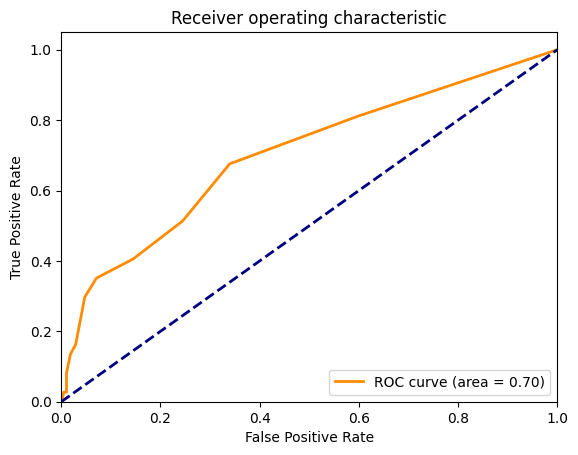

min bootstrapping aucroc:
0.5360892388451444
max bootstrapping aucroc:
0.8382294429708224
p_onesided = 0

Target_AUC = 0
p_twosided_1 = 0
p_twosided_2 = 0
p_twosided = 0
boots_mean_AUCROC =
0.6994382403202878(0.6026349206349206,0.7827880512091039)

...END AUCROC

FINISH


Input Data: ysr
Wave: Always optimal
Ksads Reporter: parent
Hypothesis: 2a
Sex: girls


BEGIN LOADING KSADS...

...FINISH LOADING KSADS
BEGIN LOADING YSR...
...FINISH LOADING YSR
BEGIN MERGING...
...FINISH MERGING
BEGIN PREPROCESSING...

Last check of missing data. Non-null rows = 0

Check that positives and negatives dont overlap
Index([], dtype='object', name='src_subject_id')
FINAL Number of positives in the data n=81
Number of negatives in the data (before subsampling) n=1297
Overall sample size (before subsampling) n=1378
FINAL Number of negatives in the data (after subsampling) n=729
FINAL Overall sample size (before subsampling) n=810
demo_sex_v2
1.0    461
2.0    347
3.0      1
Name: count, dtype: int64
Positi

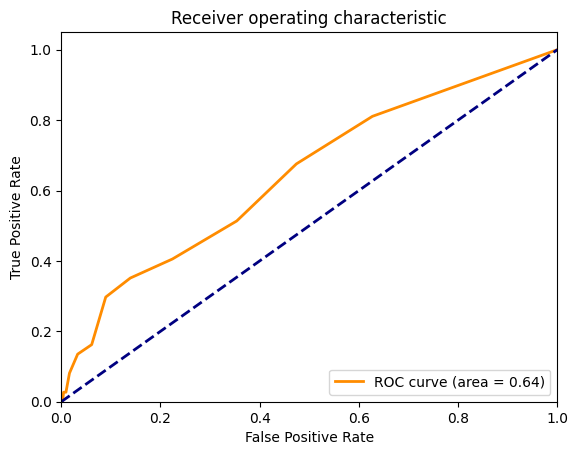

min bootstrapping aucroc:
0.48768054375531006
max bootstrapping aucroc:
0.7711526181353767
p_onesided = 0

Target_AUC = 0
p_twosided_1 = 0
p_twosided_2 = 1
p_twosided = 0
boots_mean_AUCROC =
0.645137543828748(0.5487315145334013,0.7357205144974929)

...END AUCROC

FINISH


Input Data: ysr
Wave: Always optimal
Ksads Reporter: parent
Hypothesis: 2b
Sex: girls


BEGIN LOADING KSADS...

...FINISH LOADING KSADS
BEGIN LOADING YSR...
...FINISH LOADING YSR
BEGIN MERGING...
...FINISH MERGING
BEGIN PREPROCESSING...

Last check of missing data. Non-null rows = 0

Check that positives and negatives dont overlap
Index([], dtype='object', name='src_subject_id')
FINAL Number of positives in the data n=32
Number of negatives in the data (before subsampling) n=1297
Overall sample size (before subsampling) n=1329
FINAL Number of negatives in the data (after subsampling) n=288
FINAL Overall sample size (before subsampling) n=320
demo_sex_v2
1.0    169
2.0    150
3.0      1
Name: count, dtype: int64
Positi

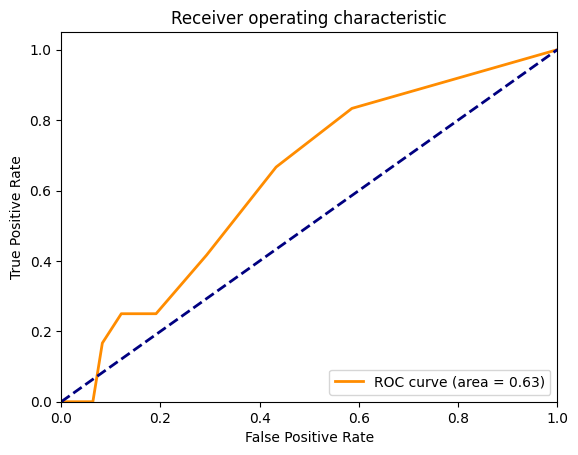

min bootstrapping aucroc:
0.3647798742138365
max bootstrapping aucroc:
0.8666666666666666
p_onesided = 0

Target_AUC = 0
p_twosided_1 = 0
p_twosided_2 = 0
p_twosided = 0
boots_mean_AUCROC =
0.6257391539110068(0.4607583774250441,0.7729559748427672)

...END AUCROC

FINISH


Input Data: ysr
Wave: Always optimal
Ksads Reporter: child
Hypothesis: 1
Sex: girls


BEGIN LOADING KSADS...

...FINISH LOADING KSADS
BEGIN LOADING YSR...
...FINISH LOADING YSR
BEGIN MERGING...
...FINISH MERGING
BEGIN PREPROCESSING...

Last check of missing data. Non-null rows = 0

Check that positives and negatives dont overlap
Index([], dtype='object', name='src_subject_id')
FINAL Number of positives in the data n=84
Number of negatives in the data (before subsampling) n=10332
Overall sample size (before subsampling) n=10416
FINAL Number of negatives in the data (after subsampling) n=756
FINAL Overall sample size (before subsampling) n=840
demo_sex_v2
1.0    421
2.0    418
Name: count, dtype: int64
Positive girls in

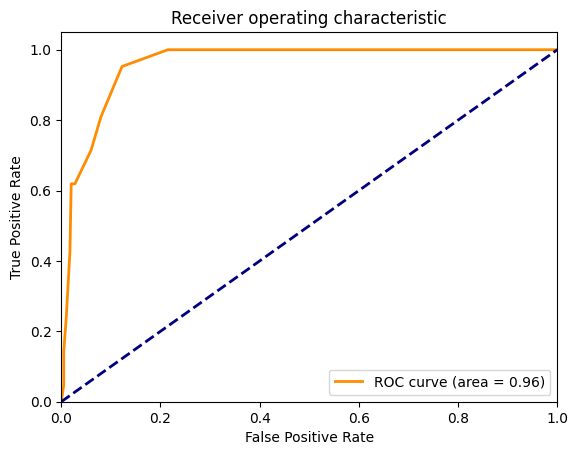

min bootstrapping aucroc:
0.9113958560523446
max bootstrapping aucroc:
0.9876847290640394
p_onesided = 1

Target_AUC = 0
p_twosided_1 = 1
p_twosided_2 = 0
p_twosided = 0
boots_mean_AUCROC =
0.9588490769592352(0.9321811992668239,0.9799031159989525)

...END AUCROC

FINISH


Input Data: ysr
Wave: Always optimal
Ksads Reporter: child
Hypothesis: 2a
Sex: girls


BEGIN LOADING KSADS...

...FINISH LOADING KSADS
BEGIN LOADING YSR...
...FINISH LOADING YSR
BEGIN MERGING...
...FINISH MERGING
BEGIN PREPROCESSING...

Last check of missing data. Non-null rows = 0

Check that positives and negatives dont overlap
Index([], dtype='object', name='src_subject_id')
FINAL Number of positives in the data n=84
Number of negatives in the data (before subsampling) n=112
Overall sample size (before subsampling) n=196
Not enough negative samples to use the desired neg/pos rate. Using all negative samples
FINAL Number of negatives in the data (after subsampling) n=112
FINAL Overall sample size (before subsampling

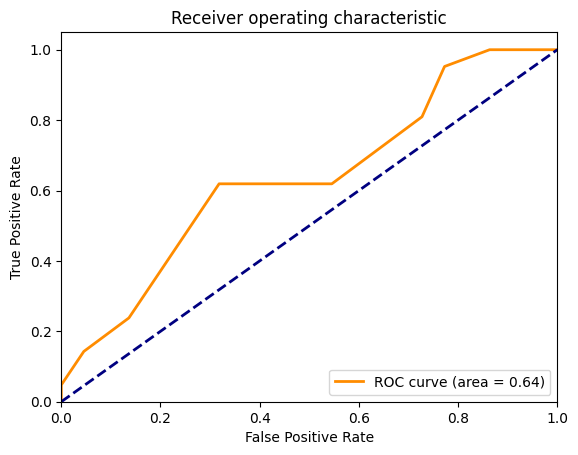

min bootstrapping aucroc:
0.35526315789473684
max bootstrapping aucroc:
0.8945652173913043
p_onesided = 0

Target_AUC = 0
p_twosided_1 = 0
p_twosided_2 = 0
p_twosided = 0
boots_mean_AUCROC =
0.6362558411719281(0.46645021645021645,0.787878787878788)

...END AUCROC

FINISH


Input Data: ysr
Wave: Always optimal
Ksads Reporter: child
Hypothesis: 2b
Sex: girls


BEGIN LOADING KSADS...

...FINISH LOADING KSADS
BEGIN LOADING YSR...
...FINISH LOADING YSR
BEGIN MERGING...
...FINISH MERGING
BEGIN PREPROCESSING...

Last check of missing data. Non-null rows = 0

Check that positives and negatives dont overlap
Index([], dtype='object', name='src_subject_id')
FINAL Number of positives in the data n=61
Number of negatives in the data (before subsampling) n=112
Overall sample size (before subsampling) n=173
Not enough negative samples to use the desired neg/pos rate. Using all negative samples
FINAL Number of negatives in the data (after subsampling) n=112
FINAL Overall sample size (before subsamplin

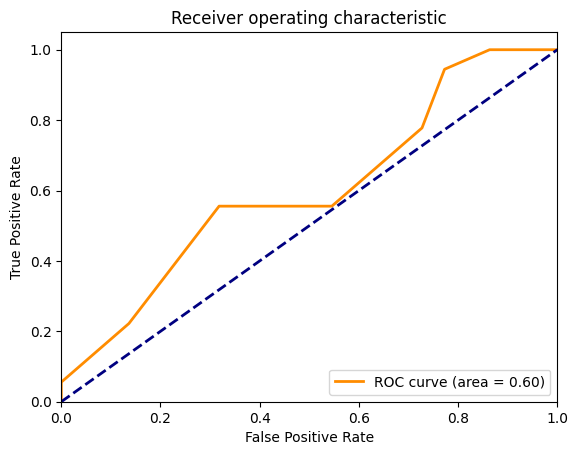

min bootstrapping aucroc:
0.24552429667519182
max bootstrapping aucroc:
0.8632478632478633
p_onesided = 0

Target_AUC = 0
p_twosided_1 = 0
p_twosided_2 = 0
p_twosided = 0
boots_mean_AUCROC =
0.6013408046509552(0.4335839598997494,0.7727272727272727)

...END AUCROC

FINISH


Input Data: cbcl
Wave: baseline
Ksads Reporter: parent
Hypothesis: 1
Sex: girls


BEGIN LOADING KSADS...

...FINISH LOADING KSADS
BEGIN LOADING CBCL...
...FINISH LOADING CBCL
BEGIN MERGING...
...FINISH MERGING
BEGIN PREPROCESSING...

Last check of missing data. Non-null rows = 0

Check that positives and negatives dont overlap
Index([], dtype='object', name='src_subject_id')
FINAL Number of positives in the data n=30
Number of negatives in the data (before subsampling) n=6154
Overall sample size (before subsampling) n=6184
FINAL Number of negatives in the data (after subsampling) n=270
FINAL Overall sample size (before subsampling) n=300
demo_sex_v2
2.0    156
1.0    144
Name: count, dtype: int64
Positive girls in sa

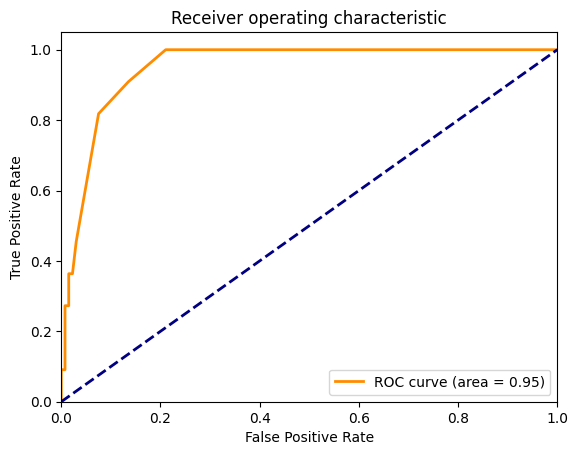

min bootstrapping aucroc:
0.8286713286713286
max bootstrapping aucroc:
0.9981617647058824
p_onesided = 1

Target_AUC = 0
p_twosided_1 = 1
p_twosided_2 = 0
p_twosided = 0
boots_mean_AUCROC =
0.9514209286220517(0.9087752525252525,0.9855072463768116)

...END AUCROC

FINISH


Input Data: cbcl
Wave: optimal
Ksads Reporter: parent
Hypothesis: 1
Sex: girls


BEGIN LOADING KSADS...

...FINISH LOADING KSADS
BEGIN LOADING CBCL...
...FINISH LOADING CBCL
BEGIN MERGING...
...FINISH MERGING
BEGIN PREPROCESSING...

Last check of missing data. Non-null rows = 0

Check that positives and negatives dont overlap
Index([], dtype='object', name='src_subject_id')
FINAL Number of positives in the data n=83
Number of negatives in the data (before subsampling) n=10618
Overall sample size (before subsampling) n=10701
FINAL Number of negatives in the data (after subsampling) n=747
FINAL Overall sample size (before subsampling) n=830
demo_sex_v2
1.0    436
2.0    393
Name: count, dtype: int64
Positive girls in sa

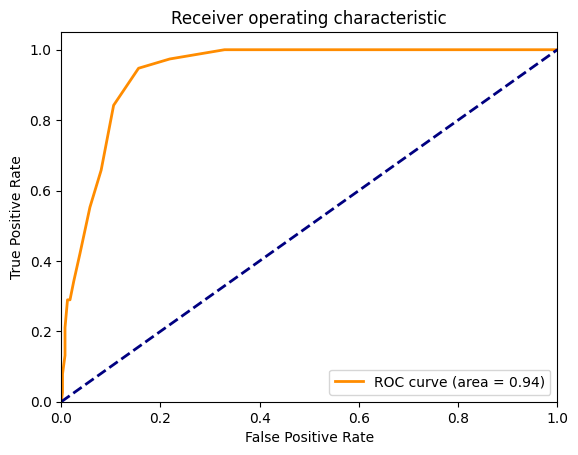

min bootstrapping aucroc:
0.8954982884453917
max bootstrapping aucroc:
0.9782704126426689
p_onesided = 1

Target_AUC = 0
p_twosided_1 = 1
p_twosided_2 = 0
p_twosided = 0
boots_mean_AUCROC =
0.9383055997745517(0.9108656929105806,0.9605628785179907)

...END AUCROC

FINISH


Input Data: cbcl
Wave: baseline
Ksads Reporter: parent
Hypothesis: 2a
Sex: girls


BEGIN LOADING KSADS...

...FINISH LOADING KSADS
BEGIN LOADING CBCL...
...FINISH LOADING CBCL
BEGIN MERGING...
...FINISH MERGING
BEGIN PREPROCESSING...

Last check of missing data. Non-null rows = 0

Check that positives and negatives dont overlap
Index([], dtype='object', name='src_subject_id')
FINAL Number of positives in the data n=30
Number of negatives in the data (before subsampling) n=999
Overall sample size (before subsampling) n=1029
FINAL Number of negatives in the data (after subsampling) n=270
FINAL Overall sample size (before subsampling) n=300
demo_sex_v2
1.0    175
2.0    125
Name: count, dtype: int64
Positive girls in sam

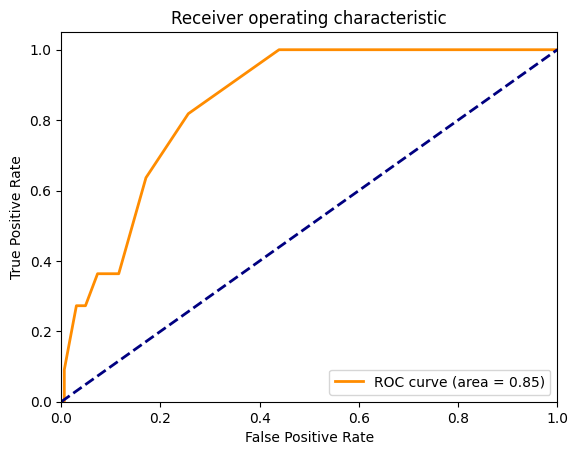

min bootstrapping aucroc:
0.6563116370808678
max bootstrapping aucroc:
0.9692101740294512
p_onesided = 0

Target_AUC = 0
p_twosided_1 = 0
p_twosided_2 = 0
p_twosided = 0
boots_mean_AUCROC =
0.849027339389562(0.759861932938856,0.9268707482993197)

...END AUCROC

FINISH


Input Data: cbcl
Wave: optimal
Ksads Reporter: parent
Hypothesis: 2a
Sex: girls


BEGIN LOADING KSADS...

...FINISH LOADING KSADS
BEGIN LOADING CBCL...
...FINISH LOADING CBCL
BEGIN MERGING...
...FINISH MERGING
BEGIN PREPROCESSING...

Last check of missing data. Non-null rows = 0

Check that positives and negatives dont overlap
Index([], dtype='object', name='src_subject_id')
FINAL Number of positives in the data n=83
Number of negatives in the data (before subsampling) n=1372
Overall sample size (before subsampling) n=1455
FINAL Number of negatives in the data (after subsampling) n=747
FINAL Overall sample size (before subsampling) n=830
demo_sex_v2
1.0    460
2.0    369
Name: count, dtype: int64
Positive girls in sampl

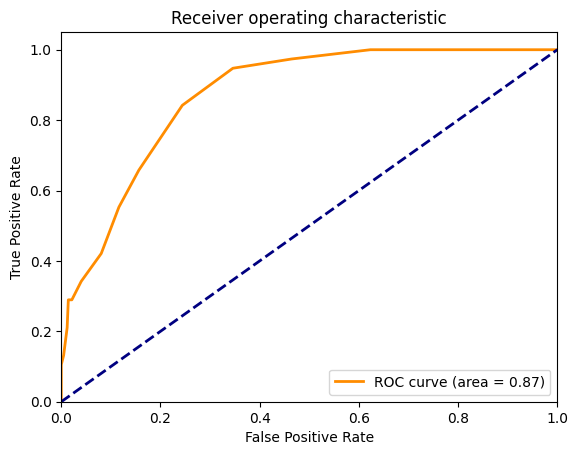

min bootstrapping aucroc:
0.7974735126324368
max bootstrapping aucroc:
0.9426206896551723
p_onesided = 0

Target_AUC = 0
p_twosided_1 = 0
p_twosided_2 = 0
p_twosided = 0
boots_mean_AUCROC =
0.8721124231424001(0.8243634259259259,0.9132323813174876)

...END AUCROC

FINISH


Input Data: cbcl
Wave: baseline
Ksads Reporter: parent
Hypothesis: 2b
Sex: girls


BEGIN LOADING KSADS...

...FINISH LOADING KSADS
BEGIN LOADING CBCL...
...FINISH LOADING CBCL
BEGIN MERGING...
...FINISH MERGING
BEGIN PREPROCESSING...

Last check of missing data. Non-null rows = 0

Check that positives and negatives dont overlap
Index([], dtype='object', name='src_subject_id')
FINAL Number of positives in the data n=11
Number of negatives in the data (before subsampling) n=999
Overall sample size (before subsampling) n=1010
FINAL Number of negatives in the data (after subsampling) n=99
FINAL Overall sample size (before subsampling) n=110
demo_sex_v2
1.0    57
2.0    53
Name: count, dtype: int64
Positive girls in sample

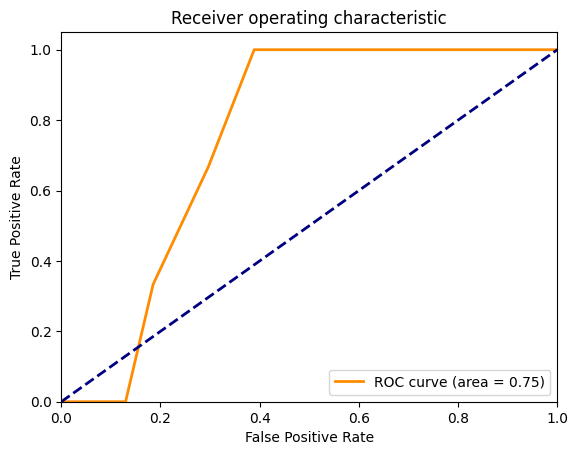


FINISH


Input Data: cbcl
Wave: optimal
Ksads Reporter: parent
Hypothesis: 2b
Sex: girls


BEGIN LOADING KSADS...

...FINISH LOADING KSADS
BEGIN LOADING CBCL...
...FINISH LOADING CBCL
BEGIN MERGING...
...FINISH MERGING
BEGIN PREPROCESSING...

Last check of missing data. Non-null rows = 0

Check that positives and negatives dont overlap
Index([], dtype='object', name='src_subject_id')
FINAL Number of positives in the data n=33
Number of negatives in the data (before subsampling) n=1372
Overall sample size (before subsampling) n=1405
FINAL Number of negatives in the data (after subsampling) n=297
FINAL Overall sample size (before subsampling) n=330
demo_sex_v2
1.0    173
2.0    156
Name: count, dtype: int64
Positive girls in sample = 21
Positive boys in sample = 12

...END PREPROCESSING

FINISHED DATA PREP


START ANALYSIS


Input Data: cbcl
Wave: optimal
Ksads Reporter: parent
Hypothesis: 2b
Sex: girls
BEGIN AUCROC...

Single AUCROC score without bootstrapping:
0.8162525879917184


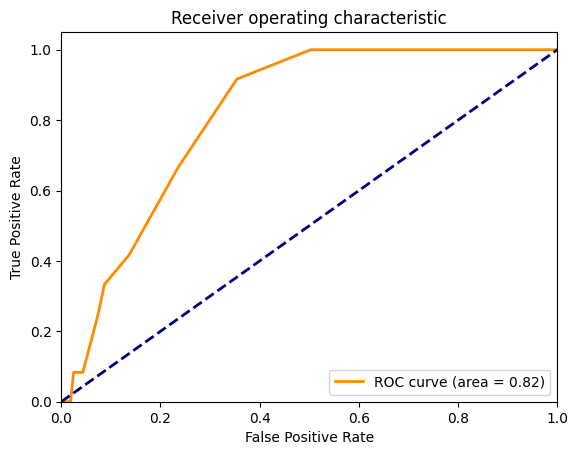

min bootstrapping aucroc:
0.6411359724612736
max bootstrapping aucroc:
0.9471057884231537
p_onesided = 0

Target_AUC = 0
p_twosided_1 = 0
p_twosided_2 = 0
p_twosided = 0
boots_mean_AUCROC =
0.8155383583035564(0.725609756097561,0.8902691511387164)

...END AUCROC

FINISH


Input Data: cbcl
Wave: baseline
Ksads Reporter: child
Hypothesis: 1
Sex: girls


BEGIN LOADING KSADS...

...FINISH LOADING KSADS
BEGIN LOADING CBCL...
...FINISH LOADING CBCL
BEGIN MERGING...
...FINISH MERGING
BEGIN PREPROCESSING...

Last check of missing data. Non-null rows = 0

Check that positives and negatives dont overlap
Index([], dtype='object', name='src_subject_id')
FINAL Number of positives in the data n=119
Number of negatives in the data (before subsampling) n=11666
Overall sample size (before subsampling) n=11785
FINAL Number of negatives in the data (after subsampling) n=1071
FINAL Overall sample size (before subsampling) n=1190
demo_sex_v2
1.0    613
2.0    576
Name: count, dtype: int64
Positive girls in 

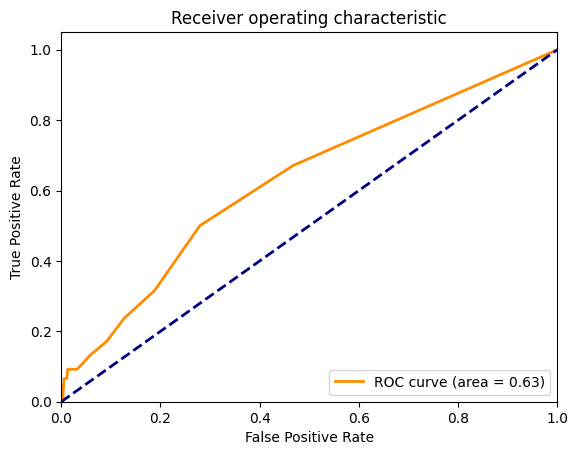

min bootstrapping aucroc:
0.5257885763000852
max bootstrapping aucroc:
0.7364414192772402
p_onesided = 0

Target_AUC = 0
p_twosided_1 = 0
p_twosided_2 = 1
p_twosided = 0
boots_mean_AUCROC =
0.6270460690796352(0.5614665708123652,0.6861018286456882)

...END AUCROC

FINISH


Input Data: cbcl
Wave: optimal
Ksads Reporter: child
Hypothesis: 1
Sex: girls


BEGIN LOADING KSADS...

...FINISH LOADING KSADS
BEGIN LOADING CBCL...
...FINISH LOADING CBCL
BEGIN MERGING...
...FINISH MERGING
BEGIN PREPROCESSING...

Last check of missing data. Non-null rows = 0

Check that positives and negatives dont overlap
Index([], dtype='object', name='src_subject_id')
FINAL Number of positives in the data n=96
Number of negatives in the data (before subsampling) n=10683
Overall sample size (before subsampling) n=10779
FINAL Number of negatives in the data (after subsampling) n=864
FINAL Overall sample size (before subsampling) n=960
demo_sex_v2
1.0    498
2.0    460
Name: count, dtype: int64
Positive girls in sam

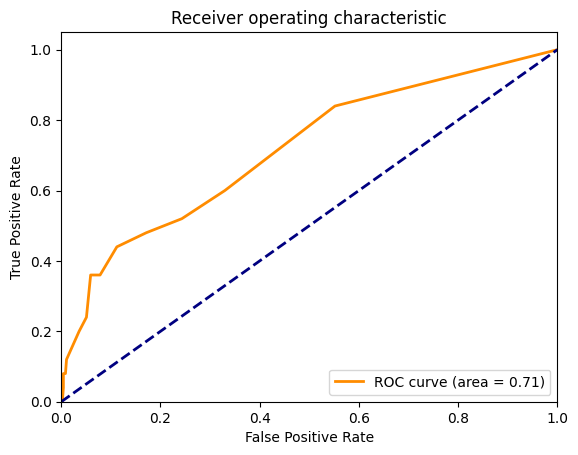

min bootstrapping aucroc:
0.4912615740740741
max bootstrapping aucroc:
0.8913075560802833
p_onesided = 0

Target_AUC = 0
p_twosided_1 = 0
p_twosided_2 = 0
p_twosided = 0
boots_mean_AUCROC =
0.7151018147435894(0.6008797653958944,0.8160640732265446)

...END AUCROC

FINISH


Input Data: cbcl
Wave: baseline
Ksads Reporter: child
Hypothesis: 2a
Sex: girls


BEGIN LOADING KSADS...

...FINISH LOADING KSADS
BEGIN LOADING CBCL...
...FINISH LOADING CBCL
BEGIN MERGING...
...FINISH MERGING
BEGIN PREPROCESSING...

Last check of missing data. Non-null rows = 0

Check that positives and negatives dont overlap
Index([], dtype='object', name='src_subject_id')
FINAL Number of positives in the data n=119
Number of negatives in the data (before subsampling) n=78
Overall sample size (before subsampling) n=197
Not enough negative samples to use the desired neg/pos rate. Using all negative samples
FINAL Number of negatives in the data (after subsampling) n=78
FINAL Overall sample size (before subsampling) n=

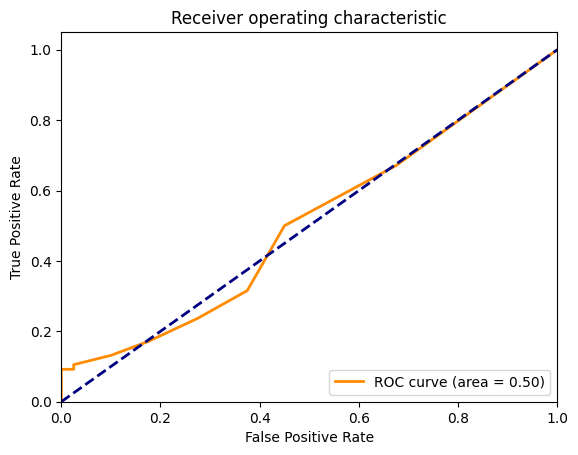

min bootstrapping aucroc:
0.3136513157894737
max bootstrapping aucroc:
0.7004419191919191
p_onesided = 0

Target_AUC = 0
p_twosided_1 = 0
p_twosided_2 = 1
p_twosided = 0
boots_mean_AUCROC =
0.5033665242864738(0.39506578947368426,0.6145833333333334)

...END AUCROC

FINISH


Input Data: cbcl
Wave: optimal
Ksads Reporter: child
Hypothesis: 2a
Sex: girls


BEGIN LOADING KSADS...

...FINISH LOADING KSADS
BEGIN LOADING CBCL...
...FINISH LOADING CBCL
BEGIN MERGING...
...FINISH MERGING
BEGIN PREPROCESSING...

Last check of missing data. Non-null rows = 0

Check that positives and negatives dont overlap
Index([], dtype='object', name='src_subject_id')
FINAL Number of positives in the data n=96
Number of negatives in the data (before subsampling) n=118
Overall sample size (before subsampling) n=214
Not enough negative samples to use the desired neg/pos rate. Using all negative samples
FINAL Number of negatives in the data (after subsampling) n=118
FINAL Overall sample size (before subsampling) n

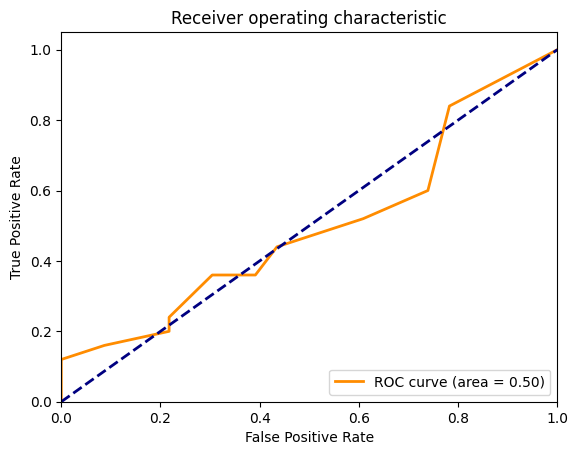

min bootstrapping aucroc:
0.24603174603174605
max bootstrapping aucroc:
0.7447817836812145
p_onesided = 0

Target_AUC = 0
p_twosided_1 = 0
p_twosided_2 = 1
p_twosided = 0
boots_mean_AUCROC =
0.4968556096077393(0.33043478260869563,0.6593927893738141)

...END AUCROC

FINISH


Input Data: cbcl
Wave: baseline
Ksads Reporter: child
Hypothesis: 2b
Sex: girls


BEGIN LOADING KSADS...

...FINISH LOADING KSADS
BEGIN LOADING CBCL...
...FINISH LOADING CBCL
BEGIN MERGING...
...FINISH MERGING
BEGIN PREPROCESSING...

Last check of missing data. Non-null rows = 0

Check that positives and negatives dont overlap
Index([], dtype='object', name='src_subject_id')
FINAL Number of positives in the data n=105
Number of negatives in the data (before subsampling) n=78
Overall sample size (before subsampling) n=183
Not enough negative samples to use the desired neg/pos rate. Using all negative samples
FINAL Number of negatives in the data (after subsampling) n=78
FINAL Overall sample size (before subsampling) 

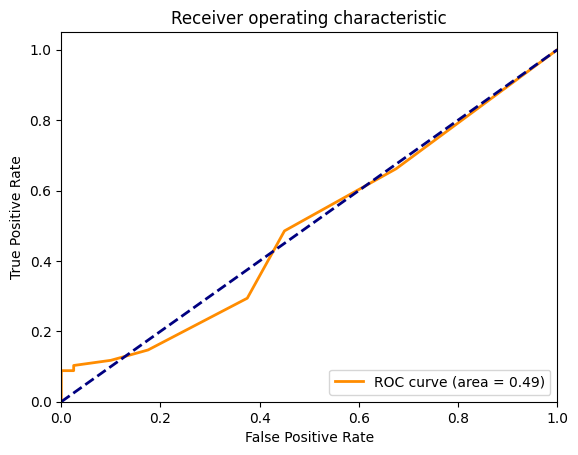

min bootstrapping aucroc:
0.29029982363315693
max bootstrapping aucroc:
0.6956766917293233
p_onesided = 0

Target_AUC = 0
p_twosided_1 = 0
p_twosided_2 = 1
p_twosided = 0
boots_mean_AUCROC =
0.49124232978022975(0.38085867620751346,0.5993640699523053)

...END AUCROC

FINISH


Input Data: cbcl
Wave: optimal
Ksads Reporter: child
Hypothesis: 2b
Sex: girls


BEGIN LOADING KSADS...

...FINISH LOADING KSADS
BEGIN LOADING CBCL...
...FINISH LOADING CBCL
BEGIN MERGING...
...FINISH MERGING
BEGIN PREPROCESSING...

Last check of missing data. Non-null rows = 0

Check that positives and negatives dont overlap
Index([], dtype='object', name='src_subject_id')
FINAL Number of positives in the data n=71
Number of negatives in the data (before subsampling) n=118
Overall sample size (before subsampling) n=189
Not enough negative samples to use the desired neg/pos rate. Using all negative samples
FINAL Number of negatives in the data (after subsampling) n=118
FINAL Overall sample size (before subsampling)

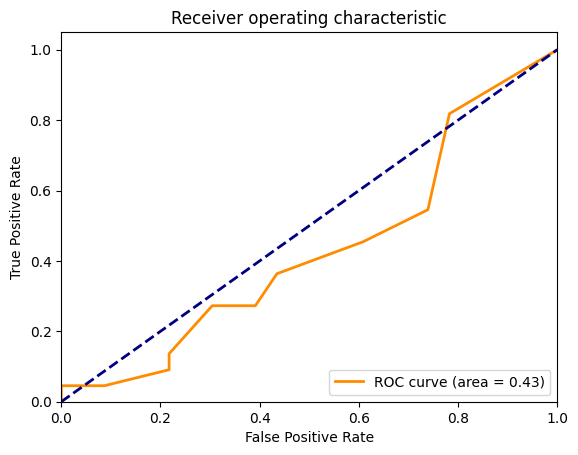

min bootstrapping aucroc:
0.1541501976284585
max bootstrapping aucroc:
0.7272727272727273
p_onesided = 0

Target_AUC = 0
p_twosided_1 = 0
p_twosided_2 = 0
p_twosided = 0
boots_mean_AUCROC =
0.4338120866946327(0.2857142857142857,0.6103238866396761)

...END AUCROC

FINISH


Input Data: ysr
Wave: Always optimal
Ksads Reporter: parent
Hypothesis: 1
Sex: boys


BEGIN LOADING KSADS...

...FINISH LOADING KSADS
BEGIN LOADING YSR...
...FINISH LOADING YSR
BEGIN MERGING...
...FINISH MERGING
BEGIN PREPROCESSING...

Last check of missing data. Non-null rows = 0

Check that positives and negatives dont overlap
Index([], dtype='object', name='src_subject_id')
FINAL Number of positives in the data n=81
Number of negatives in the data (before subsampling) n=10199
Overall sample size (before subsampling) n=10280
FINAL Number of negatives in the data (after subsampling) n=729
FINAL Overall sample size (before subsampling) n=810
demo_sex_v2
1.0    417
2.0    393
Name: count, dtype: int64
Positive girls in

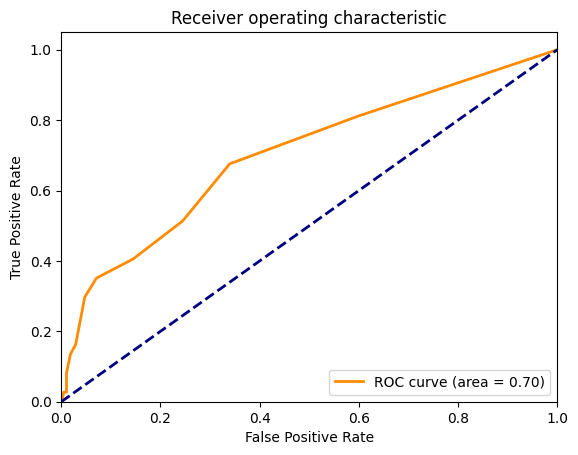

min bootstrapping aucroc:
0.5216172630932269
max bootstrapping aucroc:
0.8367762248502534
p_onesided = 0

Target_AUC = 0
p_twosided_1 = 0
p_twosided_2 = 0
p_twosided = 0
boots_mean_AUCROC =
0.6995638820962842(0.5996352785145889,0.7939640608201506)

...END AUCROC

FINISH


Input Data: ysr
Wave: Always optimal
Ksads Reporter: parent
Hypothesis: 2a
Sex: boys


BEGIN LOADING KSADS...

...FINISH LOADING KSADS
BEGIN LOADING YSR...
...FINISH LOADING YSR
BEGIN MERGING...
...FINISH MERGING
BEGIN PREPROCESSING...

Last check of missing data. Non-null rows = 0

Check that positives and negatives dont overlap
Index([], dtype='object', name='src_subject_id')
FINAL Number of positives in the data n=81
Number of negatives in the data (before subsampling) n=1297
Overall sample size (before subsampling) n=1378
FINAL Number of negatives in the data (after subsampling) n=729
FINAL Overall sample size (before subsampling) n=810
demo_sex_v2
1.0    461
2.0    347
3.0      1
Name: count, dtype: int64
Positiv

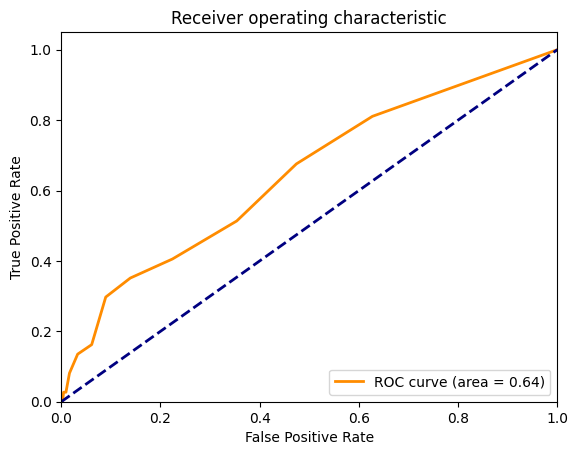

min bootstrapping aucroc:
0.48715627095908787
max bootstrapping aucroc:
0.7821424231376839
p_onesided = 0

Target_AUC = 0
p_twosided_1 = 0
p_twosided_2 = 1
p_twosided = 0
boots_mean_AUCROC =
0.6432231918422754(0.5421193829644534,0.7410035629453682)

...END AUCROC

FINISH


Input Data: ysr
Wave: Always optimal
Ksads Reporter: parent
Hypothesis: 2b
Sex: boys


BEGIN LOADING KSADS...

...FINISH LOADING KSADS
BEGIN LOADING YSR...
...FINISH LOADING YSR
BEGIN MERGING...
...FINISH MERGING
BEGIN PREPROCESSING...

Last check of missing data. Non-null rows = 0

Check that positives and negatives dont overlap
Index([], dtype='object', name='src_subject_id')
FINAL Number of positives in the data n=32
Number of negatives in the data (before subsampling) n=1297
Overall sample size (before subsampling) n=1329
FINAL Number of negatives in the data (after subsampling) n=288
FINAL Overall sample size (before subsampling) n=320
demo_sex_v2
1.0    169
2.0    150
3.0      1
Name: count, dtype: int64
Positi

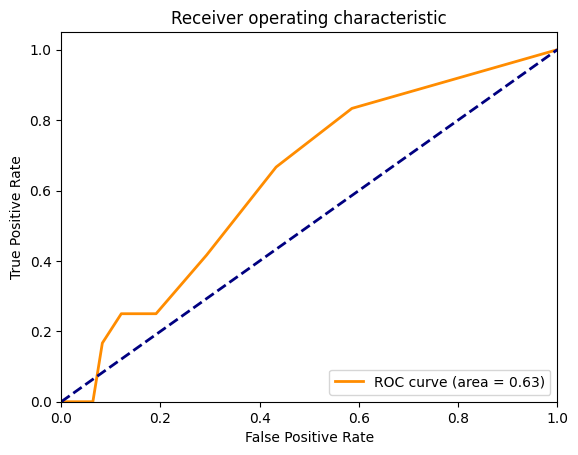

min bootstrapping aucroc:
0.40035273368606705
max bootstrapping aucroc:
0.8463855421686747
p_onesided = 0

Target_AUC = 0
p_twosided_1 = 0
p_twosided_2 = 0
p_twosided = 0
boots_mean_AUCROC =
0.6271707740504069(0.4732704402515724,0.7671957671957672)

...END AUCROC

FINISH


Input Data: ysr
Wave: Always optimal
Ksads Reporter: child
Hypothesis: 1
Sex: boys


BEGIN LOADING KSADS...

...FINISH LOADING KSADS
BEGIN LOADING YSR...
...FINISH LOADING YSR
BEGIN MERGING...
...FINISH MERGING
BEGIN PREPROCESSING...

Last check of missing data. Non-null rows = 0

Check that positives and negatives dont overlap
Index([], dtype='object', name='src_subject_id')
FINAL Number of positives in the data n=84
Number of negatives in the data (before subsampling) n=10332
Overall sample size (before subsampling) n=10416
FINAL Number of negatives in the data (after subsampling) n=756
FINAL Overall sample size (before subsampling) n=840
demo_sex_v2
1.0    421
2.0    418
Name: count, dtype: int64
Positive girls in

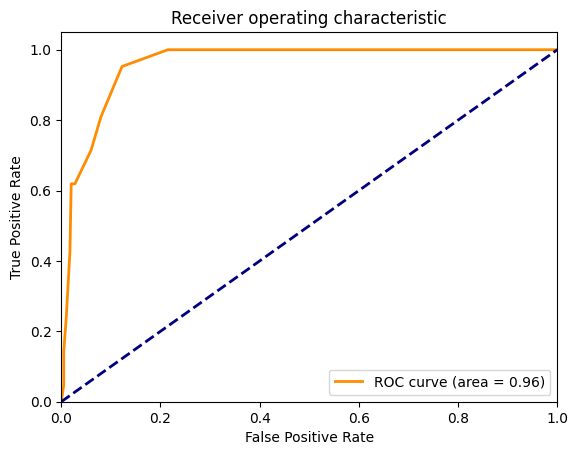

min bootstrapping aucroc:
0.9029961266803372
max bootstrapping aucroc:
0.9891625615763546
p_onesided = 1

Target_AUC = 0
p_twosided_1 = 1
p_twosided_2 = 0
p_twosided = 0
boots_mean_AUCROC =
0.9595014255282734(0.9360119047619048,0.9801777170198223)

...END AUCROC

FINISH


Input Data: ysr
Wave: Always optimal
Ksads Reporter: child
Hypothesis: 2a
Sex: boys


BEGIN LOADING KSADS...

...FINISH LOADING KSADS
BEGIN LOADING YSR...
...FINISH LOADING YSR
BEGIN MERGING...
...FINISH MERGING
BEGIN PREPROCESSING...

Last check of missing data. Non-null rows = 0

Check that positives and negatives dont overlap
Index([], dtype='object', name='src_subject_id')
FINAL Number of positives in the data n=84
Number of negatives in the data (before subsampling) n=112
Overall sample size (before subsampling) n=196
Not enough negative samples to use the desired neg/pos rate. Using all negative samples
FINAL Number of negatives in the data (after subsampling) n=112
FINAL Overall sample size (before subsampling)

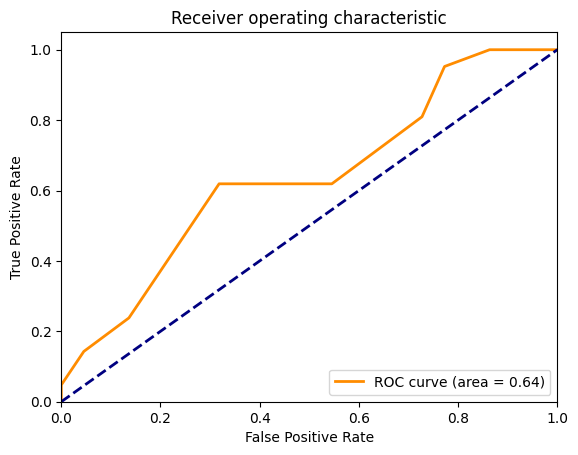

min bootstrapping aucroc:
0.33874458874458874
max bootstrapping aucroc:
0.8452380952380952
p_onesided = 0

Target_AUC = 0
p_twosided_1 = 0
p_twosided_2 = 0
p_twosided = 0
boots_mean_AUCROC =
0.6373296552765277(0.46600877192982454,0.79)

...END AUCROC

FINISH


Input Data: ysr
Wave: Always optimal
Ksads Reporter: child
Hypothesis: 2b
Sex: boys


BEGIN LOADING KSADS...

...FINISH LOADING KSADS
BEGIN LOADING YSR...
...FINISH LOADING YSR
BEGIN MERGING...
...FINISH MERGING
BEGIN PREPROCESSING...

Last check of missing data. Non-null rows = 0

Check that positives and negatives dont overlap
Index([], dtype='object', name='src_subject_id')
FINAL Number of positives in the data n=61
Number of negatives in the data (before subsampling) n=112
Overall sample size (before subsampling) n=173
Not enough negative samples to use the desired neg/pos rate. Using all negative samples
FINAL Number of negatives in the data (after subsampling) n=112
FINAL Overall sample size (before subsampling) n=173
demo_

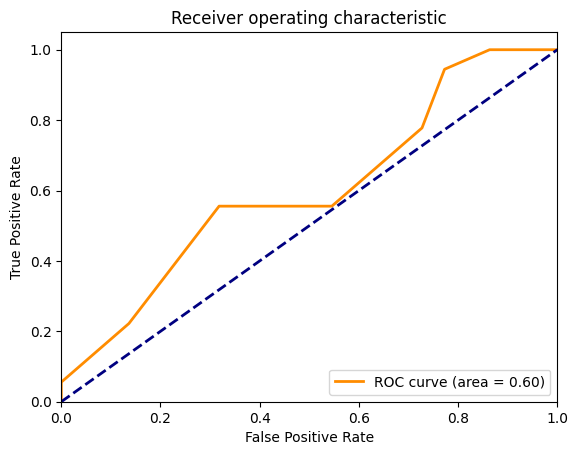

min bootstrapping aucroc:
0.2975
max bootstrapping aucroc:
0.8573232323232324
p_onesided = 0

Target_AUC = 0
p_twosided_1 = 0
p_twosided_2 = 0
p_twosided = 0
boots_mean_AUCROC =
0.5963937672947064(0.40601503759398494,0.7781954887218046)

...END AUCROC

FINISH


Input Data: cbcl
Wave: baseline
Ksads Reporter: parent
Hypothesis: 1
Sex: boys


BEGIN LOADING KSADS...

...FINISH LOADING KSADS
BEGIN LOADING CBCL...
...FINISH LOADING CBCL
BEGIN MERGING...
...FINISH MERGING
BEGIN PREPROCESSING...

Last check of missing data. Non-null rows = 0

Check that positives and negatives dont overlap
Index([], dtype='object', name='src_subject_id')
FINAL Number of positives in the data n=30
Number of negatives in the data (before subsampling) n=6154
Overall sample size (before subsampling) n=6184
FINAL Number of negatives in the data (after subsampling) n=270
FINAL Overall sample size (before subsampling) n=300
demo_sex_v2
2.0    156
1.0    144
Name: count, dtype: int64
Positive girls in sample = 19
Pos

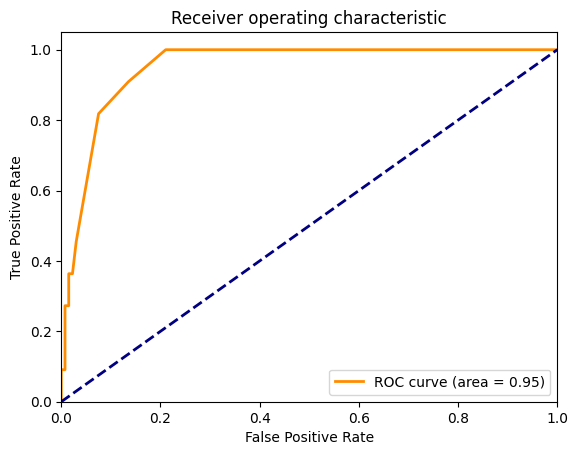

min bootstrapping aucroc:
0.8635265700483091
max bootstrapping aucroc:
0.9973931178310741
p_onesided = 1

Target_AUC = 0
p_twosided_1 = 1
p_twosided_2 = 0
p_twosided = 0
boots_mean_AUCROC =
0.9508498560815062(0.9037037037037037,0.9843283582089551)

...END AUCROC

FINISH


Input Data: cbcl
Wave: optimal
Ksads Reporter: parent
Hypothesis: 1
Sex: boys


BEGIN LOADING KSADS...

...FINISH LOADING KSADS
BEGIN LOADING CBCL...
...FINISH LOADING CBCL
BEGIN MERGING...
...FINISH MERGING
BEGIN PREPROCESSING...

Last check of missing data. Non-null rows = 0

Check that positives and negatives dont overlap
Index([], dtype='object', name='src_subject_id')
FINAL Number of positives in the data n=83
Number of negatives in the data (before subsampling) n=10618
Overall sample size (before subsampling) n=10701
FINAL Number of negatives in the data (after subsampling) n=747
FINAL Overall sample size (before subsampling) n=830
demo_sex_v2
1.0    436
2.0    393
Name: count, dtype: int64
Positive girls in sam

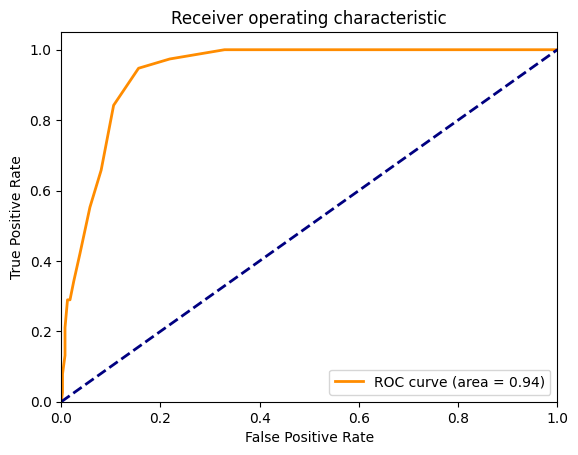

min bootstrapping aucroc:
0.9001162565394303
max bootstrapping aucroc:
0.9727424749163879
p_onesided = 1

Target_AUC = 0
p_twosided_1 = 1
p_twosided_2 = 0
p_twosided = 0
boots_mean_AUCROC =
0.9379932270638679(0.9119076065312625,0.9608141976563028)

...END AUCROC

FINISH


Input Data: cbcl
Wave: baseline
Ksads Reporter: parent
Hypothesis: 2a
Sex: boys


BEGIN LOADING KSADS...

...FINISH LOADING KSADS
BEGIN LOADING CBCL...
...FINISH LOADING CBCL
BEGIN MERGING...
...FINISH MERGING
BEGIN PREPROCESSING...

Last check of missing data. Non-null rows = 0

Check that positives and negatives dont overlap
Index([], dtype='object', name='src_subject_id')
FINAL Number of positives in the data n=30
Number of negatives in the data (before subsampling) n=999
Overall sample size (before subsampling) n=1029
FINAL Number of negatives in the data (after subsampling) n=270
FINAL Overall sample size (before subsampling) n=300
demo_sex_v2
1.0    175
2.0    125
Name: count, dtype: int64
Positive girls in samp

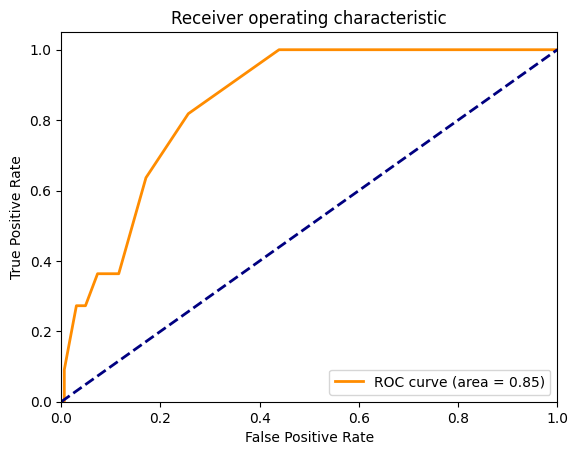

min bootstrapping aucroc:
0.6994117647058824
max bootstrapping aucroc:
0.9574829931972789
p_onesided = 0

Target_AUC = 0
p_twosided_1 = 0
p_twosided_2 = 0
p_twosided = 0
boots_mean_AUCROC =
0.8479688436313269(0.7627245508982036,0.9255239520958084)

...END AUCROC

FINISH


Input Data: cbcl
Wave: optimal
Ksads Reporter: parent
Hypothesis: 2a
Sex: boys


BEGIN LOADING KSADS...

...FINISH LOADING KSADS
BEGIN LOADING CBCL...
...FINISH LOADING CBCL
BEGIN MERGING...
...FINISH MERGING
BEGIN PREPROCESSING...

Last check of missing data. Non-null rows = 0

Check that positives and negatives dont overlap
Index([], dtype='object', name='src_subject_id')
FINAL Number of positives in the data n=83
Number of negatives in the data (before subsampling) n=1372
Overall sample size (before subsampling) n=1455
FINAL Number of negatives in the data (after subsampling) n=747
FINAL Overall sample size (before subsampling) n=830
demo_sex_v2
1.0    460
2.0    369
Name: count, dtype: int64
Positive girls in samp

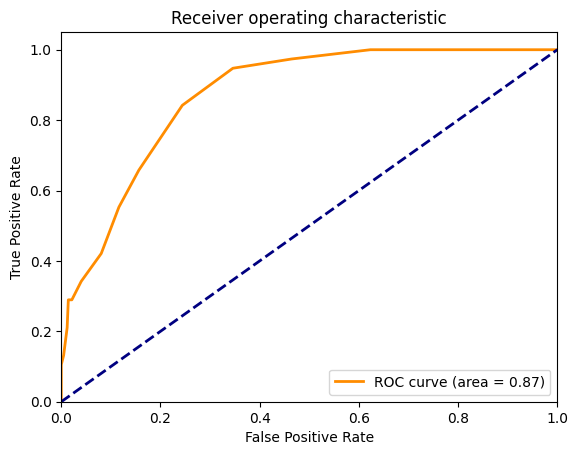

min bootstrapping aucroc:
0.7691756048889997
max bootstrapping aucroc:
0.9384883720930233
p_onesided = 0

Target_AUC = 0
p_twosided_1 = 0
p_twosided_2 = 0
p_twosided = 0
boots_mean_AUCROC =
0.8716577163366952(0.8266509433962264,0.912015503875969)

...END AUCROC

FINISH


Input Data: cbcl
Wave: baseline
Ksads Reporter: parent
Hypothesis: 2b
Sex: boys


BEGIN LOADING KSADS...

...FINISH LOADING KSADS
BEGIN LOADING CBCL...
...FINISH LOADING CBCL
BEGIN MERGING...
...FINISH MERGING
BEGIN PREPROCESSING...

Last check of missing data. Non-null rows = 0

Check that positives and negatives dont overlap
Index([], dtype='object', name='src_subject_id')
FINAL Number of positives in the data n=11
Number of negatives in the data (before subsampling) n=999
Overall sample size (before subsampling) n=1010
FINAL Number of negatives in the data (after subsampling) n=99
FINAL Overall sample size (before subsampling) n=110
demo_sex_v2
1.0    57
2.0    53
Name: count, dtype: int64
Positive girls in sample =

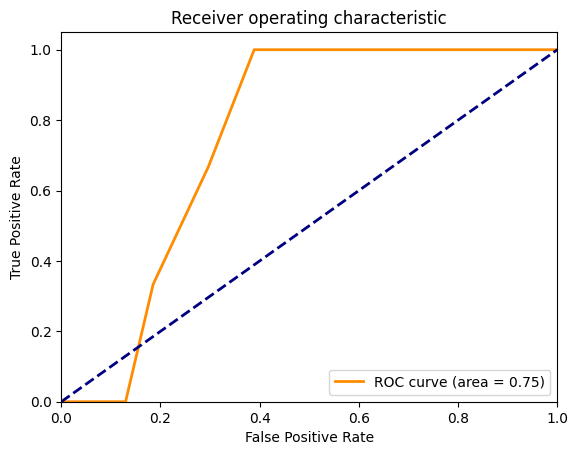


FINISH


Input Data: cbcl
Wave: optimal
Ksads Reporter: parent
Hypothesis: 2b
Sex: boys


BEGIN LOADING KSADS...

...FINISH LOADING KSADS
BEGIN LOADING CBCL...
...FINISH LOADING CBCL
BEGIN MERGING...
...FINISH MERGING
BEGIN PREPROCESSING...

Last check of missing data. Non-null rows = 0

Check that positives and negatives dont overlap
Index([], dtype='object', name='src_subject_id')
FINAL Number of positives in the data n=33
Number of negatives in the data (before subsampling) n=1372
Overall sample size (before subsampling) n=1405
FINAL Number of negatives in the data (after subsampling) n=297
FINAL Overall sample size (before subsampling) n=330
demo_sex_v2
1.0    173
2.0    156
Name: count, dtype: int64
Positive girls in sample = 21
Positive boys in sample = 12

...END PREPROCESSING

FINISHED DATA PREP


START ANALYSIS


Input Data: cbcl
Wave: optimal
Ksads Reporter: parent
Hypothesis: 2b
Sex: boys
BEGIN AUCROC...

Single AUCROC score without bootstrapping:
0.8162525879917184


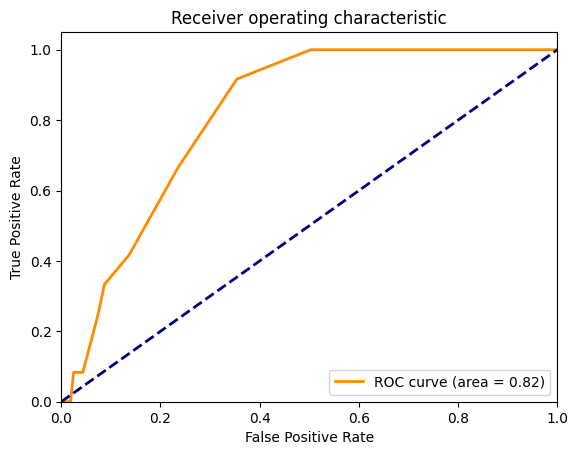

min bootstrapping aucroc:
0.6759259259259259
max bootstrapping aucroc:
0.9413956639566395
p_onesided = 0

Target_AUC = 0
p_twosided_1 = 0
p_twosided_2 = 0
p_twosided = 0
boots_mean_AUCROC =
0.8172185052149643(0.7343881856540084,0.899390243902439)

...END AUCROC

FINISH


Input Data: cbcl
Wave: baseline
Ksads Reporter: child
Hypothesis: 1
Sex: boys


BEGIN LOADING KSADS...

...FINISH LOADING KSADS
BEGIN LOADING CBCL...
...FINISH LOADING CBCL
BEGIN MERGING...
...FINISH MERGING
BEGIN PREPROCESSING...

Last check of missing data. Non-null rows = 0

Check that positives and negatives dont overlap
Index([], dtype='object', name='src_subject_id')
FINAL Number of positives in the data n=119
Number of negatives in the data (before subsampling) n=11666
Overall sample size (before subsampling) n=11785
FINAL Number of negatives in the data (after subsampling) n=1071
FINAL Overall sample size (before subsampling) n=1190
demo_sex_v2
1.0    613
2.0    576
Name: count, dtype: int64
Positive girls in s

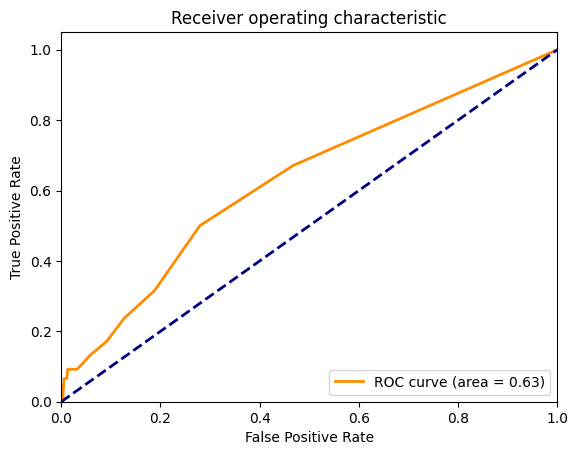

min bootstrapping aucroc:
0.5211542411172725
max bootstrapping aucroc:
0.7118776994771538
p_onesided = 0

Target_AUC = 0
p_twosided_1 = 0
p_twosided_2 = 1
p_twosided = 0
boots_mean_AUCROC =
0.6258018690294285(0.5609339700143766,0.6878150794969808)

...END AUCROC

FINISH


Input Data: cbcl
Wave: optimal
Ksads Reporter: child
Hypothesis: 1
Sex: boys


BEGIN LOADING KSADS...

...FINISH LOADING KSADS
BEGIN LOADING CBCL...
...FINISH LOADING CBCL
BEGIN MERGING...
...FINISH MERGING
BEGIN PREPROCESSING...

Last check of missing data. Non-null rows = 0

Check that positives and negatives dont overlap
Index([], dtype='object', name='src_subject_id')
FINAL Number of positives in the data n=96
Number of negatives in the data (before subsampling) n=10683
Overall sample size (before subsampling) n=10779
FINAL Number of negatives in the data (after subsampling) n=864
FINAL Overall sample size (before subsampling) n=960
demo_sex_v2
1.0    498
2.0    460
Name: count, dtype: int64
Positive girls in samp

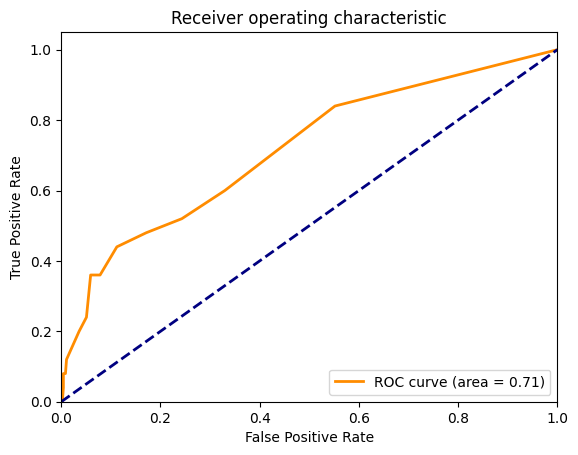

min bootstrapping aucroc:
0.49191374663072773
max bootstrapping aucroc:
0.8635995370370371
p_onesided = 0

Target_AUC = 0
p_twosided_1 = 0
p_twosided_2 = 0
p_twosided = 0
boots_mean_AUCROC =
0.7120941170118075(0.5975716954180859,0.8093220338983051)

...END AUCROC

FINISH


Input Data: cbcl
Wave: baseline
Ksads Reporter: child
Hypothesis: 2a
Sex: boys


BEGIN LOADING KSADS...

...FINISH LOADING KSADS
BEGIN LOADING CBCL...
...FINISH LOADING CBCL
BEGIN MERGING...
...FINISH MERGING
BEGIN PREPROCESSING...

Last check of missing data. Non-null rows = 0

Check that positives and negatives dont overlap
Index([], dtype='object', name='src_subject_id')
FINAL Number of positives in the data n=119
Number of negatives in the data (before subsampling) n=78
Overall sample size (before subsampling) n=197
Not enough negative samples to use the desired neg/pos rate. Using all negative samples
FINAL Number of negatives in the data (after subsampling) n=78
FINAL Overall sample size (before subsampling) n=

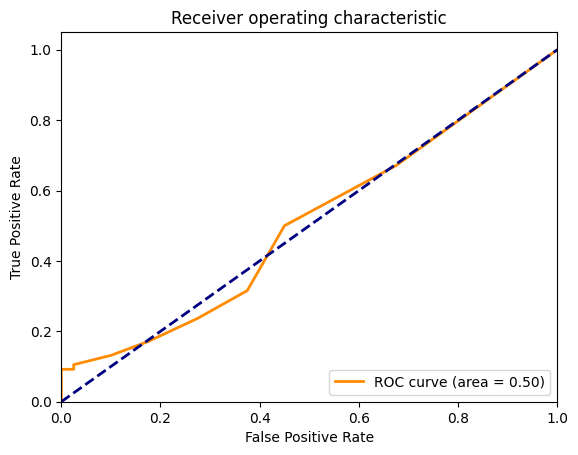

min bootstrapping aucroc:
0.3045977011494253
max bootstrapping aucroc:
0.6992694805194806
p_onesided = 0

Target_AUC = 0
p_twosided_1 = 0
p_twosided_2 = 1
p_twosided = 0
boots_mean_AUCROC =
0.5060836079416(0.3947089947089947,0.6149569583931134)

...END AUCROC

FINISH


Input Data: cbcl
Wave: optimal
Ksads Reporter: child
Hypothesis: 2a
Sex: boys


BEGIN LOADING KSADS...

...FINISH LOADING KSADS
BEGIN LOADING CBCL...
...FINISH LOADING CBCL
BEGIN MERGING...
...FINISH MERGING
BEGIN PREPROCESSING...

Last check of missing data. Non-null rows = 0

Check that positives and negatives dont overlap
Index([], dtype='object', name='src_subject_id')
FINAL Number of positives in the data n=96
Number of negatives in the data (before subsampling) n=118
Overall sample size (before subsampling) n=214
Not enough negative samples to use the desired neg/pos rate. Using all negative samples
FINAL Number of negatives in the data (after subsampling) n=118
FINAL Overall sample size (before subsampling) n=214


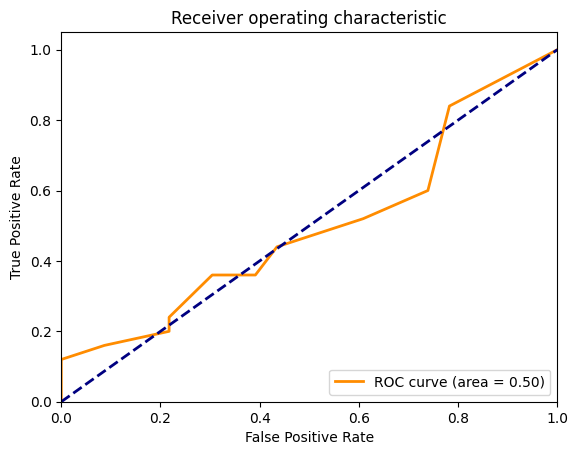

min bootstrapping aucroc:
0.21516754850088182
max bootstrapping aucroc:
0.7776769509981851
p_onesided = 0

Target_AUC = 0
p_twosided_1 = 0
p_twosided_2 = 1
p_twosided = 0
boots_mean_AUCROC =
0.49930460324601206(0.3368121442125237,0.6730434782608696)

...END AUCROC

FINISH


Input Data: cbcl
Wave: baseline
Ksads Reporter: child
Hypothesis: 2b
Sex: boys


BEGIN LOADING KSADS...

...FINISH LOADING KSADS
BEGIN LOADING CBCL...
...FINISH LOADING CBCL
BEGIN MERGING...
...FINISH MERGING
BEGIN PREPROCESSING...

Last check of missing data. Non-null rows = 0

Check that positives and negatives dont overlap
Index([], dtype='object', name='src_subject_id')
FINAL Number of positives in the data n=105
Number of negatives in the data (before subsampling) n=78
Overall sample size (before subsampling) n=183
Not enough negative samples to use the desired neg/pos rate. Using all negative samples
FINAL Number of negatives in the data (after subsampling) n=78
FINAL Overall sample size (before subsampling) n

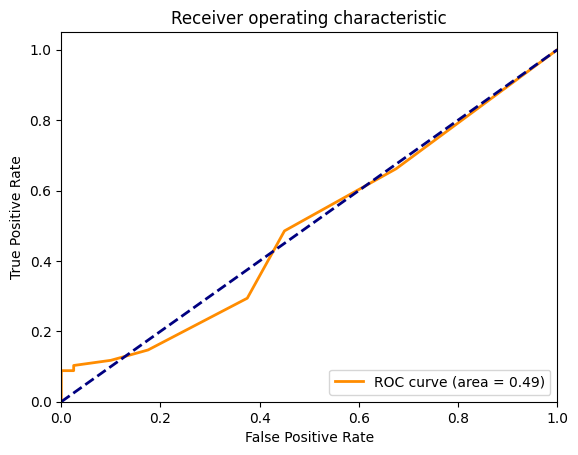

min bootstrapping aucroc:
0.3003759398496241
max bootstrapping aucroc:
0.6668991977677015
p_onesided = 0

Target_AUC = 0
p_twosided_1 = 0
p_twosided_2 = 1
p_twosided = 0
boots_mean_AUCROC =
0.49176694727972053(0.380852683669585,0.6029357116313638)

...END AUCROC

FINISH


Input Data: cbcl
Wave: optimal
Ksads Reporter: child
Hypothesis: 2b
Sex: boys


BEGIN LOADING KSADS...

...FINISH LOADING KSADS
BEGIN LOADING CBCL...
...FINISH LOADING CBCL
BEGIN MERGING...
...FINISH MERGING
BEGIN PREPROCESSING...

Last check of missing data. Non-null rows = 0

Check that positives and negatives dont overlap
Index([], dtype='object', name='src_subject_id')
FINAL Number of positives in the data n=71
Number of negatives in the data (before subsampling) n=118
Overall sample size (before subsampling) n=189
Not enough negative samples to use the desired neg/pos rate. Using all negative samples
FINAL Number of negatives in the data (after subsampling) n=118
FINAL Overall sample size (before subsampling) n=1

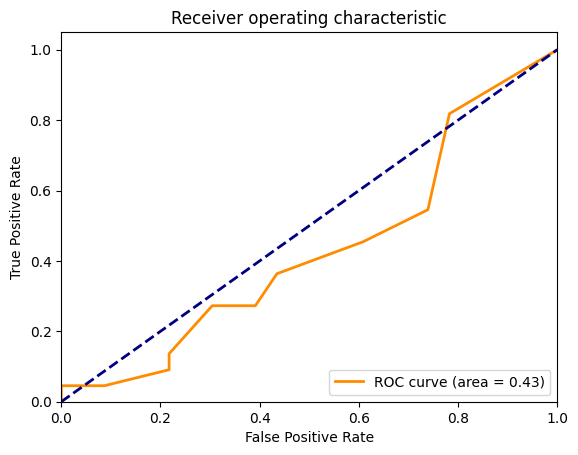

min bootstrapping aucroc:
0.167
max bootstrapping aucroc:
0.7186234817813766
p_onesided = 0

Target_AUC = 0
p_twosided_1 = 0
p_twosided_2 = 0
p_twosided = 0
boots_mean_AUCROC =
0.43007668123474296(0.27,0.6031746031746033)

...END AUCROC

FINISH


Input Data: ysr
Wave: Always optimal
Ksads Reporter: parent
Hypothesis: 1
Sex: both


BEGIN LOADING KSADS...

...FINISH LOADING KSADS
BEGIN LOADING YSR...
...FINISH LOADING YSR
BEGIN MERGING...
...FINISH MERGING
BEGIN PREPROCESSING...

Last check of missing data. Non-null rows = 0

Check that positives and negatives dont overlap
Index([], dtype='object', name='src_subject_id')
FINAL Number of positives in the data n=81
Number of negatives in the data (before subsampling) n=10199
Overall sample size (before subsampling) n=10280
FINAL Number of negatives in the data (after subsampling) n=729
FINAL Overall sample size (before subsampling) n=810
demo_sex_v2
1.0    417
2.0    393
Name: count, dtype: int64
Positive girls in sample = 44
Positive boys

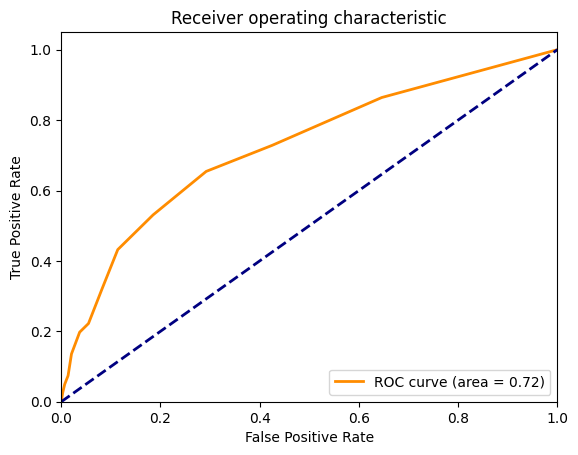

min bootstrapping aucroc:
0.6144489795918368
max bootstrapping aucroc:
0.832109646920293
p_onesided = 0

Target_AUC = 0
p_twosided_1 = 0
p_twosided_2 = 0
p_twosided = 0
boots_mean_AUCROC =
0.7231657958450357(0.6607667450058754,0.7861386986301371)

...END AUCROC

FINISH


Input Data: ysr
Wave: Always optimal
Ksads Reporter: parent
Hypothesis: 2a
Sex: both


BEGIN LOADING KSADS...

...FINISH LOADING KSADS
BEGIN LOADING YSR...
...FINISH LOADING YSR
BEGIN MERGING...
...FINISH MERGING
BEGIN PREPROCESSING...

Last check of missing data. Non-null rows = 0

Check that positives and negatives dont overlap
Index([], dtype='object', name='src_subject_id')
FINAL Number of positives in the data n=81
Number of negatives in the data (before subsampling) n=1297
Overall sample size (before subsampling) n=1378
FINAL Number of negatives in the data (after subsampling) n=729
FINAL Overall sample size (before subsampling) n=810
demo_sex_v2
1.0    461
2.0    347
3.0      1
Name: count, dtype: int64
Positive

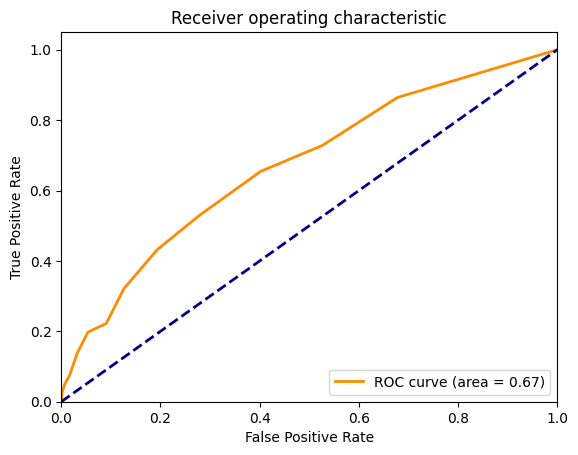

min bootstrapping aucroc:
0.5847995137839144
max bootstrapping aucroc:
0.7596122515477355
p_onesided = 0

Target_AUC = 0
p_twosided_1 = 0
p_twosided_2 = 1
p_twosided = 0
boots_mean_AUCROC =
0.6716641259805675(0.6114029112290262,0.7309217475627283)

...END AUCROC

FINISH


Input Data: ysr
Wave: Always optimal
Ksads Reporter: parent
Hypothesis: 2b
Sex: both


BEGIN LOADING KSADS...

...FINISH LOADING KSADS
BEGIN LOADING YSR...
...FINISH LOADING YSR
BEGIN MERGING...
...FINISH MERGING
BEGIN PREPROCESSING...

Last check of missing data. Non-null rows = 0

Check that positives and negatives dont overlap
Index([], dtype='object', name='src_subject_id')
FINAL Number of positives in the data n=32
Number of negatives in the data (before subsampling) n=1297
Overall sample size (before subsampling) n=1329
FINAL Number of negatives in the data (after subsampling) n=288
FINAL Overall sample size (before subsampling) n=320
demo_sex_v2
1.0    169
2.0    150
3.0      1
Name: count, dtype: int64
Positiv

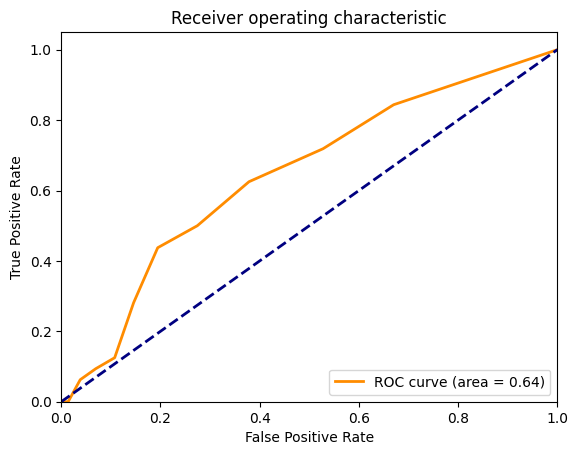

min bootstrapping aucroc:
0.4611271081859317
max bootstrapping aucroc:
0.7793040293040294
p_onesided = 0

Target_AUC = 0
p_twosided_1 = 0
p_twosided_2 = 0
p_twosided = 0
boots_mean_AUCROC =
0.6406166833104524(0.5387186343068696,0.7322603866721513)

...END AUCROC

FINISH


Input Data: ysr
Wave: Always optimal
Ksads Reporter: child
Hypothesis: 1
Sex: both


BEGIN LOADING KSADS...

...FINISH LOADING KSADS
BEGIN LOADING YSR...
...FINISH LOADING YSR
BEGIN MERGING...
...FINISH MERGING
BEGIN PREPROCESSING...

Last check of missing data. Non-null rows = 0

Check that positives and negatives dont overlap
Index([], dtype='object', name='src_subject_id')
FINAL Number of positives in the data n=84
Number of negatives in the data (before subsampling) n=10332
Overall sample size (before subsampling) n=10416
FINAL Number of negatives in the data (after subsampling) n=756
FINAL Overall sample size (before subsampling) n=840
demo_sex_v2
1.0    421
2.0    418
Name: count, dtype: int64
Positive girls in 

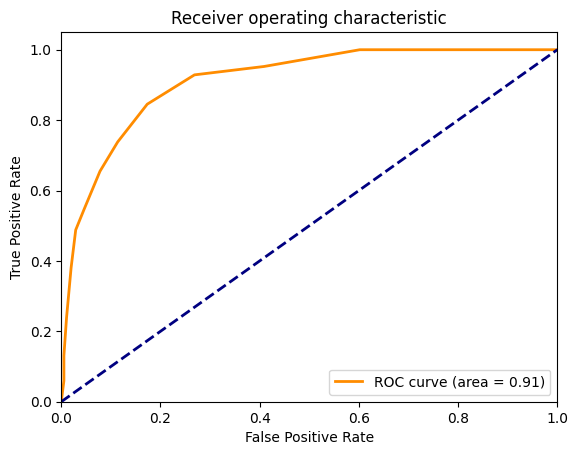

min bootstrapping aucroc:
0.8562118532884604
max bootstrapping aucroc:
0.952538422776518
p_onesided = 1

Target_AUC = 0
p_twosided_1 = 1
p_twosided_2 = 0
p_twosided = 0
boots_mean_AUCROC =
0.9115154722569389(0.8831332236842105,0.9380676829180521)

...END AUCROC

FINISH


Input Data: ysr
Wave: Always optimal
Ksads Reporter: child
Hypothesis: 2a
Sex: both


BEGIN LOADING KSADS...

...FINISH LOADING KSADS
BEGIN LOADING YSR...
...FINISH LOADING YSR
BEGIN MERGING...
...FINISH MERGING
BEGIN PREPROCESSING...

Last check of missing data. Non-null rows = 0

Check that positives and negatives dont overlap
Index([], dtype='object', name='src_subject_id')
FINAL Number of positives in the data n=84
Number of negatives in the data (before subsampling) n=112
Overall sample size (before subsampling) n=196
Not enough negative samples to use the desired neg/pos rate. Using all negative samples
FINAL Number of negatives in the data (after subsampling) n=112
FINAL Overall sample size (before subsampling) 

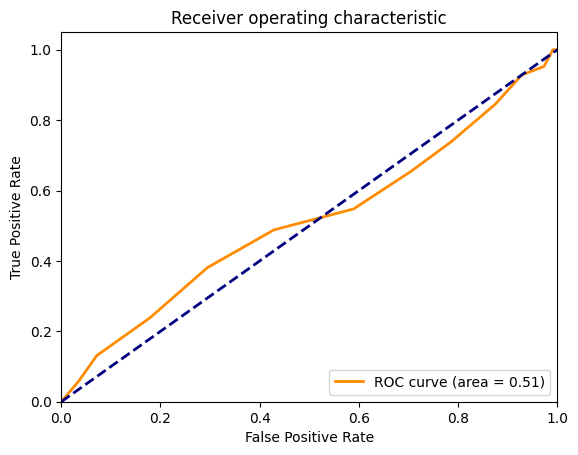

min bootstrapping aucroc:
0.38104407359863074
max bootstrapping aucroc:
0.6558176100628931
p_onesided = 0

Target_AUC = 0
p_twosided_1 = 0
p_twosided_2 = 1
p_twosided = 0
boots_mean_AUCROC =
0.5145944686188363(0.4330208333333334,0.5977091287747309)

...END AUCROC

FINISH


Input Data: ysr
Wave: Always optimal
Ksads Reporter: child
Hypothesis: 2b
Sex: both


BEGIN LOADING KSADS...

...FINISH LOADING KSADS
BEGIN LOADING YSR...
...FINISH LOADING YSR
BEGIN MERGING...
...FINISH MERGING
BEGIN PREPROCESSING...

Last check of missing data. Non-null rows = 0

Check that positives and negatives dont overlap
Index([], dtype='object', name='src_subject_id')
FINAL Number of positives in the data n=61
Number of negatives in the data (before subsampling) n=112
Overall sample size (before subsampling) n=173
Not enough negative samples to use the desired neg/pos rate. Using all negative samples
FINAL Number of negatives in the data (after subsampling) n=112
FINAL Overall sample size (before subsampling

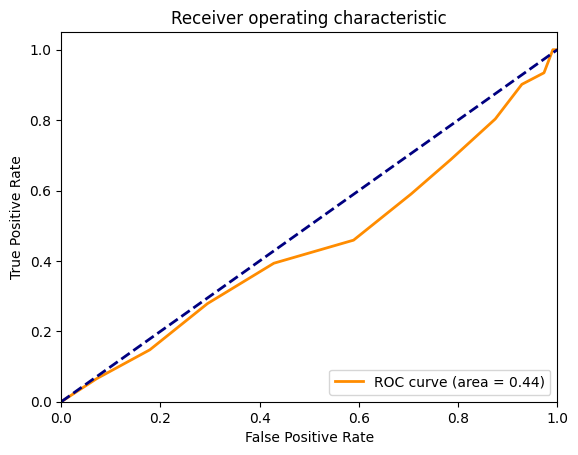

min bootstrapping aucroc:
0.2778120184899846
max bootstrapping aucroc:
0.5824614937518163
p_onesided = 0

Target_AUC = 0
p_twosided_1 = 0
p_twosided_2 = 1
p_twosided = 0
boots_mean_AUCROC =
0.44157430267802117(0.34944041137326076,0.531719059756443)

...END AUCROC

FINISH


Input Data: cbcl
Wave: baseline
Ksads Reporter: parent
Hypothesis: 1
Sex: both


BEGIN LOADING KSADS...

...FINISH LOADING KSADS
BEGIN LOADING CBCL...
...FINISH LOADING CBCL
BEGIN MERGING...
...FINISH MERGING
BEGIN PREPROCESSING...

Last check of missing data. Non-null rows = 0

Check that positives and negatives dont overlap
Index([], dtype='object', name='src_subject_id')
FINAL Number of positives in the data n=30
Number of negatives in the data (before subsampling) n=6154
Overall sample size (before subsampling) n=6184
FINAL Number of negatives in the data (after subsampling) n=270
FINAL Overall sample size (before subsampling) n=300
demo_sex_v2
2.0    156
1.0    144
Name: count, dtype: int64
Positive girls in sam

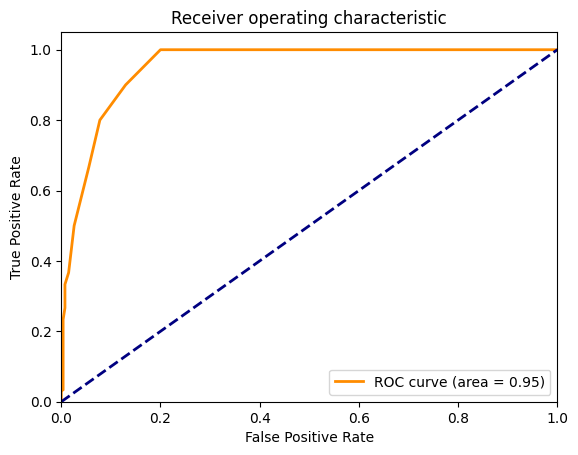

min bootstrapping aucroc:
0.9019407008086253
max bootstrapping aucroc:
0.9853592100783112
p_onesided = 1

Target_AUC = 0
p_twosided_1 = 1
p_twosided_2 = 0
p_twosided = 0
boots_mean_AUCROC =
0.9526195870936968(0.9266346153846154,0.9741547631281472)

...END AUCROC

FINISH


Input Data: cbcl
Wave: optimal
Ksads Reporter: parent
Hypothesis: 1
Sex: both


BEGIN LOADING KSADS...

...FINISH LOADING KSADS
BEGIN LOADING CBCL...
...FINISH LOADING CBCL
BEGIN MERGING...
...FINISH MERGING
BEGIN PREPROCESSING...

Last check of missing data. Non-null rows = 0

Check that positives and negatives dont overlap
Index([], dtype='object', name='src_subject_id')
FINAL Number of positives in the data n=83
Number of negatives in the data (before subsampling) n=10618
Overall sample size (before subsampling) n=10701
FINAL Number of negatives in the data (after subsampling) n=747
FINAL Overall sample size (before subsampling) n=830
demo_sex_v2
1.0    436
2.0    393
Name: count, dtype: int64
Positive girls in sam

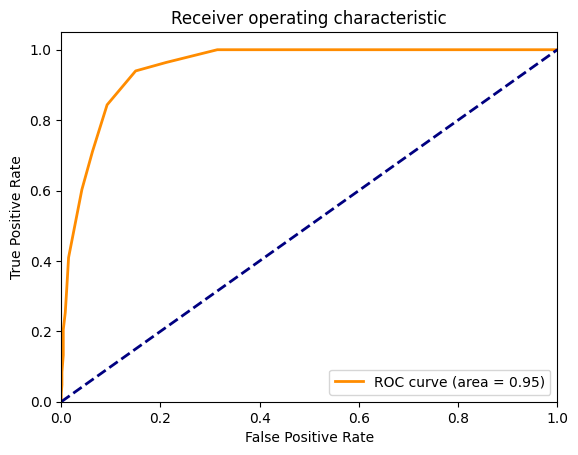

min bootstrapping aucroc:
0.9236833333333333
max bootstrapping aucroc:
0.9745285499914913
p_onesided = 1

Target_AUC = 0
p_twosided_1 = 1
p_twosided_2 = 0
p_twosided = 0
boots_mean_AUCROC =
0.9501133256615621(0.9339366515837103,0.9650450450450452)

...END AUCROC

FINISH


Input Data: cbcl
Wave: baseline
Ksads Reporter: parent
Hypothesis: 2a
Sex: both


BEGIN LOADING KSADS...

...FINISH LOADING KSADS
BEGIN LOADING CBCL...
...FINISH LOADING CBCL
BEGIN MERGING...
...FINISH MERGING
BEGIN PREPROCESSING...

Last check of missing data. Non-null rows = 0

Check that positives and negatives dont overlap
Index([], dtype='object', name='src_subject_id')
FINAL Number of positives in the data n=30
Number of negatives in the data (before subsampling) n=999
Overall sample size (before subsampling) n=1029
FINAL Number of negatives in the data (after subsampling) n=270
FINAL Overall sample size (before subsampling) n=300
demo_sex_v2
1.0    175
2.0    125
Name: count, dtype: int64
Positive girls in samp

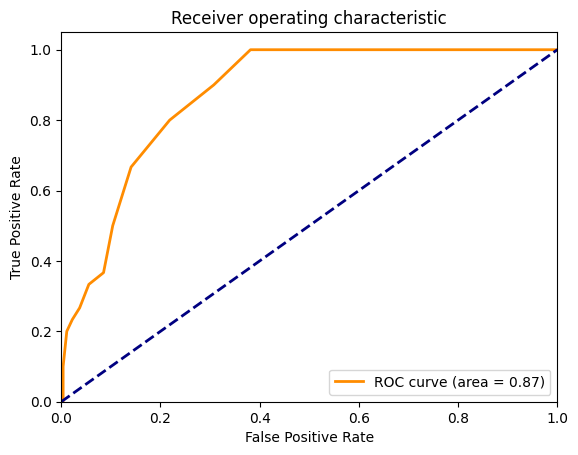

min bootstrapping aucroc:
0.8037372843874392
max bootstrapping aucroc:
0.9314499158249159
p_onesided = 1

Target_AUC = 0
p_twosided_1 = 1
p_twosided_2 = 0
p_twosided = 0
boots_mean_AUCROC =
0.8737500686410942(0.8279704912886517,0.9167005833672501)

...END AUCROC

FINISH


Input Data: cbcl
Wave: optimal
Ksads Reporter: parent
Hypothesis: 2a
Sex: both


BEGIN LOADING KSADS...

...FINISH LOADING KSADS
BEGIN LOADING CBCL...
...FINISH LOADING CBCL
BEGIN MERGING...
...FINISH MERGING
BEGIN PREPROCESSING...

Last check of missing data. Non-null rows = 0

Check that positives and negatives dont overlap
Index([], dtype='object', name='src_subject_id')
FINAL Number of positives in the data n=83
Number of negatives in the data (before subsampling) n=1372
Overall sample size (before subsampling) n=1455
FINAL Number of negatives in the data (after subsampling) n=747
FINAL Overall sample size (before subsampling) n=830
demo_sex_v2
1.0    460
2.0    369
Name: count, dtype: int64
Positive girls in samp

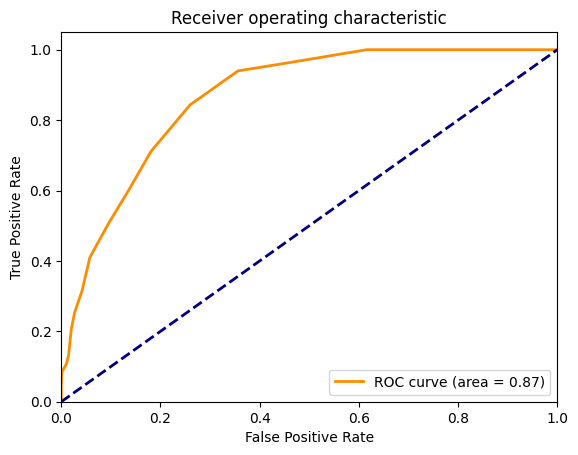

min bootstrapping aucroc:
0.8074056199056199
max bootstrapping aucroc:
0.9203250000000001
p_onesided = 1

Target_AUC = 0
p_twosided_1 = 1
p_twosided_2 = 0
p_twosided = 0
boots_mean_AUCROC =
0.8674823754042714(0.8317180468236444,0.8981556429232191)

...END AUCROC

FINISH


Input Data: cbcl
Wave: baseline
Ksads Reporter: parent
Hypothesis: 2b
Sex: both


BEGIN LOADING KSADS...

...FINISH LOADING KSADS
BEGIN LOADING CBCL...
...FINISH LOADING CBCL
BEGIN MERGING...
...FINISH MERGING
BEGIN PREPROCESSING...

Last check of missing data. Non-null rows = 0

Check that positives and negatives dont overlap
Index([], dtype='object', name='src_subject_id')
FINAL Number of positives in the data n=11
Number of negatives in the data (before subsampling) n=999
Overall sample size (before subsampling) n=1010
FINAL Number of negatives in the data (after subsampling) n=99
FINAL Overall sample size (before subsampling) n=110
demo_sex_v2
1.0    57
2.0    53
Name: count, dtype: int64
Positive girls in sample 

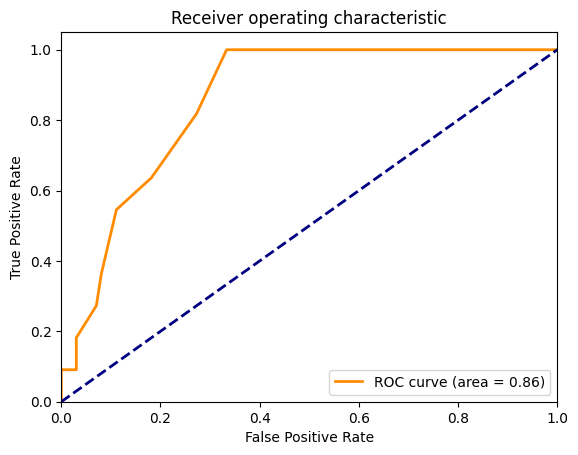

min bootstrapping aucroc:
0.7238723872387238
max bootstrapping aucroc:
0.9870283018867925
p_onesided = 1

Target_AUC = 0
p_twosided_1 = 1
p_twosided_2 = 0
p_twosided = 0
boots_mean_AUCROC =
0.8574723590023057(0.7642163661581137,0.9322916666666666)

...END AUCROC

FINISH


Input Data: cbcl
Wave: optimal
Ksads Reporter: parent
Hypothesis: 2b
Sex: both


BEGIN LOADING KSADS...

...FINISH LOADING KSADS
BEGIN LOADING CBCL...
...FINISH LOADING CBCL
BEGIN MERGING...
...FINISH MERGING
BEGIN PREPROCESSING...

Last check of missing data. Non-null rows = 0

Check that positives and negatives dont overlap
Index([], dtype='object', name='src_subject_id')
FINAL Number of positives in the data n=33
Number of negatives in the data (before subsampling) n=1372
Overall sample size (before subsampling) n=1405
FINAL Number of negatives in the data (after subsampling) n=297
FINAL Overall sample size (before subsampling) n=330
demo_sex_v2
1.0    173
2.0    156
Name: count, dtype: int64
Positive girls in samp

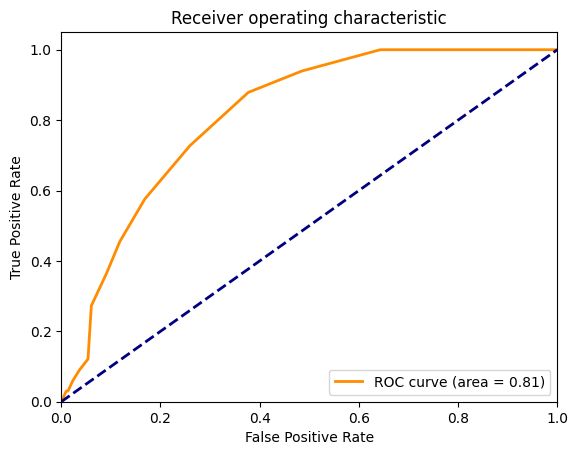

min bootstrapping aucroc:
0.6910871806621606
max bootstrapping aucroc:
0.9051489093959731
p_onesided = 0

Target_AUC = 0
p_twosided_1 = 0
p_twosided_2 = 0
p_twosided = 0
boots_mean_AUCROC =
0.8138357037470111(0.7498427013422818,0.871406316385781)

...END AUCROC

FINISH


Input Data: cbcl
Wave: baseline
Ksads Reporter: child
Hypothesis: 1
Sex: both


BEGIN LOADING KSADS...

...FINISH LOADING KSADS
BEGIN LOADING CBCL...
...FINISH LOADING CBCL
BEGIN MERGING...
...FINISH MERGING
BEGIN PREPROCESSING...

Last check of missing data. Non-null rows = 0

Check that positives and negatives dont overlap
Index([], dtype='object', name='src_subject_id')
FINAL Number of positives in the data n=119
Number of negatives in the data (before subsampling) n=11666
Overall sample size (before subsampling) n=11785
FINAL Number of negatives in the data (after subsampling) n=1071
FINAL Overall sample size (before subsampling) n=1190
demo_sex_v2
1.0    613
2.0    576
Name: count, dtype: int64
Positive girls in s

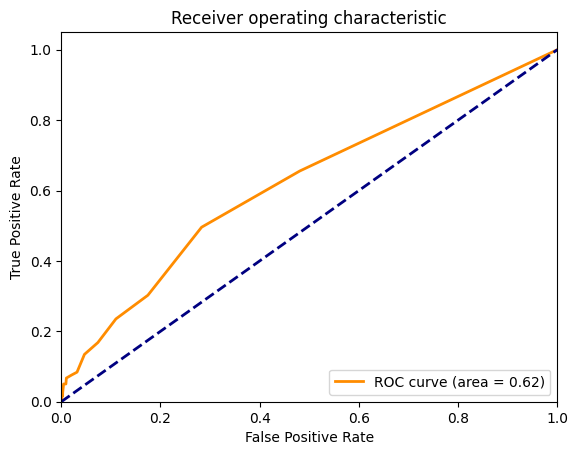

min bootstrapping aucroc:
0.513484990619137
max bootstrapping aucroc:
0.6987293713478457
p_onesided = 0

Target_AUC = 0
p_twosided_1 = 0
p_twosided_2 = 1
p_twosided = 0
boots_mean_AUCROC =
0.6188897431799457(0.5650627457856373,0.6716160220994476)

...END AUCROC

FINISH


Input Data: cbcl
Wave: optimal
Ksads Reporter: child
Hypothesis: 1
Sex: both


BEGIN LOADING KSADS...

...FINISH LOADING KSADS
BEGIN LOADING CBCL...
...FINISH LOADING CBCL
BEGIN MERGING...
...FINISH MERGING
BEGIN PREPROCESSING...

Last check of missing data. Non-null rows = 0

Check that positives and negatives dont overlap
Index([], dtype='object', name='src_subject_id')
FINAL Number of positives in the data n=96
Number of negatives in the data (before subsampling) n=10683
Overall sample size (before subsampling) n=10779
FINAL Number of negatives in the data (after subsampling) n=864
FINAL Overall sample size (before subsampling) n=960
demo_sex_v2
1.0    498
2.0    460
Name: count, dtype: int64
Positive girls in sampl

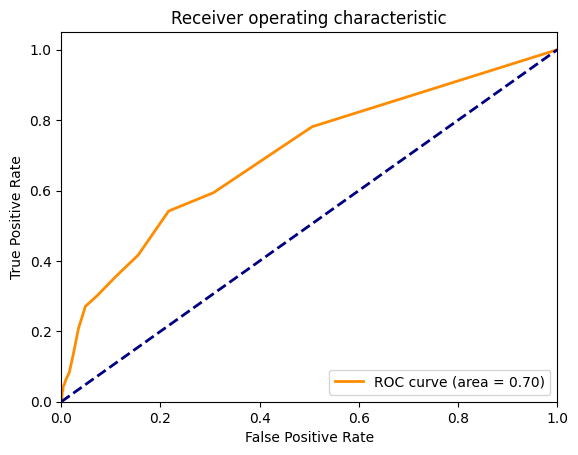

min bootstrapping aucroc:
0.6028806584362139
max bootstrapping aucroc:
0.7854085127201567
p_onesided = 0

Target_AUC = 0
p_twosided_1 = 0
p_twosided_2 = 1
p_twosided = 0
boots_mean_AUCROC =
0.7017651552669835(0.6426994580248292,0.7570586495162758)

...END AUCROC

FINISH


Input Data: cbcl
Wave: baseline
Ksads Reporter: child
Hypothesis: 2a
Sex: both


BEGIN LOADING KSADS...

...FINISH LOADING KSADS
BEGIN LOADING CBCL...
...FINISH LOADING CBCL
BEGIN MERGING...
...FINISH MERGING
BEGIN PREPROCESSING...

Last check of missing data. Non-null rows = 0

Check that positives and negatives dont overlap
Index([], dtype='object', name='src_subject_id')
FINAL Number of positives in the data n=119
Number of negatives in the data (before subsampling) n=78
Overall sample size (before subsampling) n=197
Not enough negative samples to use the desired neg/pos rate. Using all negative samples
FINAL Number of negatives in the data (after subsampling) n=78
FINAL Overall sample size (before subsampling) n=1

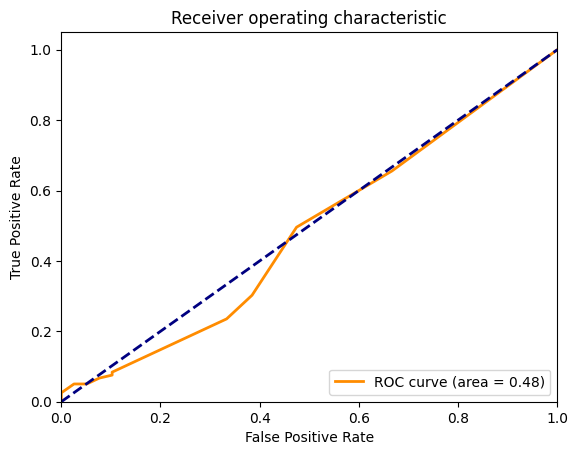

min bootstrapping aucroc:
0.34746922024623805
max bootstrapping aucroc:
0.6041801335918984
p_onesided = 0

Target_AUC = 0
p_twosided_1 = 0
p_twosided_2 = 1
p_twosided = 0
boots_mean_AUCROC =
0.47801231764244934(0.39750795334040295,0.5577922077922077)

...END AUCROC

FINISH


Input Data: cbcl
Wave: optimal
Ksads Reporter: child
Hypothesis: 2a
Sex: both


BEGIN LOADING KSADS...

...FINISH LOADING KSADS
BEGIN LOADING CBCL...
...FINISH LOADING CBCL
BEGIN MERGING...
...FINISH MERGING
BEGIN PREPROCESSING...

Last check of missing data. Non-null rows = 0

Check that positives and negatives dont overlap
Index([], dtype='object', name='src_subject_id')
FINAL Number of positives in the data n=96
Number of negatives in the data (before subsampling) n=118
Overall sample size (before subsampling) n=214
Not enough negative samples to use the desired neg/pos rate. Using all negative samples
FINAL Number of negatives in the data (after subsampling) n=118
FINAL Overall sample size (before subsampling) 

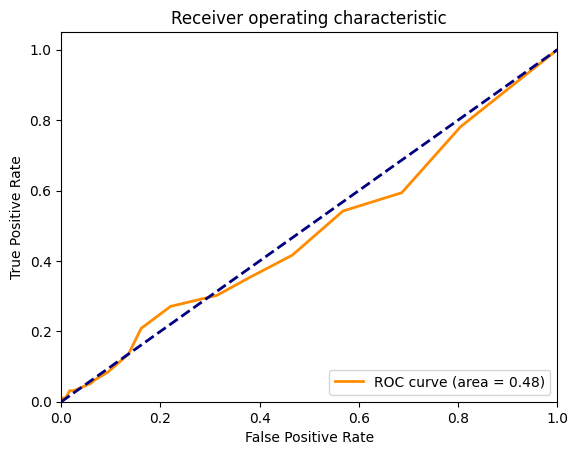

min bootstrapping aucroc:
0.356594279661017
max bootstrapping aucroc:
0.5986842105263158
p_onesided = 0

Target_AUC = 0
p_twosided_1 = 0
p_twosided_2 = 1
p_twosided = 0
boots_mean_AUCROC =
0.4805438570273501(0.40485124631466096,0.553647881170817)

...END AUCROC

FINISH


Input Data: cbcl
Wave: baseline
Ksads Reporter: child
Hypothesis: 2b
Sex: both


BEGIN LOADING KSADS...

...FINISH LOADING KSADS
BEGIN LOADING CBCL...
...FINISH LOADING CBCL
BEGIN MERGING...
...FINISH MERGING
BEGIN PREPROCESSING...

Last check of missing data. Non-null rows = 0

Check that positives and negatives dont overlap
Index([], dtype='object', name='src_subject_id')
FINAL Number of positives in the data n=105
Number of negatives in the data (before subsampling) n=78
Overall sample size (before subsampling) n=183
Not enough negative samples to use the desired neg/pos rate. Using all negative samples
FINAL Number of negatives in the data (after subsampling) n=78
FINAL Overall sample size (before subsampling) n=18

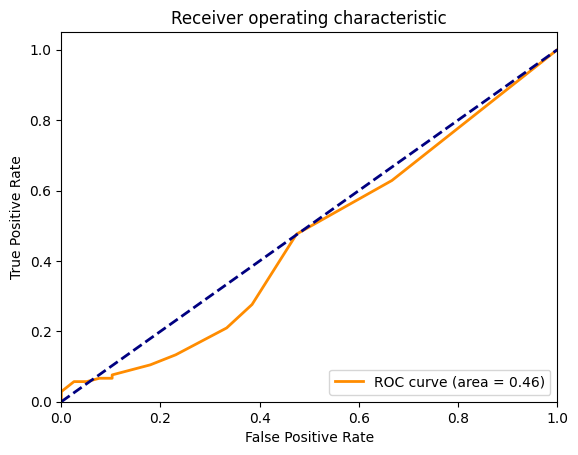

min bootstrapping aucroc:
0.30577213279678067
max bootstrapping aucroc:
0.6009101941747573
p_onesided = 0

Target_AUC = 0
p_twosided_1 = 0
p_twosided_2 = 1
p_twosided = 0
boots_mean_AUCROC =
0.45862293811753996(0.37186379928315416,0.5496031746031745)

...END AUCROC

FINISH


Input Data: cbcl
Wave: optimal
Ksads Reporter: child
Hypothesis: 2b
Sex: both


BEGIN LOADING KSADS...

...FINISH LOADING KSADS
BEGIN LOADING CBCL...
...FINISH LOADING CBCL
BEGIN MERGING...
...FINISH MERGING
BEGIN PREPROCESSING...

Last check of missing data. Non-null rows = 0

Check that positives and negatives dont overlap
Index([], dtype='object', name='src_subject_id')
FINAL Number of positives in the data n=71
Number of negatives in the data (before subsampling) n=118
Overall sample size (before subsampling) n=189
Not enough negative samples to use the desired neg/pos rate. Using all negative samples
FINAL Number of negatives in the data (after subsampling) n=118
FINAL Overall sample size (before subsampling) 

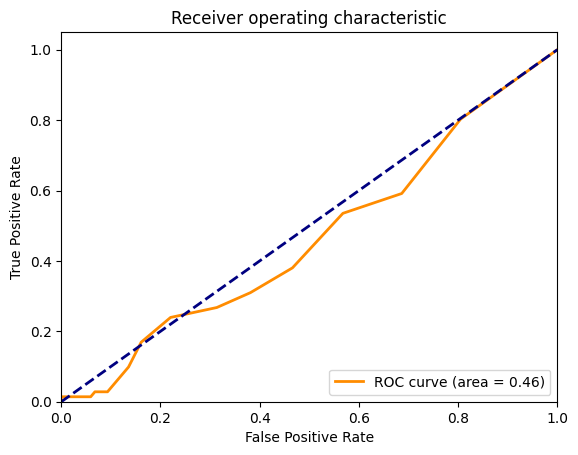

min bootstrapping aucroc:
0.3330024813895782
max bootstrapping aucroc:
0.6266827533655067
p_onesided = 0

Target_AUC = 0
p_twosided_1 = 0
p_twosided_2 = 1
p_twosided = 0
boots_mean_AUCROC =
0.4661439920421148(0.38466183574879226,0.5479425958851918)

...END AUCROC

FINISH


 FINISH CBCL-AFF

BEGIN LOADING KSADS...

...FINISH LOADING KSADS
BEGIN LOADING CBCL, anx/dep or with/dep...
...FINISH LOADING CBCL, anx/dep or with/dep...
BEGIN MERGING...
...FINISH MERGING
BEGIN PREPROCESSING...

Last check of missing data. Non-null rows = 0

Check that positives and negatives dont overlap
Index([], dtype='object', name='src_subject_id')
FINAL Number of positives in the data n=30
Number of negatives in the data (before subsampling) n=6154
Overall sample size (before subsampling) n=6184
FINAL Number of negatives in the data (after subsampling) n=270
FINAL Overall sample size (before subsampling) n=300
demo_sex_v2
2.0    156
1.0    144
Name: count, dtype: int64
Positive girls in sample = 19
Positive 

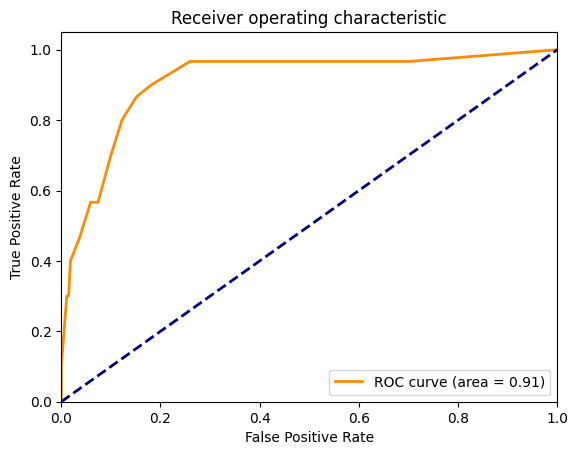

min bootstrapping aucroc:
0.7979908962486266
max bootstrapping aucroc:
0.9892631993695824
p_onesided = 1

Target_AUC = 0
p_twosided_1 = 1
p_twosided_2 = 0
p_twosided = 0
boots_mean_AUCROC =
0.9107474540769476(0.8436593275302953,0.9583928571428572)

...END AUCROC
BEGIN LOADING KSADS...

...FINISH LOADING KSADS
BEGIN LOADING CBCL, anx/dep or with/dep...
...FINISH LOADING CBCL, anx/dep or with/dep...
BEGIN MERGING...
...FINISH MERGING
BEGIN PREPROCESSING...

Last check of missing data. Non-null rows = 0

Check that positives and negatives dont overlap
Index([], dtype='object', name='src_subject_id')
FINAL Number of positives in the data n=30
Number of negatives in the data (before subsampling) n=999
Overall sample size (before subsampling) n=1029
FINAL Number of negatives in the data (after subsampling) n=270
FINAL Overall sample size (before subsampling) n=300
demo_sex_v2
1.0    175
2.0    125
Name: count, dtype: int64
Positive girls in sample = 19
Positive boys in sample = 11

...END PR

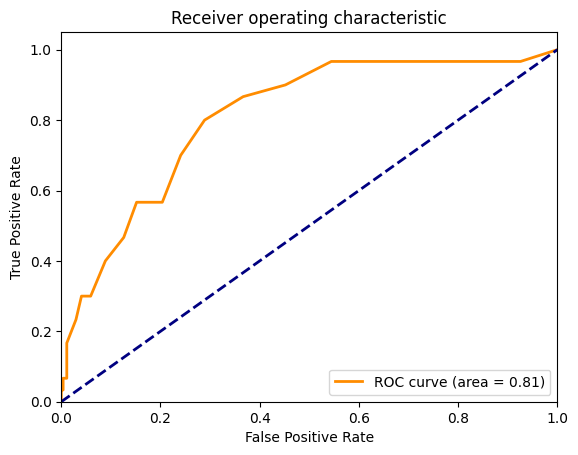

min bootstrapping aucroc:
0.6426785714285714
max bootstrapping aucroc:
0.9143631136665192
p_onesided = 0

Target_AUC = 0
p_twosided_1 = 0
p_twosided_2 = 0
p_twosided = 0
boots_mean_AUCROC =
0.8081272978488305(0.7270152505446623,0.877864556571781)

...END AUCROC
BEGIN LOADING KSADS...

...FINISH LOADING KSADS
BEGIN LOADING CBCL, anx/dep or with/dep...
...FINISH LOADING CBCL, anx/dep or with/dep...
BEGIN MERGING...
...FINISH MERGING
BEGIN PREPROCESSING...

Last check of missing data. Non-null rows = 0

Check that positives and negatives dont overlap
Index([], dtype='object', name='src_subject_id')
FINAL Number of positives in the data n=11
Number of negatives in the data (before subsampling) n=999
Overall sample size (before subsampling) n=1010
FINAL Number of negatives in the data (after subsampling) n=99
FINAL Overall sample size (before subsampling) n=110
demo_sex_v2
1.0    57
2.0    53
Name: count, dtype: int64
Positive girls in sample = 8
Positive boys in sample = 3

...END PREPROCE

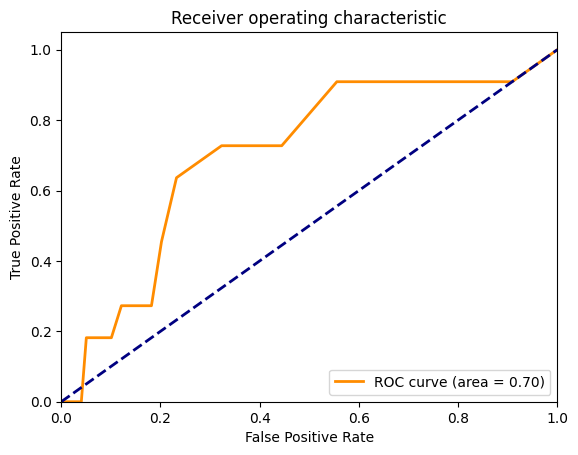

min bootstrapping aucroc:
0.36397058823529416
max bootstrapping aucroc:
0.9102564102564102
p_onesided = 0

Target_AUC = 0
p_twosided_1 = 0
p_twosided_2 = 0
p_twosided = 0
boots_mean_AUCROC =
0.7025093728404129(0.5375744047619048,0.8540840602696272)

...END AUCROC
BEGIN LOADING KSADS...

...FINISH LOADING KSADS
BEGIN LOADING CBCL, anx/dep or with/dep...
...FINISH LOADING CBCL, anx/dep or with/dep...
BEGIN MERGING...
...FINISH MERGING
BEGIN PREPROCESSING...

Last check of missing data. Non-null rows = 0

Check that positives and negatives dont overlap
Index([], dtype='object', name='src_subject_id')
FINAL Number of positives in the data n=30
Number of negatives in the data (before subsampling) n=6154
Overall sample size (before subsampling) n=6184
FINAL Number of negatives in the data (after subsampling) n=270
FINAL Overall sample size (before subsampling) n=300
demo_sex_v2
2.0    156
1.0    144
Name: count, dtype: int64
Positive girls in sample = 19
Positive boys in sample = 11

...END 

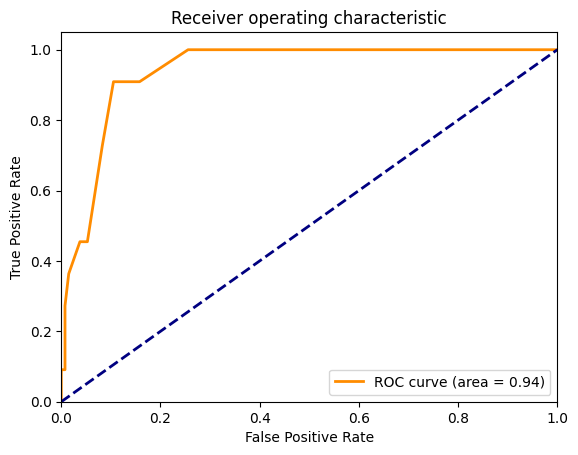

min bootstrapping aucroc:
0.8251028806584363
max bootstrapping aucroc:
0.9964028776978417
p_onesided = 1

Target_AUC = 0
p_twosided_1 = 1
p_twosided_2 = 0
p_twosided = 0
boots_mean_AUCROC =
0.9412326692068996(0.8864889705882353,0.9788106630211894)

...END AUCROC
BEGIN LOADING KSADS...

...FINISH LOADING KSADS
BEGIN LOADING CBCL, anx/dep or with/dep...
...FINISH LOADING CBCL, anx/dep or with/dep...
BEGIN MERGING...
...FINISH MERGING
BEGIN PREPROCESSING...

Last check of missing data. Non-null rows = 0

Check that positives and negatives dont overlap
Index([], dtype='object', name='src_subject_id')
FINAL Number of positives in the data n=30
Number of negatives in the data (before subsampling) n=999
Overall sample size (before subsampling) n=1029
FINAL Number of negatives in the data (after subsampling) n=270
FINAL Overall sample size (before subsampling) n=300
demo_sex_v2
1.0    175
2.0    125
Name: count, dtype: int64
Positive girls in sample = 19
Positive boys in sample = 11

...END PR

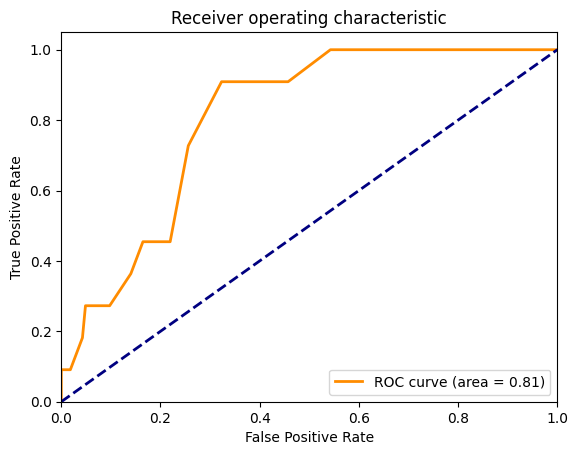

min bootstrapping aucroc:
0.5833333333333333
max bootstrapping aucroc:
0.9525193798449613
p_onesided = 0

Target_AUC = 0
p_twosided_1 = 0
p_twosided_2 = 0
p_twosided = 0
boots_mean_AUCROC =
0.8048860129037596(0.6957364341085271,0.9027161862527717)

...END AUCROC
BEGIN LOADING KSADS...

...FINISH LOADING KSADS
BEGIN LOADING CBCL, anx/dep or with/dep...
...FINISH LOADING CBCL, anx/dep or with/dep...
BEGIN MERGING...
...FINISH MERGING
BEGIN PREPROCESSING...

Last check of missing data. Non-null rows = 0

Check that positives and negatives dont overlap
Index([], dtype='object', name='src_subject_id')
FINAL Number of positives in the data n=11
Number of negatives in the data (before subsampling) n=999
Overall sample size (before subsampling) n=1010
FINAL Number of negatives in the data (after subsampling) n=99
FINAL Overall sample size (before subsampling) n=110
demo_sex_v2
1.0    57
2.0    53
Name: count, dtype: int64
Positive girls in sample = 8
Positive boys in sample = 3

...END PREPROC

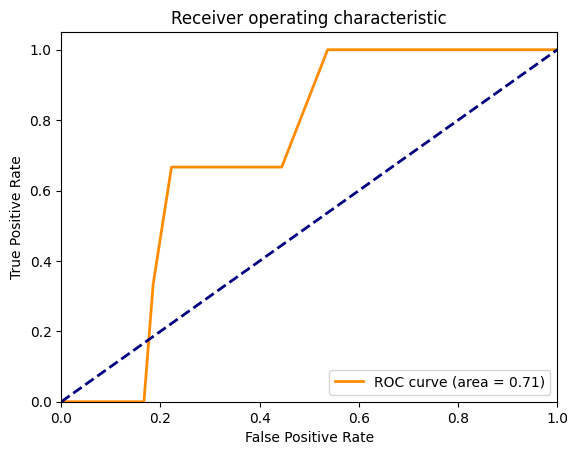

BEGIN LOADING KSADS...

...FINISH LOADING KSADS
BEGIN LOADING CBCL, anx/dep or with/dep...
...FINISH LOADING CBCL, anx/dep or with/dep...
BEGIN MERGING...
...FINISH MERGING
BEGIN PREPROCESSING...

Last check of missing data. Non-null rows = 0

Check that positives and negatives dont overlap
Index([], dtype='object', name='src_subject_id')
FINAL Number of positives in the data n=30
Number of negatives in the data (before subsampling) n=6154
Overall sample size (before subsampling) n=6184
FINAL Number of negatives in the data (after subsampling) n=270
FINAL Overall sample size (before subsampling) n=300
demo_sex_v2
2.0    156
1.0    144
Name: count, dtype: int64
Positive girls in sample = 19
Positive boys in sample = 11

...END PREPROCESSING

START ANALYSIS


Input Data: CBCL anx/dex or with/dep
Scale: anxiousdep
Wave: baseline
Ksads Reporter: parent
Hypothesis: 1
Sex: girls
BEGIN AUCROC...

Single AUCROC score without bootstrapping:
0.9408749145591251


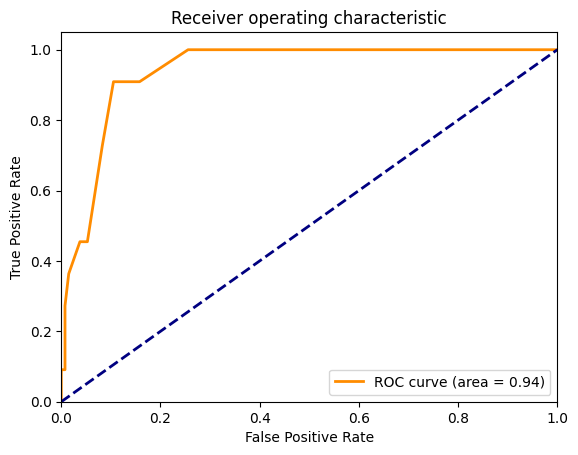

min bootstrapping aucroc:
0.7952898550724639
max bootstrapping aucroc:
0.9921085858585859
p_onesided = 1

Target_AUC = 0
p_twosided_1 = 1
p_twosided_2 = 0
p_twosided = 0
boots_mean_AUCROC =
0.940338318877337(0.8852971845672576,0.9794238683127572)

...END AUCROC
BEGIN LOADING KSADS...

...FINISH LOADING KSADS
BEGIN LOADING CBCL, anx/dep or with/dep...
...FINISH LOADING CBCL, anx/dep or with/dep...
BEGIN MERGING...
...FINISH MERGING
BEGIN PREPROCESSING...

Last check of missing data. Non-null rows = 0

Check that positives and negatives dont overlap
Index([], dtype='object', name='src_subject_id')
FINAL Number of positives in the data n=30
Number of negatives in the data (before subsampling) n=999
Overall sample size (before subsampling) n=1029
FINAL Number of negatives in the data (after subsampling) n=270
FINAL Overall sample size (before subsampling) n=300
demo_sex_v2
1.0    175
2.0    125
Name: count, dtype: int64
Positive girls in sample = 19
Positive boys in sample = 11

...END PRE

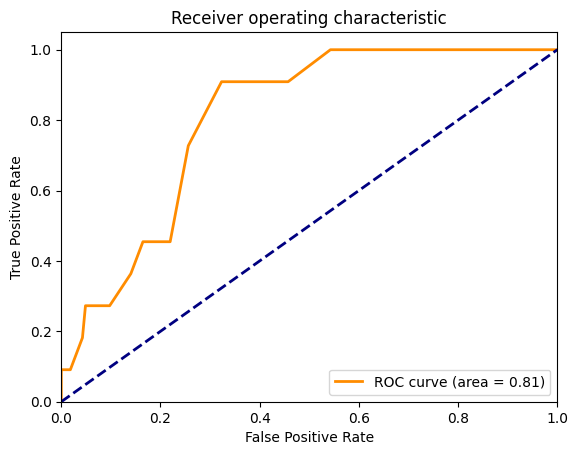

min bootstrapping aucroc:
0.5815868263473053
max bootstrapping aucroc:
0.9506802721088435
p_onesided = 0

Target_AUC = 0
p_twosided_1 = 0
p_twosided_2 = 0
p_twosided = 0
boots_mean_AUCROC =
0.8070704484124887(0.6966666666666667,0.9009090909090909)

...END AUCROC
BEGIN LOADING KSADS...

...FINISH LOADING KSADS
BEGIN LOADING CBCL, anx/dep or with/dep...
...FINISH LOADING CBCL, anx/dep or with/dep...
BEGIN MERGING...
...FINISH MERGING
BEGIN PREPROCESSING...

Last check of missing data. Non-null rows = 0

Check that positives and negatives dont overlap
Index([], dtype='object', name='src_subject_id')
FINAL Number of positives in the data n=11
Number of negatives in the data (before subsampling) n=999
Overall sample size (before subsampling) n=1010
FINAL Number of negatives in the data (after subsampling) n=99
FINAL Overall sample size (before subsampling) n=110
demo_sex_v2
1.0    57
2.0    53
Name: count, dtype: int64
Positive girls in sample = 8
Positive boys in sample = 3

...END PREPROC

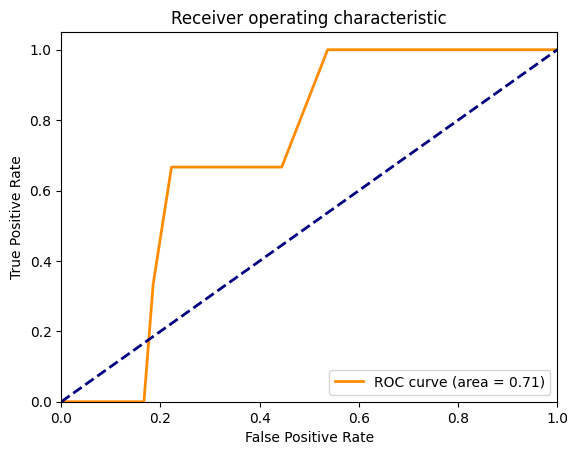

BEGIN LOADING KSADS...

...FINISH LOADING KSADS
BEGIN LOADING CBCL, anx/dep or with/dep...
...FINISH LOADING CBCL, anx/dep or with/dep...
BEGIN MERGING...
...FINISH MERGING
BEGIN PREPROCESSING...

Last check of missing data. Non-null rows = 0

Check that positives and negatives dont overlap
Index([], dtype='object', name='src_subject_id')
FINAL Number of positives in the data n=30
Number of negatives in the data (before subsampling) n=6154
Overall sample size (before subsampling) n=6184
FINAL Number of negatives in the data (after subsampling) n=270
FINAL Overall sample size (before subsampling) n=300
demo_sex_v2
2.0    156
1.0    144
Name: count, dtype: int64
Positive girls in sample = 19
Positive boys in sample = 11

...END PREPROCESSING

START ANALYSIS


Input Data: CBCL anx/dex or with/dep
Scale: withdrawndep
Wave: baseline
Ksads Reporter: parent
Hypothesis: 1
Sex: both
BEGIN AUCROC...

Single AUCROC score without bootstrapping:
0.9142592592592593


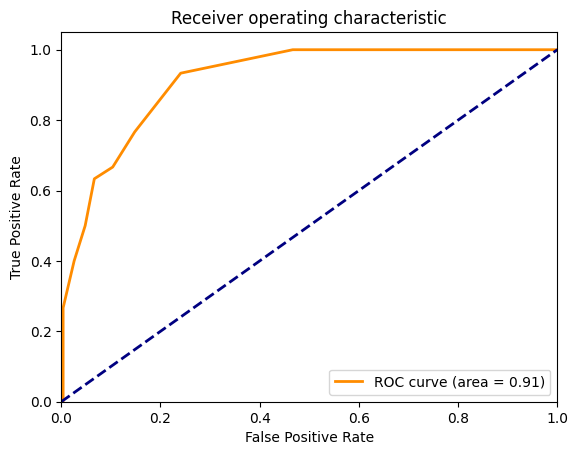

min bootstrapping aucroc:
0.8503649635036495
max bootstrapping aucroc:
0.9730286570518824
p_onesided = 1

Target_AUC = 0
p_twosided_1 = 1
p_twosided_2 = 0
p_twosided = 0
boots_mean_AUCROC =
0.9144243485402638(0.8684025828186412,0.9547101449275363)

...END AUCROC
BEGIN LOADING KSADS...

...FINISH LOADING KSADS
BEGIN LOADING CBCL, anx/dep or with/dep...
...FINISH LOADING CBCL, anx/dep or with/dep...
BEGIN MERGING...
...FINISH MERGING
BEGIN PREPROCESSING...

Last check of missing data. Non-null rows = 0

Check that positives and negatives dont overlap
Index([], dtype='object', name='src_subject_id')
FINAL Number of positives in the data n=30
Number of negatives in the data (before subsampling) n=999
Overall sample size (before subsampling) n=1029
FINAL Number of negatives in the data (after subsampling) n=270
FINAL Overall sample size (before subsampling) n=300
demo_sex_v2
1.0    175
2.0    125
Name: count, dtype: int64
Positive girls in sample = 19
Positive boys in sample = 11

...END PR

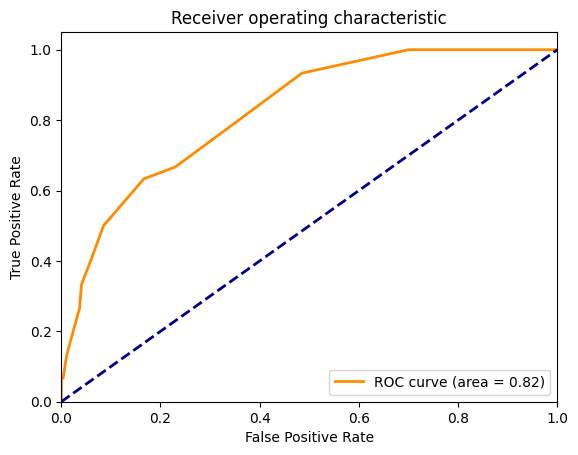

min bootstrapping aucroc:
0.7025584680583896
max bootstrapping aucroc:
0.9563636363636364
p_onesided = 0

Target_AUC = 0
p_twosided_1 = 0
p_twosided_2 = 0
p_twosided = 0
boots_mean_AUCROC =
0.8254906416709992(0.74875262605042,0.8874227961819202)

...END AUCROC
BEGIN LOADING KSADS...

...FINISH LOADING KSADS
BEGIN LOADING CBCL, anx/dep or with/dep...
...FINISH LOADING CBCL, anx/dep or with/dep...
BEGIN MERGING...
...FINISH MERGING
BEGIN PREPROCESSING...

Last check of missing data. Non-null rows = 0

Check that positives and negatives dont overlap
Index([], dtype='object', name='src_subject_id')
FINAL Number of positives in the data n=11
Number of negatives in the data (before subsampling) n=999
Overall sample size (before subsampling) n=1010
FINAL Number of negatives in the data (after subsampling) n=99
FINAL Overall sample size (before subsampling) n=110
demo_sex_v2
1.0    57
2.0    53
Name: count, dtype: int64
Positive girls in sample = 8
Positive boys in sample = 3

...END PREPROCES

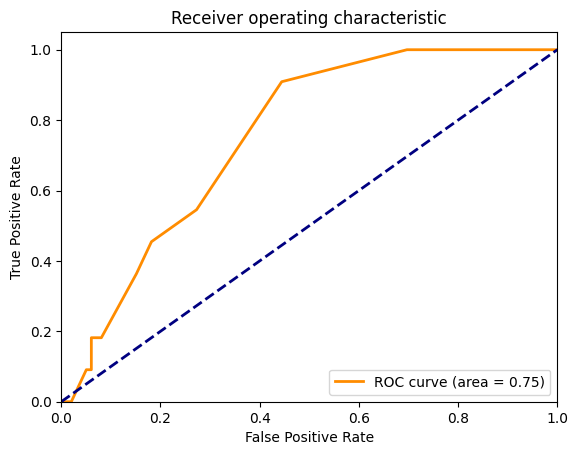

min bootstrapping aucroc:
0.47596153846153844
max bootstrapping aucroc:
0.9267912772585669
p_onesided = 0

Target_AUC = 0
p_twosided_1 = 0
p_twosided_2 = 0
p_twosided = 0
boots_mean_AUCROC =
0.7510039633562868(0.6346409574468085,0.8542857142857143)

...END AUCROC
BEGIN LOADING KSADS...

...FINISH LOADING KSADS
BEGIN LOADING CBCL, anx/dep or with/dep...
...FINISH LOADING CBCL, anx/dep or with/dep...
BEGIN MERGING...
...FINISH MERGING
BEGIN PREPROCESSING...

Last check of missing data. Non-null rows = 0

Check that positives and negatives dont overlap
Index([], dtype='object', name='src_subject_id')
FINAL Number of positives in the data n=30
Number of negatives in the data (before subsampling) n=6154
Overall sample size (before subsampling) n=6184
FINAL Number of negatives in the data (after subsampling) n=270
FINAL Overall sample size (before subsampling) n=300
demo_sex_v2
2.0    156
1.0    144
Name: count, dtype: int64
Positive girls in sample = 19
Positive boys in sample = 11

...END 

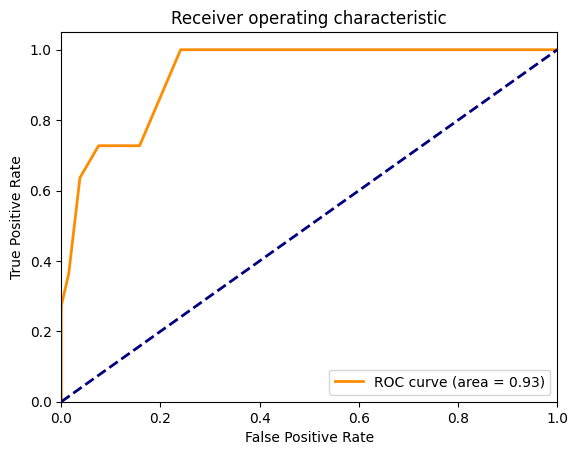

min bootstrapping aucroc:
0.7690647482014388
max bootstrapping aucroc:
0.9965823650034176
p_onesided = 0

Target_AUC = 0
p_twosided_1 = 0
p_twosided_2 = 0
p_twosided = 0
boots_mean_AUCROC =
0.9325560758094108(0.872790404040404,0.9824289405684754)

...END AUCROC
BEGIN LOADING KSADS...

...FINISH LOADING KSADS
BEGIN LOADING CBCL, anx/dep or with/dep...
...FINISH LOADING CBCL, anx/dep or with/dep...
BEGIN MERGING...
...FINISH MERGING
BEGIN PREPROCESSING...

Last check of missing data. Non-null rows = 0

Check that positives and negatives dont overlap
Index([], dtype='object', name='src_subject_id')
FINAL Number of positives in the data n=30
Number of negatives in the data (before subsampling) n=999
Overall sample size (before subsampling) n=1029
FINAL Number of negatives in the data (after subsampling) n=270
FINAL Overall sample size (before subsampling) n=300
demo_sex_v2
1.0    175
2.0    125
Name: count, dtype: int64
Positive girls in sample = 19
Positive boys in sample = 11

...END PRE

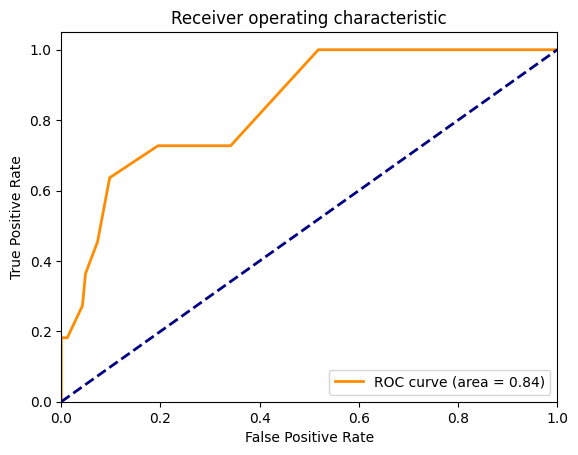

min bootstrapping aucroc:
0.64546783625731
max bootstrapping aucroc:
0.9827844311377245
p_onesided = 0

Target_AUC = 0
p_twosided_1 = 0
p_twosided_2 = 0
p_twosided = 0
boots_mean_AUCROC =
0.841904491142736(0.7223865877712032,0.9434589800443459)

...END AUCROC
BEGIN LOADING KSADS...

...FINISH LOADING KSADS
BEGIN LOADING CBCL, anx/dep or with/dep...
...FINISH LOADING CBCL, anx/dep or with/dep...
BEGIN MERGING...
...FINISH MERGING
BEGIN PREPROCESSING...

Last check of missing data. Non-null rows = 0

Check that positives and negatives dont overlap
Index([], dtype='object', name='src_subject_id')
FINAL Number of positives in the data n=11
Number of negatives in the data (before subsampling) n=999
Overall sample size (before subsampling) n=1010
FINAL Number of negatives in the data (after subsampling) n=99
FINAL Overall sample size (before subsampling) n=110
demo_sex_v2
1.0    57
2.0    53
Name: count, dtype: int64
Positive girls in sample = 8
Positive boys in sample = 3

...END PREPROCESS

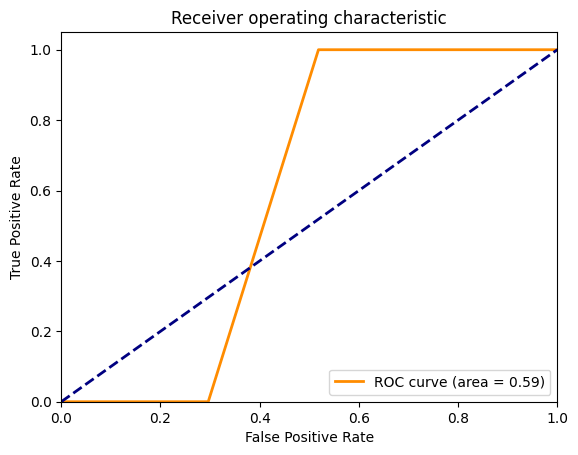

BEGIN LOADING KSADS...

...FINISH LOADING KSADS
BEGIN LOADING CBCL, anx/dep or with/dep...
...FINISH LOADING CBCL, anx/dep or with/dep...
BEGIN MERGING...
...FINISH MERGING
BEGIN PREPROCESSING...

Last check of missing data. Non-null rows = 0

Check that positives and negatives dont overlap
Index([], dtype='object', name='src_subject_id')
FINAL Number of positives in the data n=30
Number of negatives in the data (before subsampling) n=6154
Overall sample size (before subsampling) n=6184
FINAL Number of negatives in the data (after subsampling) n=270
FINAL Overall sample size (before subsampling) n=300
demo_sex_v2
2.0    156
1.0    144
Name: count, dtype: int64
Positive girls in sample = 19
Positive boys in sample = 11

...END PREPROCESSING

START ANALYSIS


Input Data: CBCL anx/dex or with/dep
Scale: withdrawndep
Wave: baseline
Ksads Reporter: parent
Hypothesis: 1
Sex: girls
BEGIN AUCROC...

Single AUCROC score without bootstrapping:
0.9326725905673274


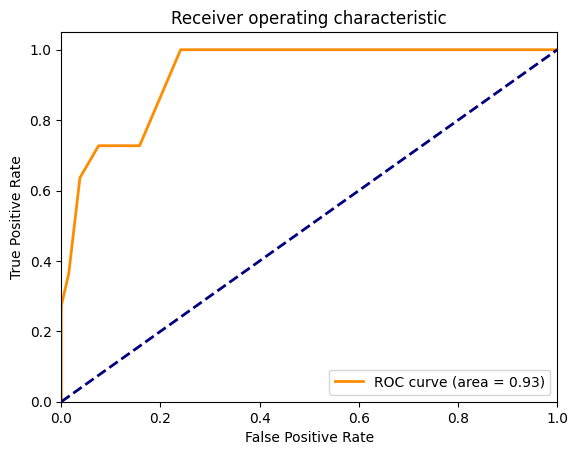

min bootstrapping aucroc:
0.8201438848920863
max bootstrapping aucroc:
0.997790404040404
p_onesided = 1

Target_AUC = 0
p_twosided_1 = 1
p_twosided_2 = 0
p_twosided = 0
boots_mean_AUCROC =
0.9312114767150123(0.8679012345679012,0.9827338129496404)

...END AUCROC
BEGIN LOADING KSADS...

...FINISH LOADING KSADS
BEGIN LOADING CBCL, anx/dep or with/dep...
...FINISH LOADING CBCL, anx/dep or with/dep...
BEGIN MERGING...
...FINISH MERGING
BEGIN PREPROCESSING...

Last check of missing data. Non-null rows = 0

Check that positives and negatives dont overlap
Index([], dtype='object', name='src_subject_id')
FINAL Number of positives in the data n=30
Number of negatives in the data (before subsampling) n=999
Overall sample size (before subsampling) n=1029
FINAL Number of negatives in the data (after subsampling) n=270
FINAL Overall sample size (before subsampling) n=300
demo_sex_v2
1.0    175
2.0    125
Name: count, dtype: int64
Positive girls in sample = 19
Positive boys in sample = 11

...END PRE

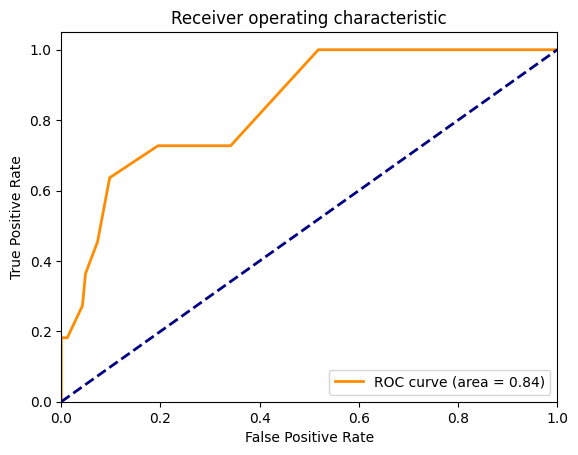

min bootstrapping aucroc:
0.6308567603748327
max bootstrapping aucroc:
0.9807692307692307
p_onesided = 0

Target_AUC = 0
p_twosided_1 = 0
p_twosided_2 = 0
p_twosided = 0
boots_mean_AUCROC =
0.8430350343747216(0.715528781793842,0.9435294117647058)

...END AUCROC
BEGIN LOADING KSADS...

...FINISH LOADING KSADS
BEGIN LOADING CBCL, anx/dep or with/dep...
...FINISH LOADING CBCL, anx/dep or with/dep...
BEGIN MERGING...
...FINISH MERGING
BEGIN PREPROCESSING...

Last check of missing data. Non-null rows = 0

Check that positives and negatives dont overlap
Index([], dtype='object', name='src_subject_id')
FINAL Number of positives in the data n=11
Number of negatives in the data (before subsampling) n=999
Overall sample size (before subsampling) n=1010
FINAL Number of negatives in the data (after subsampling) n=99
FINAL Overall sample size (before subsampling) n=110
demo_sex_v2
1.0    57
2.0    53
Name: count, dtype: int64
Positive girls in sample = 8
Positive boys in sample = 3

...END PREPROCE

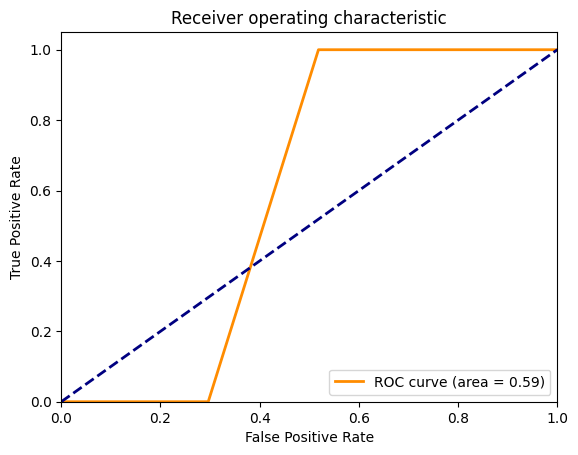

BEGIN LOADING KSADS...

...FINISH LOADING KSADS
BEGIN LOADING CBCL, anx/dep or with/dep...
...FINISH LOADING CBCL, anx/dep or with/dep...
BEGIN MERGING...
...FINISH MERGING
BEGIN PREPROCESSING...

Last check of missing data. Non-null rows = 0

Check that positives and negatives dont overlap
Index([], dtype='object', name='src_subject_id')
FINAL Number of positives in the data n=119
Number of negatives in the data (before subsampling) n=11667
Overall sample size (before subsampling) n=11786
FINAL Number of negatives in the data (after subsampling) n=1071
FINAL Overall sample size (before subsampling) n=1190
demo_sex_v2
1.0    612
2.0    577
Name: count, dtype: int64
Positive girls in sample = 43
Positive boys in sample = 76

...END PREPROCESSING

START ANALYSIS


Input Data: CBCL anx/dex or with/dep
Scale: anxiousdep
Wave: baseline
Ksads Reporter: child
Hypothesis: 1
Sex: both
BEGIN AUCROC...

Single AUCROC score without bootstrapping:
0.6287338464797683


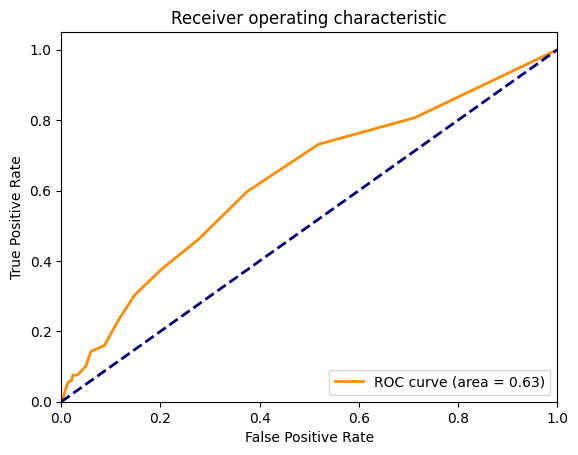

min bootstrapping aucroc:
0.5390166523214374
max bootstrapping aucroc:
0.7274396412327446
p_onesided = 0

Target_AUC = 0
p_twosided_1 = 0
p_twosided_2 = 1
p_twosided = 0
boots_mean_AUCROC =
0.6283377471932372(0.5765720249138617,0.6819495280292815)

...END AUCROC
BEGIN LOADING KSADS...

...FINISH LOADING KSADS
BEGIN LOADING CBCL, anx/dep or with/dep...
...FINISH LOADING CBCL, anx/dep or with/dep...
BEGIN MERGING...
...FINISH MERGING
BEGIN PREPROCESSING...

Last check of missing data. Non-null rows = 0

Check that positives and negatives dont overlap
Index([], dtype='object', name='src_subject_id')
FINAL Number of positives in the data n=119
Number of negatives in the data (before subsampling) n=78
Overall sample size (before subsampling) n=197
Not enough negative samples to use the desired neg/pos rate. Using all negative samples
FINAL Number of negatives in the data (after subsampling) n=78
FINAL Overall sample size (before subsampling) n=197
demo_sex_v2
1.0    116
2.0     81
Name: cou

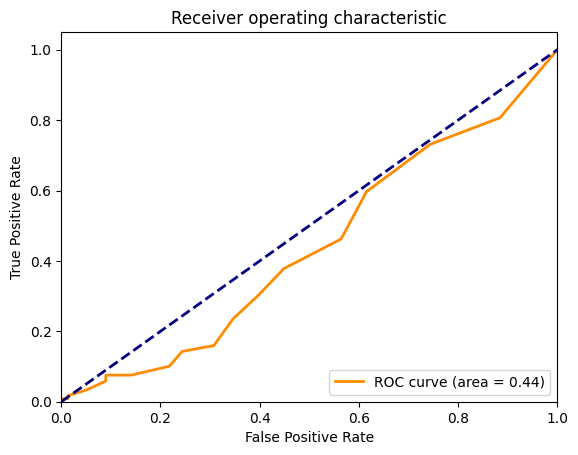

min bootstrapping aucroc:
0.316943380161771
max bootstrapping aucroc:
0.5845722904546434
p_onesided = 0

Target_AUC = 0
p_twosided_1 = 0
p_twosided_2 = 1
p_twosided = 0
boots_mean_AUCROC =
0.43844562286456934(0.35493119266055045,0.5307045551298425)

...END AUCROC
BEGIN LOADING KSADS...

...FINISH LOADING KSADS
BEGIN LOADING CBCL, anx/dep or with/dep...
...FINISH LOADING CBCL, anx/dep or with/dep...
BEGIN MERGING...
...FINISH MERGING
BEGIN PREPROCESSING...

Last check of missing data. Non-null rows = 0

Check that positives and negatives dont overlap
Index([], dtype='object', name='src_subject_id')
FINAL Number of positives in the data n=105
Number of negatives in the data (before subsampling) n=78
Overall sample size (before subsampling) n=183
Not enough negative samples to use the desired neg/pos rate. Using all negative samples
FINAL Number of negatives in the data (after subsampling) n=78
FINAL Overall sample size (before subsampling) n=183
demo_sex_v2
1.0    108
2.0     75
Name: co

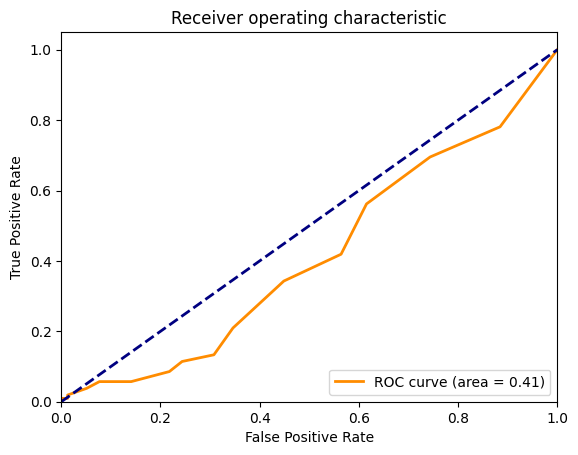

min bootstrapping aucroc:
0.27304921968787516
max bootstrapping aucroc:
0.5407647907647908
p_onesided = 0

Target_AUC = 0
p_twosided_1 = 0
p_twosided_2 = 1
p_twosided = 0
boots_mean_AUCROC =
0.41553976152217215(0.3337378640776699,0.49422799422799424)

...END AUCROC
BEGIN LOADING KSADS...

...FINISH LOADING KSADS
BEGIN LOADING CBCL, anx/dep or with/dep...
...FINISH LOADING CBCL, anx/dep or with/dep...
BEGIN MERGING...
...FINISH MERGING
BEGIN PREPROCESSING...

Last check of missing data. Non-null rows = 0

Check that positives and negatives dont overlap
Index([], dtype='object', name='src_subject_id')
FINAL Number of positives in the data n=119
Number of negatives in the data (before subsampling) n=11667
Overall sample size (before subsampling) n=11786
FINAL Number of negatives in the data (after subsampling) n=1071
FINAL Overall sample size (before subsampling) n=1190
demo_sex_v2
1.0    612
2.0    577
Name: count, dtype: int64
Positive girls in sample = 43
Positive boys in sample = 76



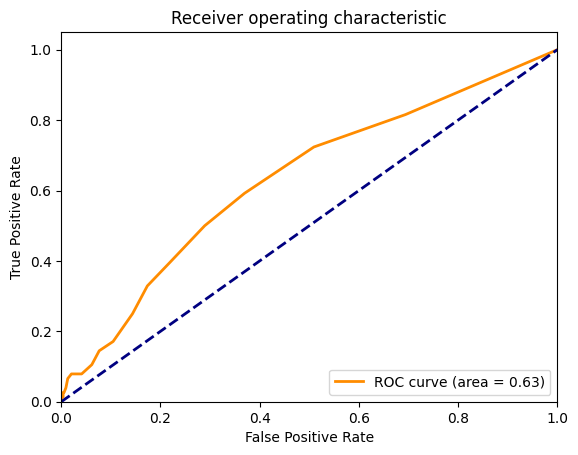

min bootstrapping aucroc:
0.5257217984431543
max bootstrapping aucroc:
0.7346835516234423
p_onesided = 0

Target_AUC = 0
p_twosided_1 = 0
p_twosided_2 = 1
p_twosided = 0
boots_mean_AUCROC =
0.6307036392424838(0.5650519031141868,0.6938050900062074)

...END AUCROC
BEGIN LOADING KSADS...

...FINISH LOADING KSADS
BEGIN LOADING CBCL, anx/dep or with/dep...
...FINISH LOADING CBCL, anx/dep or with/dep...
BEGIN MERGING...
...FINISH MERGING
BEGIN PREPROCESSING...

Last check of missing data. Non-null rows = 0

Check that positives and negatives dont overlap
Index([], dtype='object', name='src_subject_id')
FINAL Number of positives in the data n=119
Number of negatives in the data (before subsampling) n=78
Overall sample size (before subsampling) n=197
Not enough negative samples to use the desired neg/pos rate. Using all negative samples
FINAL Number of negatives in the data (after subsampling) n=78
FINAL Overall sample size (before subsampling) n=197
demo_sex_v2
1.0    116
2.0     81
Name: cou

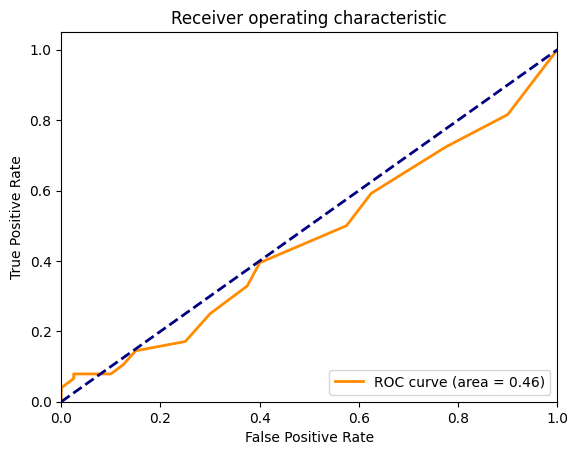

min bootstrapping aucroc:
0.27883472057074915
max bootstrapping aucroc:
0.6477933629832364
p_onesided = 0

Target_AUC = 0
p_twosided_1 = 0
p_twosided_2 = 1
p_twosided = 0
boots_mean_AUCROC =
0.46262029237388225(0.3590593434343434,0.5707625707625709)

...END AUCROC
BEGIN LOADING KSADS...

...FINISH LOADING KSADS
BEGIN LOADING CBCL, anx/dep or with/dep...
...FINISH LOADING CBCL, anx/dep or with/dep...
BEGIN MERGING...
...FINISH MERGING
BEGIN PREPROCESSING...

Last check of missing data. Non-null rows = 0

Check that positives and negatives dont overlap
Index([], dtype='object', name='src_subject_id')
FINAL Number of positives in the data n=105
Number of negatives in the data (before subsampling) n=78
Overall sample size (before subsampling) n=183
Not enough negative samples to use the desired neg/pos rate. Using all negative samples
FINAL Number of negatives in the data (after subsampling) n=78
FINAL Overall sample size (before subsampling) n=183
demo_sex_v2
1.0    108
2.0     75
Name: c

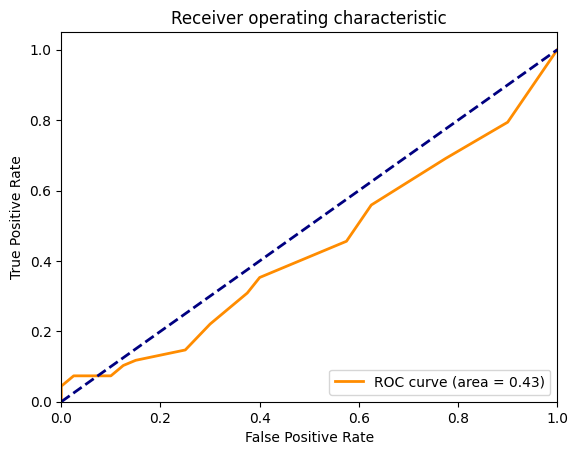

min bootstrapping aucroc:
0.25036075036075034
max bootstrapping aucroc:
0.6037157287157287
p_onesided = 0

Target_AUC = 0
p_twosided_1 = 0
p_twosided_2 = 1
p_twosided = 0
boots_mean_AUCROC =
0.4367562136012088(0.32610294117647054,0.542020202020202)

...END AUCROC
BEGIN LOADING KSADS...

...FINISH LOADING KSADS
BEGIN LOADING CBCL, anx/dep or with/dep...
...FINISH LOADING CBCL, anx/dep or with/dep...
BEGIN MERGING...
...FINISH MERGING
BEGIN PREPROCESSING...

Last check of missing data. Non-null rows = 0

Check that positives and negatives dont overlap
Index([], dtype='object', name='src_subject_id')
FINAL Number of positives in the data n=119
Number of negatives in the data (before subsampling) n=11667
Overall sample size (before subsampling) n=11786
FINAL Number of negatives in the data (after subsampling) n=1071
FINAL Overall sample size (before subsampling) n=1190
demo_sex_v2
1.0    612
2.0    577
Name: count, dtype: int64
Positive girls in sample = 43
Positive boys in sample = 76

..

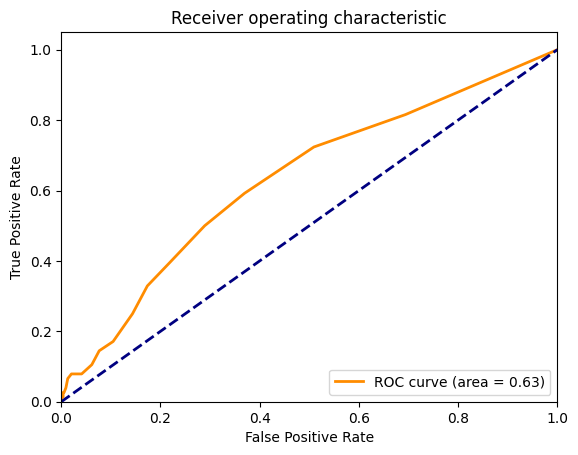

min bootstrapping aucroc:
0.5157361833778653
max bootstrapping aucroc:
0.7477106227106227
p_onesided = 0

Target_AUC = 0
p_twosided_1 = 0
p_twosided_2 = 1
p_twosided = 0
boots_mean_AUCROC =
0.6321800441371703(0.5622849372849372,0.6975650091240877)

...END AUCROC
BEGIN LOADING KSADS...

...FINISH LOADING KSADS
BEGIN LOADING CBCL, anx/dep or with/dep...
...FINISH LOADING CBCL, anx/dep or with/dep...
BEGIN MERGING...
...FINISH MERGING
BEGIN PREPROCESSING...

Last check of missing data. Non-null rows = 0

Check that positives and negatives dont overlap
Index([], dtype='object', name='src_subject_id')
FINAL Number of positives in the data n=119
Number of negatives in the data (before subsampling) n=78
Overall sample size (before subsampling) n=197
Not enough negative samples to use the desired neg/pos rate. Using all negative samples
FINAL Number of negatives in the data (after subsampling) n=78
FINAL Overall sample size (before subsampling) n=197
demo_sex_v2
1.0    116
2.0     81
Name: cou

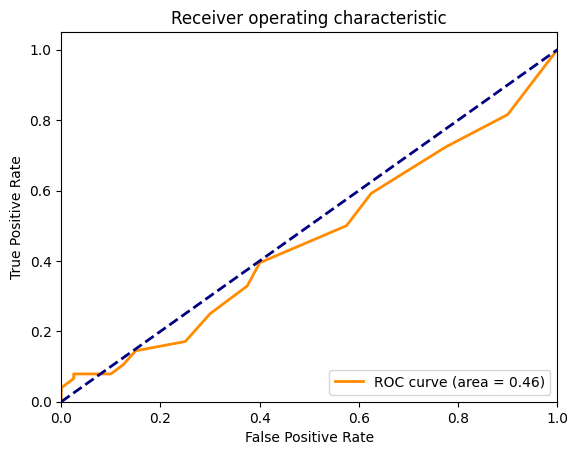

min bootstrapping aucroc:
0.30666035353535354
max bootstrapping aucroc:
0.6741776315789474
p_onesided = 0

Target_AUC = 0
p_twosided_1 = 0
p_twosided_2 = 1
p_twosided = 0
boots_mean_AUCROC =
0.4611083720480934(0.35642276422764224,0.5697674418604651)

...END AUCROC
BEGIN LOADING KSADS...

...FINISH LOADING KSADS
BEGIN LOADING CBCL, anx/dep or with/dep...
...FINISH LOADING CBCL, anx/dep or with/dep...
BEGIN MERGING...
...FINISH MERGING
BEGIN PREPROCESSING...

Last check of missing data. Non-null rows = 0

Check that positives and negatives dont overlap
Index([], dtype='object', name='src_subject_id')
FINAL Number of positives in the data n=105
Number of negatives in the data (before subsampling) n=78
Overall sample size (before subsampling) n=183
Not enough negative samples to use the desired neg/pos rate. Using all negative samples
FINAL Number of negatives in the data (after subsampling) n=78
FINAL Overall sample size (before subsampling) n=183
demo_sex_v2
1.0    108
2.0     75
Name: c

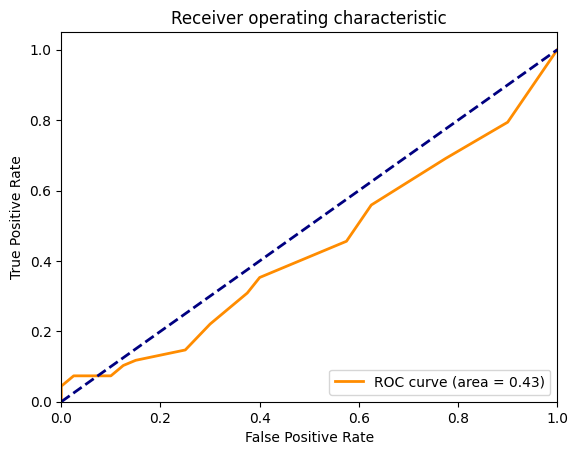

min bootstrapping aucroc:
0.26631393298059963
max bootstrapping aucroc:
0.6278142589118199
p_onesided = 0

Target_AUC = 0
p_twosided_1 = 0
p_twosided_2 = 1
p_twosided = 0
boots_mean_AUCROC =
0.43499090934149587(0.3203270159791899,0.5439338235294118)

...END AUCROC
BEGIN LOADING KSADS...

...FINISH LOADING KSADS
BEGIN LOADING CBCL, anx/dep or with/dep...
...FINISH LOADING CBCL, anx/dep or with/dep...
BEGIN MERGING...
...FINISH MERGING
BEGIN PREPROCESSING...

Last check of missing data. Non-null rows = 0

Check that positives and negatives dont overlap
Index([], dtype='object', name='src_subject_id')
FINAL Number of positives in the data n=119
Number of negatives in the data (before subsampling) n=11667
Overall sample size (before subsampling) n=11786
FINAL Number of negatives in the data (after subsampling) n=1071
FINAL Overall sample size (before subsampling) n=1190
demo_sex_v2
1.0    612
2.0    577
Name: count, dtype: int64
Positive girls in sample = 43
Positive boys in sample = 76

.

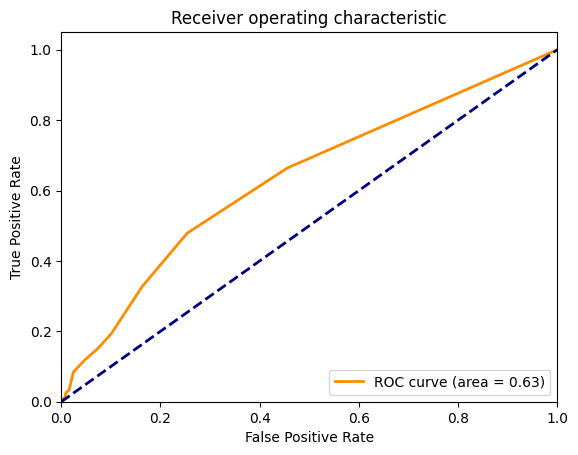

min bootstrapping aucroc:
0.5383594080978031
max bootstrapping aucroc:
0.7111292834890965
p_onesided = 0

Target_AUC = 0
p_twosided_1 = 0
p_twosided_2 = 1
p_twosided = 0
boots_mean_AUCROC =
0.6318971941307334(0.581892523364486,0.6812416823715401)

...END AUCROC
BEGIN LOADING KSADS...

...FINISH LOADING KSADS
BEGIN LOADING CBCL, anx/dep or with/dep...
...FINISH LOADING CBCL, anx/dep or with/dep...
BEGIN MERGING...
...FINISH MERGING
BEGIN PREPROCESSING...

Last check of missing data. Non-null rows = 0

Check that positives and negatives dont overlap
Index([], dtype='object', name='src_subject_id')
FINAL Number of positives in the data n=119
Number of negatives in the data (before subsampling) n=78
Overall sample size (before subsampling) n=197
Not enough negative samples to use the desired neg/pos rate. Using all negative samples
FINAL Number of negatives in the data (after subsampling) n=78
FINAL Overall sample size (before subsampling) n=197
demo_sex_v2
1.0    116
2.0     81
Name: coun

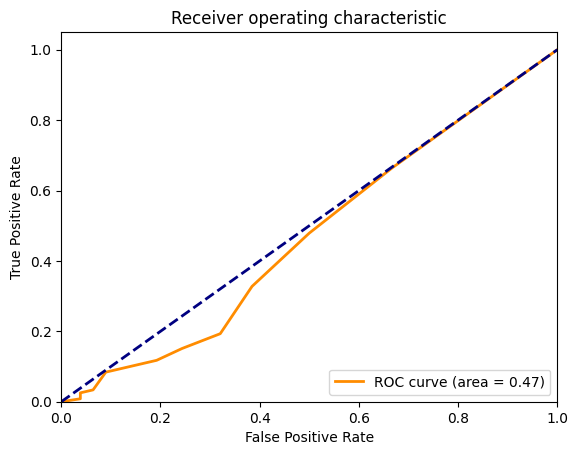

min bootstrapping aucroc:
0.33799160406539996
max bootstrapping aucroc:
0.5963141025641026
p_onesided = 0

Target_AUC = 0
p_twosided_1 = 0
p_twosided_2 = 1
p_twosided = 0
boots_mean_AUCROC =
0.46905145873382836(0.3837158469945355,0.5497552149851)

...END AUCROC
BEGIN LOADING KSADS...

...FINISH LOADING KSADS
BEGIN LOADING CBCL, anx/dep or with/dep...
...FINISH LOADING CBCL, anx/dep or with/dep...
BEGIN MERGING...
...FINISH MERGING
BEGIN PREPROCESSING...

Last check of missing data. Non-null rows = 0

Check that positives and negatives dont overlap
Index([], dtype='object', name='src_subject_id')
FINAL Number of positives in the data n=105
Number of negatives in the data (before subsampling) n=78
Overall sample size (before subsampling) n=183
Not enough negative samples to use the desired neg/pos rate. Using all negative samples
FINAL Number of negatives in the data (after subsampling) n=78
FINAL Overall sample size (before subsampling) n=183
demo_sex_v2
1.0    108
2.0     75
Name: coun

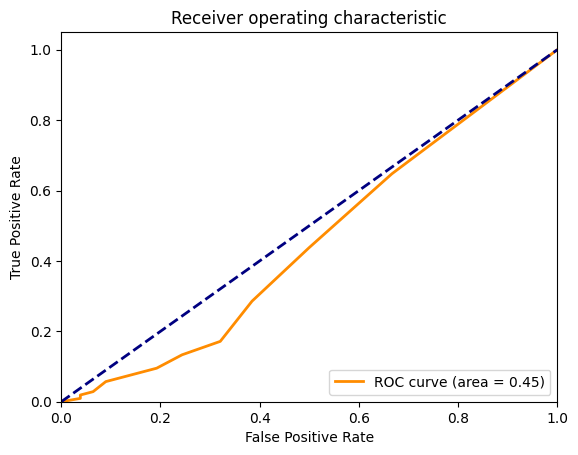

min bootstrapping aucroc:
0.30611002921129504
max bootstrapping aucroc:
0.580489417989418
p_onesided = 0

Target_AUC = 0
p_twosided_1 = 0
p_twosided_2 = 1
p_twosided = 0
boots_mean_AUCROC =
0.45056504944155196(0.36450809464508094,0.5329365079365079)

...END AUCROC
BEGIN LOADING KSADS...

...FINISH LOADING KSADS
BEGIN LOADING CBCL, anx/dep or with/dep...
...FINISH LOADING CBCL, anx/dep or with/dep...
BEGIN MERGING...
...FINISH MERGING
BEGIN PREPROCESSING...

Last check of missing data. Non-null rows = 0

Check that positives and negatives dont overlap
Index([], dtype='object', name='src_subject_id')
FINAL Number of positives in the data n=119
Number of negatives in the data (before subsampling) n=11667
Overall sample size (before subsampling) n=11786
FINAL Number of negatives in the data (after subsampling) n=1071
FINAL Overall sample size (before subsampling) n=1190
demo_sex_v2
1.0    612
2.0    577
Name: count, dtype: int64
Positive girls in sample = 43
Positive boys in sample = 76

.

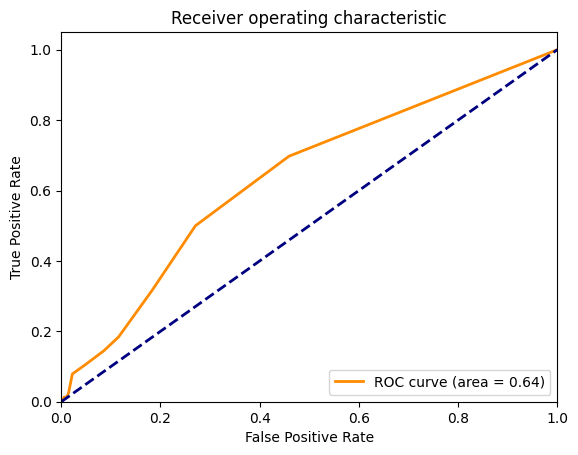

min bootstrapping aucroc:
0.5237407452360724
max bootstrapping aucroc:
0.7439311202422145
p_onesided = 0

Target_AUC = 0
p_twosided_1 = 0
p_twosided_2 = 1
p_twosided = 0
boots_mean_AUCROC =
0.6377617084958631(0.573595146871009,0.6983129020512198)

...END AUCROC
BEGIN LOADING KSADS...

...FINISH LOADING KSADS
BEGIN LOADING CBCL, anx/dep or with/dep...
...FINISH LOADING CBCL, anx/dep or with/dep...
BEGIN MERGING...
...FINISH MERGING
BEGIN PREPROCESSING...

Last check of missing data. Non-null rows = 0

Check that positives and negatives dont overlap
Index([], dtype='object', name='src_subject_id')
FINAL Number of positives in the data n=119
Number of negatives in the data (before subsampling) n=78
Overall sample size (before subsampling) n=197
Not enough negative samples to use the desired neg/pos rate. Using all negative samples
FINAL Number of negatives in the data (after subsampling) n=78
FINAL Overall sample size (before subsampling) n=197
demo_sex_v2
1.0    116
2.0     81
Name: coun

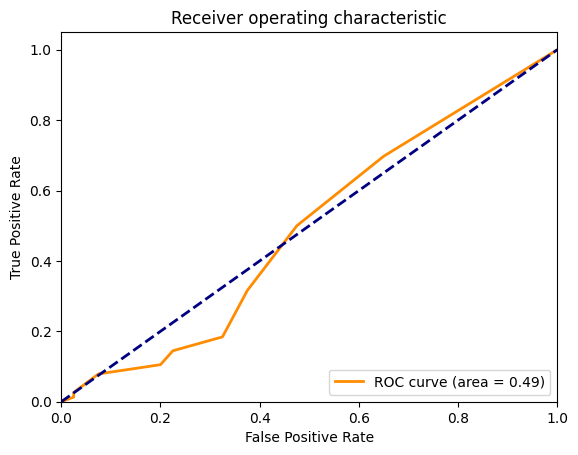

min bootstrapping aucroc:
0.2715277777777778
max bootstrapping aucroc:
0.6847389558232931
p_onesided = 0

Target_AUC = 0
p_twosided_1 = 0
p_twosided_2 = 1
p_twosided = 0
boots_mean_AUCROC =
0.49018273084701275(0.3770099213137188,0.6057661675692896)

...END AUCROC
BEGIN LOADING KSADS...

...FINISH LOADING KSADS
BEGIN LOADING CBCL, anx/dep or with/dep...
...FINISH LOADING CBCL, anx/dep or with/dep...
BEGIN MERGING...
...FINISH MERGING
BEGIN PREPROCESSING...

Last check of missing data. Non-null rows = 0

Check that positives and negatives dont overlap
Index([], dtype='object', name='src_subject_id')
FINAL Number of positives in the data n=105
Number of negatives in the data (before subsampling) n=78
Overall sample size (before subsampling) n=183
Not enough negative samples to use the desired neg/pos rate. Using all negative samples
FINAL Number of negatives in the data (after subsampling) n=78
FINAL Overall sample size (before subsampling) n=183
demo_sex_v2
1.0    108
2.0     75
Name: co

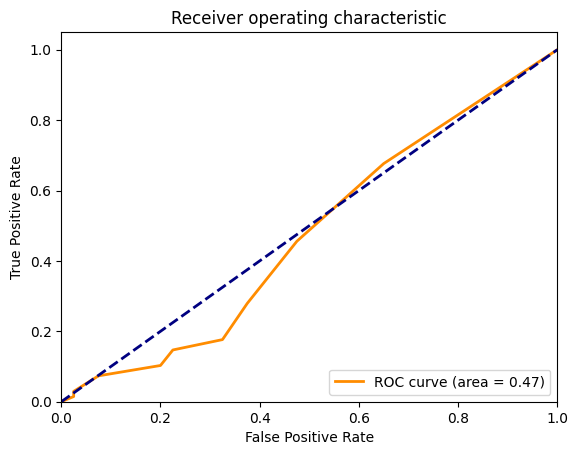

min bootstrapping aucroc:
0.28304848273456573
max bootstrapping aucroc:
0.6569548872180451
p_onesided = 0

Target_AUC = 0
p_twosided_1 = 0
p_twosided_2 = 1
p_twosided = 0
boots_mean_AUCROC =
0.4724966242530199(0.36826758147512867,0.5796875)

...END AUCROC
BEGIN LOADING KSADS...

...FINISH LOADING KSADS
BEGIN LOADING CBCL, anx/dep or with/dep...
...FINISH LOADING CBCL, anx/dep or with/dep...
BEGIN MERGING...
...FINISH MERGING
BEGIN PREPROCESSING...

Last check of missing data. Non-null rows = 0

Check that positives and negatives dont overlap
Index([], dtype='object', name='src_subject_id')
FINAL Number of positives in the data n=119
Number of negatives in the data (before subsampling) n=11667
Overall sample size (before subsampling) n=11786
FINAL Number of negatives in the data (after subsampling) n=1071
FINAL Overall sample size (before subsampling) n=1190
demo_sex_v2
1.0    612
2.0    577
Name: count, dtype: int64
Positive girls in sample = 43
Positive boys in sample = 76

...END PRE

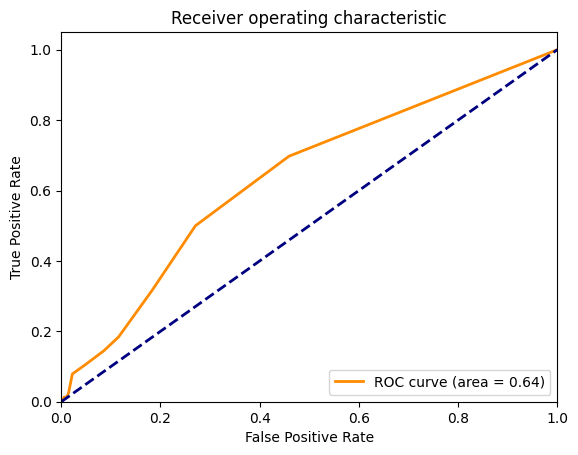

min bootstrapping aucroc:
0.530893536121673
max bootstrapping aucroc:
0.7376286008230453
p_onesided = 0

Target_AUC = 0
p_twosided_1 = 0
p_twosided_2 = 1
p_twosided = 0
boots_mean_AUCROC =
0.6377689754396416(0.5740381114212889,0.7013588867678087)

...END AUCROC
BEGIN LOADING KSADS...

...FINISH LOADING KSADS
BEGIN LOADING CBCL, anx/dep or with/dep...
...FINISH LOADING CBCL, anx/dep or with/dep...
BEGIN MERGING...
...FINISH MERGING
BEGIN PREPROCESSING...

Last check of missing data. Non-null rows = 0

Check that positives and negatives dont overlap
Index([], dtype='object', name='src_subject_id')
FINAL Number of positives in the data n=119
Number of negatives in the data (before subsampling) n=78
Overall sample size (before subsampling) n=197
Not enough negative samples to use the desired neg/pos rate. Using all negative samples
FINAL Number of negatives in the data (after subsampling) n=78
FINAL Overall sample size (before subsampling) n=197
demo_sex_v2
1.0    116
2.0     81
Name: coun

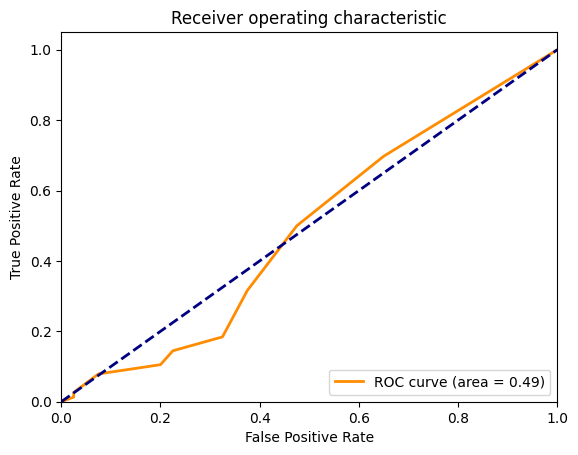

min bootstrapping aucroc:
0.27132750728256344
max bootstrapping aucroc:
0.6501695960530374
p_onesided = 0

Target_AUC = 0
p_twosided_1 = 0
p_twosided_2 = 1
p_twosided = 0
boots_mean_AUCROC =
0.489538110140885(0.3733333333333333,0.6022311022311022)

...END AUCROC
BEGIN LOADING KSADS...

...FINISH LOADING KSADS
BEGIN LOADING CBCL, anx/dep or with/dep...
...FINISH LOADING CBCL, anx/dep or with/dep...
BEGIN MERGING...
...FINISH MERGING
BEGIN PREPROCESSING...

Last check of missing data. Non-null rows = 0

Check that positives and negatives dont overlap
Index([], dtype='object', name='src_subject_id')
FINAL Number of positives in the data n=105
Number of negatives in the data (before subsampling) n=78
Overall sample size (before subsampling) n=183
Not enough negative samples to use the desired neg/pos rate. Using all negative samples
FINAL Number of negatives in the data (after subsampling) n=78
FINAL Overall sample size (before subsampling) n=183
demo_sex_v2
1.0    108
2.0     75
Name: cou

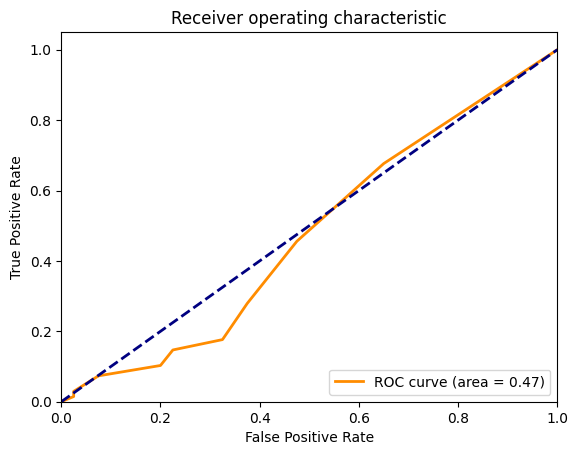

min bootstrapping aucroc:
0.25827205882352944
max bootstrapping aucroc:
0.7018796992481203
p_onesided = 0

Target_AUC = 0
p_twosided_1 = 0
p_twosided_2 = 0
p_twosided = 0
boots_mean_AUCROC =
0.47342681010758986(0.36208112874779536,0.5881578947368421)

...END AUCROC

 FINISH ANXDEP/WITHDEP


FINISH ALL


FINISH DICT



In [39]:
# ! check the threshold hypothesis number

# use this code to create a csv with output
dict_to_save = {'Dataset':[],
                'Wave':[],
                'Scale':[],
                'Measure':[],
                'gs-Reporter':[],
                'Sex':[],
                'Hypothesis':[],
                'b-AUCROC':[],
                'q_25':[],
                'q_75':[],
                'p1sided': [],
                'p2sided': []}

fordict_datasets = []
fordict_waves = []
fordict_scales = []
fordict_measures = []
fordict_reporters = []
fordict_sexes = []
fordict_hypotheses = []
fordict_aucrocs = []
fordict_q25 = []
fordict_q75 = []
fordict_p1 = []
fordict_p2 = []

Dataset = 'ABCD'

Measure = 'cbclaff'

for Sex in ['girls', 'boys', 'both']:
    for Input_data in ['ysr', 'cbcl']: #cbcl
        for Reporter in ['parent', 'child']: # child
            for Hypothesis in ['1','2a','2b']:
                if Input_data == 'cbcl':
                    for Wave in ['baseline', 'optimal']:
                        print('\nInput Data: %s' % Input_data)
                        print('Wave: %s' % Wave)
                        print('Ksads Reporter: %s' % Reporter)
                        print('Hypothesis: %s' % Hypothesis)
                        print('Sex: %s' % Sex)
                        print('\n')
                        data_ksads = load_ksads(path_to_data, reporter = Reporter, wave = Wave, do_print = False)
                        data_input = load_cbcl(path_to_data, wave = Wave)
                        data_merged = merge_my_data(data_input, data_ksads)     
                        data_ready = preprocess_data(data_merged, percent_positives = 10, hypothesis = Hypothesis, sex = Sex)
                        print('\nFINISHED DATA PREP\n')
                        # STARTING ANALYSIS
                        print('\nSTART ANALYSIS\n')
                        print('\nInput Data: %s' % Input_data)
                        print('Wave: %s' % Wave)
                        print('Ksads Reporter: %s' % Reporter)
                        print('Hypothesis: %s' % Hypothesis) 
                        print('Sex: %s' % Sex)
                        if Hypothesis in ['1', '2a']:
                            Target_auc = 0.8 # [TODO] NEED TO DOUBLE CHECK THIS WITH SAMPLE SIZE ESTIMATION ETC
                        elif Hypothesis == '2b':
                            Target_auc = 0.7 # [TODO] NEED TO DOUBLE CHECK THIS WITH SAMPLE SIZE ESTIMATION ETC
                        fig_file_name = 'ABCD_'+Input_data+'_'+Hypothesis+'_'+Reporter+'_'+Wave+'_'+Sex
                        try:
                            y_true,y_measure, b_AUCROC, q25, q75, p1, p2 = run_aucroc_and_plot(data_ready, 
                                                                path_to_save_plots='../plotting/plot_data/', 
                                                                name_to_save=fig_file_name, 
                                                                mymeasure = Input_data, 
                                                                hypothesis = Hypothesis,
                                                                nboots=100, 
                                                                target_auc=Target_auc)
                            fordict_datasets.append(Dataset)
                            fordict_waves.append(Wave)
                            fordict_scales.append(Input_data)
                            fordict_measures.append(Measure)
                            fordict_reporters.append(Reporter)
                            fordict_sexes.append(Sex)
                            fordict_hypotheses.append(Hypothesis)
                            fordict_aucrocs.append(b_AUCROC)
                            fordict_q25.append(q25)
                            fordict_q75.append(q75)
                            fordict_p1.append(p1)
                            fordict_p2.append(p2)
                        except:
                            fordict_datasets.append(Dataset)
                            fordict_waves.append(Wave)
                            fordict_scales.append(Input_data)
                            fordict_measures.append(Measure)
                            fordict_reporters.append(Reporter)
                            fordict_sexes.append(Sex)
                            fordict_hypotheses.append(Hypothesis)
                            fordict_aucrocs.append('ERROR')
                            fordict_q25.append('ERROR')
                            fordict_q75.append('ERROR')
                            fordict_p1.append(p1)
                            fordict_p2.append(p2)
                            pass
                        print('\nFINISH\n')
    
                elif Input_data == 'ysr':
                    Wave = 'optimal'
                    print('\nInput Data: %s' % Input_data)
                    print('Wave: Always optimal')
                    print('Ksads Reporter: %s' % Reporter)
                    print('Hypothesis: %s' % Hypothesis)
                    print('Sex: %s' % Sex)
                    print('\n')
                    data_ksads = load_ksads(path_to_data, reporter = Reporter, wave = Wave, do_print = False)
                    data_input = load_ysr(path_to_data, wave = Wave)
                    data_merged = merge_my_data(data_input, data_ksads)     
                    data_ready = preprocess_data(data_merged, percent_positives = 10, hypothesis = Hypothesis, sex = Sex)
                    print('\nFINISHED DATA PREP\n')
                    # STARTING ANALYSIS
                    print('\nSTART ANALYSIS\n')
                    print('\nInput Data: %s' % Input_data)
                    print('Wave: %s' % Wave)
                    print('Ksads Reporter: %s' % Reporter)
                    print('Hypothesis: %s' % Hypothesis)
                    print('Sex: %s' % Sex)
                    if Hypothesis in ['1', '2a']:
                        Target_auc = 0.8 # [TODO] NEED TO DOUBLE CHECK THIS WITH SAMPLE SIZE ESTIMATION ETC
                    elif Hypothesis == '2b':
                        Target_auc = 0.7 # [TODO] NEED TO DOUBLE CHECK THIS WITH SAMPLE SIZE ESTIMATION ETC
                    fig_file_name = 'ABCD_'+Input_data+'_'+Hypothesis+'_'+Reporter+'_'+Wave+'_'+Sex
                    try:
                        y_true,y_measure, b_AUCROC, q25, q75, p1, p2  = run_aucroc_and_plot(data_ready, 
                                                                path_to_save_plots='../plotting/plot_data/', 
                                                                name_to_save=fig_file_name, 
                                                                mymeasure = Input_data, 
                                                                hypothesis = Hypothesis,
                                                                nboots=100, 
                                                                target_auc=Target_auc)
                        fordict_datasets.append(Dataset)
                        fordict_waves.append(Wave)
                        fordict_scales.append(Input_data)
                        fordict_measures.append(Measure)
                        fordict_reporters.append(Reporter)
                        fordict_sexes.append(Sex)
                        fordict_hypotheses.append(Hypothesis)
                        fordict_aucrocs.append(b_AUCROC)
                        fordict_q25.append(q25)
                        fordict_q75.append(q75)
                        fordict_p1.append(p1)
                        fordict_p2.append(p2)
                    except:
                        fordict_datasets.append(Dataset)
                        fordict_waves.append(Wave)
                        fordict_scales.append(Input_data)
                        fordict_measures.append(Measure)
                        fordict_reporters.append(Reporter)
                        fordict_sexes.append(Sex)
                        fordict_hypotheses.append(Hypothesis)
                        fordict_aucrocs.append('ERROR')
                        fordict_q25.append('ERROR')
                        fordict_q75.append('ERROR')
                        fordict_p1.append(p1)
                        fordict_p2.append(p2)
                        pass
                    print('\nFINISH\n')
                else: 
                    print('\nWRONG INPUT DATA')

print('\n FINISH CBCL-AFF\n')

# only cbcl, not ysr

Input_data = 'cbcl'
Wave = ['baseline']
Reporter = ['parent', 'child']
Scale = ['anxiousdep', 'withdrawndep']
Sex = ['both', 'boys', 'girls']
Hypothesis = ['1', '2a', '2b']

for wave in Wave:
    for reporter in Reporter:
        for scale in Scale:
            for sex in Sex:
                for hypothesis in Hypothesis:
                    data_ksads = load_ksads(path_to_data, reporter = reporter, wave = wave, do_print = False)
                    data_input = load_cbcl_anxdep_withdep(path_to_data, wave = wave, scale = scale, do_print = False)
                    data_merged = merge_my_data(data_input, data_ksads)     
                    data_ready = preprocess_data(data_merged, percent_positives = 10, hypothesis = hypothesis, sex = sex)
                    # STARTING ANALYSIS
                    print('\nSTART ANALYSIS\n')
                    print('\nInput Data: CBCL anx/dex or with/dep')
                    print('Scale: %s' % scale)
                    print('Wave: %s' % wave)
                    print('Ksads Reporter: %s' % reporter)
                    print('Hypothesis: %s' % hypothesis) 
                    print('Sex: %s' % sex)
                    if hypothesis in ['1', '2a']:
                        Target_auc = 0.77 # [TODO] NEED TO DOUBLE CHECK THIS WITH SAMPLE SIZE ESTIMATION ETC
                    elif hypothesis == '2b':
                        Target_auc = 0.7 # [TODO] NEED TO DOUBLE CHECK THIS WITH SAMPLE SIZE ESTIMATION ETC
                    fig_file_name = 'ABCD_'+Input_data+scale+'_'+hypothesis+'_'+reporter+'_'+wave+'_'+sex
                    try:
                        y_true,y_measure, b_AUCROC, q25, q75, p1, p2 = run_aucroc_and_plot(data_ready, 
                                                            path_to_save_plots='../plotting/plot_data/', 
                                                            name_to_save=fig_file_name, 
                                                            mymeasure = Input_data, 
                                                            hypothesis = hypothesis,
                                                            nboots=100, 
                                                            target_auc=Target_auc,
                                                            do_print = False)
                        fordict_datasets.append(Dataset)
                        fordict_waves.append(wave)
                        fordict_scales.append(Input_data)
                        fordict_measures.append(scale)
                        fordict_reporters.append(reporter)
                        fordict_sexes.append(sex)
                        fordict_hypotheses.append(hypothesis)
                        fordict_aucrocs.append(b_AUCROC)
                        fordict_q25.append(q25)
                        fordict_q75.append(q75)
                        fordict_p1.append(p1)
                        fordict_p2.append(p2)
                    except:
                        fordict_datasets.append(Dataset)
                        fordict_waves.append(wave)
                        fordict_scales.append(Input_data)
                        fordict_measures.append(scale)
                        fordict_reporters.append(reporter)
                        fordict_hypotheses.append(hypothesis)
                        fordict_sexes.append(sex)
                        fordict_aucrocs.append('ERROR')
                        fordict_q25.append('ERROR')
                        fordict_q75.append('ERROR')
                        fordict_p1.append(p1)
                        fordict_p2.append(p2)
                        pass
                        
print('\n FINISH ANXDEP/WITHDEP\n')

print('\nFINISH ALL\n')

dict_to_save = {'Dataset':fordict_datasets,
                'Wave':fordict_waves,
                'Scale':fordict_scales,
                'Measure':fordict_measures,
                'gs-Reporter':fordict_reporters,
                'Sex':fordict_sexes,                
                'Hypothesis':fordict_hypotheses,
                'b-AUCROC':fordict_aucrocs,
                'q_25':fordict_q25,
                'q_75':fordict_q75,
                'p1sided':fordict_p1,
                'p2sided':fordict_p2}

print('\nFINISH DICT\n')


In [40]:
dict_to_save

{'Dataset': ['ABCD',
  'ABCD',
  'ABCD',
  'ABCD',
  'ABCD',
  'ABCD',
  'ABCD',
  'ABCD',
  'ABCD',
  'ABCD',
  'ABCD',
  'ABCD',
  'ABCD',
  'ABCD',
  'ABCD',
  'ABCD',
  'ABCD',
  'ABCD',
  'ABCD',
  'ABCD',
  'ABCD',
  'ABCD',
  'ABCD',
  'ABCD',
  'ABCD',
  'ABCD',
  'ABCD',
  'ABCD',
  'ABCD',
  'ABCD',
  'ABCD',
  'ABCD',
  'ABCD',
  'ABCD',
  'ABCD',
  'ABCD',
  'ABCD',
  'ABCD',
  'ABCD',
  'ABCD',
  'ABCD',
  'ABCD',
  'ABCD',
  'ABCD',
  'ABCD',
  'ABCD',
  'ABCD',
  'ABCD',
  'ABCD',
  'ABCD',
  'ABCD',
  'ABCD',
  'ABCD',
  'ABCD',
  'ABCD',
  'ABCD',
  'ABCD',
  'ABCD',
  'ABCD',
  'ABCD',
  'ABCD',
  'ABCD',
  'ABCD',
  'ABCD',
  'ABCD',
  'ABCD',
  'ABCD',
  'ABCD',
  'ABCD',
  'ABCD',
  'ABCD',
  'ABCD',
  'ABCD',
  'ABCD',
  'ABCD',
  'ABCD',
  'ABCD',
  'ABCD',
  'ABCD',
  'ABCD',
  'ABCD',
  'ABCD',
  'ABCD',
  'ABCD',
  'ABCD',
  'ABCD',
  'ABCD',
  'ABCD',
  'ABCD',
  'ABCD'],
 'Wave': ['optimal',
  'optimal',
  'optimal',
  'optimal',
  'optimal',
  'optimal',
  

In [41]:
df_to_save = pd.DataFrame.from_dict(dict_to_save)
df_to_save.head()

Dataset     Wave Scale  Measure gs-Reporter    Sex Hypothesis  b-AUCROC  \
0    ABCD  optimal   ysr  cbclaff      parent  girls          1  0.699438   
1    ABCD  optimal   ysr  cbclaff      parent  girls         2a  0.645138   
2    ABCD  optimal   ysr  cbclaff      parent  girls         2b  0.625739   
3    ABCD  optimal   ysr  cbclaff       child  girls          1  0.958849   
4    ABCD  optimal   ysr  cbclaff       child  girls         2a  0.636256   

                  q_25                q_75   p1sided   p2sided  
0   0.6026349206349206  0.7827880512091039  0.012987  0.025974  
1   0.5487315145334013  0.7357205144974929  0.000000  0.000000  
2   0.4607583774250441  0.7729559748427672  0.171828  0.341658  
3   0.9321811992668239  0.9799031159989525  1.000000  0.000000  
4  0.46645021645021645   0.787878787878788  0.015984  0.029970

In [43]:
df_to_save.to_csv('/Users/zeleninam2/Documents/projects/cbcl_ksads_work/revision_2023/results/ABCDresults_newnew.csv', sep=',', index=False, encoding='utf-8')

# Correlations

## Correlations between cbcl-aff, anxdep, withdep on baseline wave

In [44]:
bsl_cbclaff = load_cbcl(path_to_data, 'baseline', do_print = False)
bsl_cbclaff = bsl_cbclaff.rename(columns={"input_measure": "cbclaff"}, errors="raise")
bsl_cbclaff.shape

BEGIN LOADING CBCL...
...FINISH LOADING CBCL


(11860, 1)

In [45]:
bsl_anxdep = load_cbcl_anxdep_withdep(path_to_data, 'baseline', 'anxiousdep', do_print = False)
bsl_anxdep = bsl_anxdep.rename(columns={"input_measure": "anxdep"}, errors="raise")
bsl_anxdep.shape

BEGIN LOADING CBCL, anx/dep or with/dep...
...FINISH LOADING CBCL, anx/dep or with/dep...


(11861, 14)

In [46]:
bsl_withdep = load_cbcl_anxdep_withdep(path_to_data, 'baseline', 'withdrawndep', do_print = False)
bsl_withdep = bsl_withdep.rename(columns={"input_measure": "withdep"}, errors="raise")
bsl_withdep.shape

BEGIN LOADING CBCL, anx/dep or with/dep...
...FINISH LOADING CBCL, anx/dep or with/dep...


(11861, 10)

In [47]:
bsl_anxdepwithdep = pd.merge(bsl_anxdep, bsl_withdep, how='left', left_index = True, right_index = True, indicator=True)

In [48]:
bsl_anxdepwithdep._merge.value_counts()

_merge
both          11861
left_only         0
right_only        0
Name: count, dtype: int64

In [49]:
bsl_anxdepwithdep = pd.merge(bsl_anxdep, bsl_withdep, how='left', left_index = True, right_index = True, indicator=False)

In [50]:
bsl_anxdepwithdep.head()

cbcl_q12_p  cbcl_q14_p  cbcl_q41_p  cbcl_q32_p  cbcl_q33_p  \
src_subject_id                                                                 
NDAR_INV003RTV85           0         0.0         0.0         0.0         0.0   
NDAR_INV005V6D2C           0         0.0         0.0         1.0         0.0   
NDAR_INV007W6H7B           0         0.0         1.0         0.0         0.0   
NDAR_INV00BD7VDC           0         0.0         0.0         1.0         1.0   
NDAR_INV00CY2MDM           0         0.0         1.0         0.0         1.0   

                  cbcl_q35_p  cbcl_q45_p  cbcl_q50_p  cbcl_q52_p  cbcl_q71_p  \
src_subject_id                                                                 
NDAR_INV003RTV85         0.0         0.0         0.0         0.0         0.0   
NDAR_INV005V6D2C         0.0         0.0         0.0         0.0         0.0   
NDAR_INV007W6H7B         0.0         0.0         1.0         0.0         0.0   
NDAR_INV00BD7VDC         0.0         0.0         0.0         1.0         1.0   
NDAR_INV00CY2MDM         0.0         1.0         0.0         0.0         1.0   

                  ...  cbcl_q42_p  cbcl_q65_p  cbcl_q69_p  cbcl_q75_p  \
src_subject_id    ...                                                   
NDAR_INV003RTV85  ...         1.0         0.0         0.0         0.0   
NDAR_INV005V6D2C  ...         0.0         0.0         0.0         0.0   
NDAR_INV007W6H7B  ...         1.0         0.0         0.0         0.0   
NDAR_INV00BD7VDC  ...         0.0         0.0         0.0         0.0   
NDAR_INV00CY2MDM  ...         0.0         0.0         1.0         0.0   

                  cbcl_q102_p  cbcl_q103_p_y  cbcl_q111_p  cbcl_q80_p  \
src_subject_id                                                          
NDAR_INV003RTV85          0.0            0.0          0.0         0.0   
NDAR_INV005V6D2C          0.0            0.0          0.0         0.0   
NDAR_INV007W6H7B          0.0            0.0          0.0         1.0   
NDAR_INV00BD7VDC          0.0            0.0          0.0         0.0   
NDAR_INV00CY2MDM          0.0            1.0          0.0         1.0   

                  cbcl_q88_p  withdep  
src_subject_id                         
NDAR_INV003RTV85         0.0      1.0  
NDAR_INV005V6D2C         0.0      0.0  
NDAR_INV007W6H7B         0.0      2.0  
NDAR_INV00BD7VDC         0.0      0.0  
NDAR_INV00CY2MDM         1.0      4.0  

[5 rows x 24 columns]

In [51]:
bsl_all = pd.merge(bsl_cbclaff, bsl_anxdepwithdep, how='left', left_index = True, right_index = True, indicator=True)

In [52]:
bsl_all._merge.value_counts()

_merge
both          11860
left_only         0
right_only        0
Name: count, dtype: int64

In [53]:
all_measures_bsl = bsl_all[['cbclaff','anxdep','withdep']]

In [54]:
all_measures_bsl.head()

cbclaff  anxdep  withdep
src_subject_id                            
NDAR_INV003RTV85      0.0     0.0      1.0
NDAR_INV005V6D2C      0.0     1.0      0.0
NDAR_INV007W6H7B      0.0     3.0      2.0
NDAR_INV00BD7VDC      1.0     5.0      0.0
NDAR_INV00CY2MDM      1.0     5.0      4.0

In [55]:
corr_result = all_measures_bsl.corr()
corr_result

cbclaff    anxdep   withdep
cbclaff  1.000000  0.768061  0.695811
anxdep   0.768061  1.000000  0.664177
withdep  0.695811  0.664177  1.000000

In [58]:
scipy.stats.pearsonr(all_measures_bsl['cbclaff'], all_measures_bsl['anxdep'])

PearsonRResult(statistic=0.7680608479490645, pvalue=0.0)

In [59]:
scipy.stats.pearsonr(all_measures_bsl['cbclaff'], all_measures_bsl['withdep'])

PearsonRResult(statistic=0.6958109386551781, pvalue=0.0)

In [60]:
scipy.stats.pearsonr(all_measures_bsl['anxdep'], all_measures_bsl['withdep'])

PearsonRResult(statistic=0.6641769883318512, pvalue=0.0)

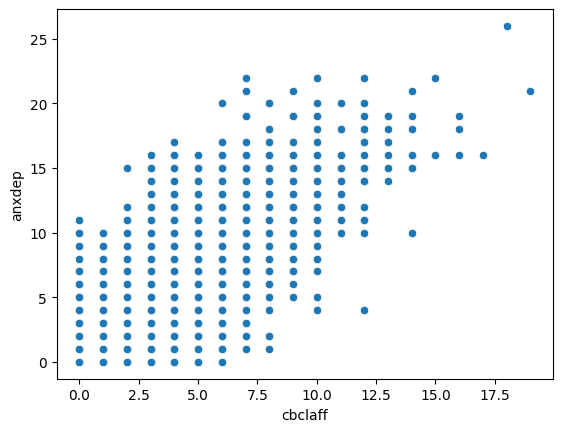

In [44]:
sns.scatterplot(x="cbclaff", y="anxdep", data=all_measures_bsl);

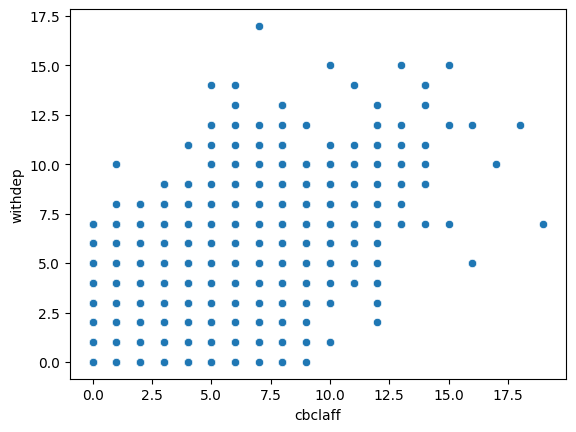

In [45]:
sns.scatterplot(x="cbclaff", y="withdep", data=all_measures_bsl);

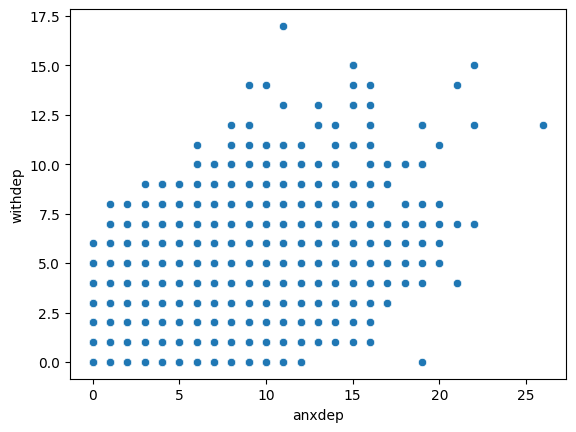

In [47]:
sns.scatterplot(x="anxdep", y="withdep", data=all_measures_bsl);

# Agreement rates

In how many cases parents and children agree/disagree on whether the child is depressed

In [38]:
ksads_p = load_ksads(path_to_data, 'parent', 'baseline', do_print = False)
ksads_c = load_ksads(path_to_data, 'child', 'baseline', do_print = False)

BEGIN LOADING KSADS...

...FINISH LOADING KSADS
BEGIN LOADING KSADS...

...FINISH LOADING KSADS


In [39]:
ksads_p.head()

ksads_DEPRESSION  ksads_ANXIETY  ksads_ADHD  \
src_subject_id                                                  
NDAR_INV007W6H7B                 0              1           0   
NDAR_INV00CY2MDM                 0              0           0   
NDAR_INV00HEV6HB                 0              0           0   
NDAR_INV00LJVZK2                 0              0           1   
NDAR_INV00NPMHND                 0              1           0   

                  ksads_ADHD_OR_ANXIETY  ksads_DEPyes_ANXADHDno  \
src_subject_id                                                    
NDAR_INV007W6H7B                      1                       0   
NDAR_INV00CY2MDM                      0                       0   
NDAR_INV00HEV6HB                      0                       0   
NDAR_INV00LJVZK2                      1                       0   
NDAR_INV00NPMHND                      1                       0   

                  ksads_DEPno_ANXADHDyes  
src_subject_id                            
NDAR_INV007W6H7B                       1  
NDAR_INV00CY2MDM                       0  
NDAR_INV00HEV6HB                       0  
NDAR_INV00LJVZK2                       1  
NDAR_INV00NPMHND                       1

In [40]:
ksads_p['ksads_DEPyes_ANXADHDno'].value_counts()

ksads_DEPyes_ANXADHDno
0    6175
1      11
Name: count, dtype: int64

In [41]:
ksads_c['ksads_DEPyes_ANXADHDno'].value_counts()

ksads_DEPyes_ANXADHDno
0    11687
1      105
Name: count, dtype: int64

In [42]:
ksads_c['ksads_DEPno_ANXADHDyes'].value_counts()

ksads_DEPno_ANXADHDyes
0    11714
1       78
Name: count, dtype: int64

In [43]:
ksads_p = ksads_p.rename(columns={"ksads_DEPRESSION": "ksads_DEPRESSION_p"}, errors="raise")
ksads_c = ksads_c.rename(columns={"ksads_DEPRESSION": "ksads_DEPRESSION_c"}, errors="raise")

In [44]:
ksads_p = ksads_p[["ksads_DEPRESSION_p"]]
ksads_c = ksads_c[["ksads_DEPRESSION_c"]]

In [45]:
ksads_c.shape

(11792, 1)

In [46]:
ksads_both = pd.merge(ksads_p, ksads_c, how='left', left_index = True, right_index = True, indicator=True)

In [47]:
ksads_both.shape

(6186, 3)

In [48]:
ksads_both.head()

ksads_DEPRESSION_p  ksads_DEPRESSION_c _merge
src_subject_id                                                 
NDAR_INV007W6H7B                   0                 0.0   both
NDAR_INV00CY2MDM                   0                 0.0   both
NDAR_INV00HEV6HB                   0                 0.0   both
NDAR_INV00LJVZK2                   0                 0.0   both
NDAR_INV00NPMHND                   0                 0.0   both

In [49]:
ksads_both['ksads_DEPRESSION_p'].compare(ksads_both['ksads_DEPRESSION_c'], result_names=("parent", "child"))

parent  child
src_subject_id                 
NDAR_INV0889M0JE     0.0    1.0
NDAR_INV09C3ZNFZ     0.0    1.0
NDAR_INV0G42TBW1     0.0    1.0
NDAR_INV0MCARYLD     0.0    1.0
NDAR_INV1415W413     0.0    1.0
...                  ...    ...
NDAR_INVYCRTDT3X     0.0    1.0
NDAR_INVYKVPYY2M     0.0    1.0
NDAR_INVYV7R5H1E     0.0    1.0
NDAR_INVZJ8TBWKJ     0.0    NaN
NDAR_INVZJFZNNPJ     0.0    NaN

[122 rows x 2 columns]

In [50]:
ksads_both['both_yes'] = np.where((ksads_both['ksads_DEPRESSION_p'] == 1) & (ksads_both['ksads_DEPRESSION_c'] == 1), 'both_yes', 'no')

In [51]:
ksads_both['both_yes'].value_counts()

both_yes
no          6182
both_yes       4
Name: count, dtype: int64

In [52]:
ksads_both['p_yes_c_no'] = np.where((ksads_both['ksads_DEPRESSION_p'] == 1) & (ksads_both['ksads_DEPRESSION_c'] == 0), 'p_yes_c_no', 'no')
ksads_both['p_no_c_yes'] = np.where((ksads_both['ksads_DEPRESSION_p'] == 0) & (ksads_both['ksads_DEPRESSION_c'] == 1), 'p_no_c_yes', 'no')
ksads_both['both_no'] = np.where((ksads_both['ksads_DEPRESSION_p'] == 0) & (ksads_both['ksads_DEPRESSION_c'] == 0), 'both_no', 'no')

In [53]:
ksads_both['p_yes_c_no'].value_counts()

p_yes_c_no
no            6161
p_yes_c_no      25
Name: count, dtype: int64

In [54]:
ksads_both['p_no_c_yes'].value_counts()

p_no_c_yes
no            6116
p_no_c_yes      70
Name: count, dtype: int64

In [55]:
ksads_both['both_no'].value_counts()

both_no
both_no    6060
no          126
Name: count, dtype: int64

In [28]:
ksads_p["ksads_DEPRESSION_p"].value_counts()

ksads_DEPRESSION_p
0    6156
1      30
Name: count, dtype: int64

In [30]:
ksads_c["ksads_DEPRESSION_c"].value_counts()

ksads_DEPRESSION_c
0    11673
1      119
Name: count, dtype: int64

# missing data check

In [15]:
wave = 'baseline'
reporter = 'parent'
path_to_mydata = path_to_data
do_print=False

In [16]:
if reporter == 'child':
    path_to_ksads_data = path_to_mydata+'/abcd-data-release-5.1/core/mental-health/mh_y_ksads_ss.csv'
elif reporter == 'parent':
    path_to_ksads_data = path_to_mydata+'/abcd-data-release-5.1/core/mental-health/mh_p_ksads_ss.csv'        
ksads_data = pd.read_csv(path_to_ksads_data, sep=',', header=0, low_memory=False)
    # Select only baseline rows
ksads_data_bsl = ksads_data.loc[ksads_data.eventname == 'baseline_year_1_arm_1'].copy()
# check dimensions of the dataset
if do_print:
    print('\nshape at loading, baseline only')
    print(ksads_data_bsl.shape)
# ksads - only leave columns with name id and depression diagnoses
if reporter == 'child':
    depression_column_list = [f'ksads_1_{x}_t' for x in [840, 841, 843, 844, 846]]
    adhd_column_list = ['ksads_14_856_t', 'ksads_14_855_t', 'ksads_14_853_t']
    anxiety_column_list = [ 'ksads_5_906_t',  'ksads_5_857_t', 'ksads_6_908_t',  'ksads_7_861_t',  'ksads_7_909_t',  'ksads_8_863_t',  'ksads_8_911_t', 'ksads_10_913_t', 'ksads_10_869_t', 'ksads_9_867_t']
elif reporter == 'parent':
    depression_column_list = [f'ksads_1_{x}_p' for x in [840, 841, 843, 844, 846]]
    adhd_column_list = ['ksads_14_856_p', 'ksads_14_855_p', 'ksads_14_853_p']
    anxiety_column_list = [ 'ksads_5_906_p',  'ksads_5_857_p', 'ksads_6_908_p',  'ksads_7_861_p',  'ksads_7_909_p',  'ksads_8_863_p',  'ksads_8_911_p', 'ksads_10_913_p', 'ksads_10_869_p', 'ksads_9_867_p'] 

In [17]:
ksads_data_bsl.ksads_6_908_p.value_counts()

ksads_6_908_p
0.0      6274
888.0    5449
Name: count, dtype: int64

In [18]:
ksads_data_bsl['any_depression'] = (ksads_data_bsl.loc[:, depression_column_list] > 0).sum(1) > 0

In [19]:
ksads_data_bsl.any_depression.value_counts()

any_depression
False    11690
True        57
Name: count, dtype: int64

In [20]:
missing_anx = ((ksads_data_bsl['any_depression'] == 1) & (ksads_data_bsl['ksads_6_908_p'] == 888))
print(missing_anx)

0        False
1        False
2        False
3        False
4        False
         ...  
11742    False
11743    False
11744    False
11745    False
11746    False
Length: 11747, dtype: bool


In [21]:
missing_anx.value_counts()

False    11725
True        22
Name: count, dtype: int64

# For flowchart

In [25]:
Input_data = 'cbcl'
Wave = 'baseline'
Sex = 'both'

Reporter = 'parent'
Hypothesis = '2a'

data_ksads = load_ksads(path_to_data, reporter = Reporter, wave = Wave, do_print = True)

BEGIN LOADING KSADS...

shape at loading, baseline only
(11747, 1911)

how many nans:
ksads_1_840_p
0.0      11703
1.0         23
888.0        3
Name: count, dtype: int64
ksads_1_841_p
0.0      11707
1.0         19
888.0        3
Name: count, dtype: int64
ksads_1_843_p
0.0      11726
888.0        3
Name: count, dtype: int64
ksads_1_844_p
0.0      11726
888.0        3
Name: count, dtype: int64
ksads_1_846_p
0.0      11712
1.0         14
888.0        3
Name: count, dtype: int64
ksads_14_856_p
0.0      11565
888.0      101
1.0         60
Name: count, dtype: int64
ksads_14_855_p
0.0      11489
1.0        136
888.0      101
Name: count, dtype: int64
ksads_14_853_p
0.0      10759
1.0        866
888.0      101
Name: count, dtype: int64
ksads_5_906_p
0.0      11693
888.0       32
1.0         13
Name: count, dtype: int64
ksads_5_857_p
0.0      11701
888.0       32
1.0          5
Name: count, dtype: int64
ksads_6_908_p
0.0      6274
888.0    5449
Name: count, dtype: int64
ksads_7_861_p
0.0      